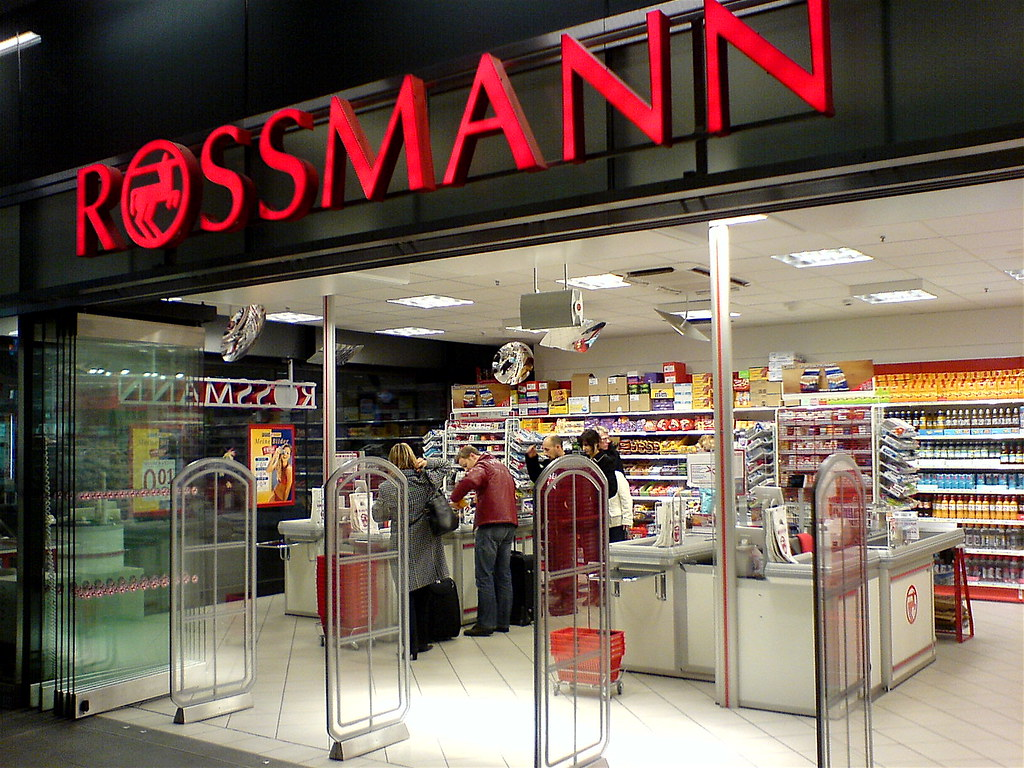

Rossmann is challenging you to predict **6 weeks of daily sales** for **1,115 stores** located across Germany

## Dataset
| Field                        | Description |
|-----------------------------|-------------|
| **Id**                      | An Id that represents a (Store, Date) duple within the test set. |
| **Store**                   | A unique Id for each store. |
| **Sales**                   | The turnover for any given day (this is what you are predicting). |
| **Customers**               | The number of customers on a given day. |
| **Open**                    | Indicator for whether the store was open: `0 = closed`, `1 = open`. |
| **StateHoliday**            | Indicates a state holiday: `a = public holiday`, `b = Easter holiday`, `c = Christmas`, `0 = None`. Most stores are closed on state holidays. |
| **SchoolHoliday**           | Indicates if the (Store, Date) was affected by public school closures. |
| **StoreType**               | Differentiates between 4 different store models: `a`, `b`, `c`, `d`. |
| **Assortment**              | Describes assortment level: `a = basic`, `b = extra`, `c = extended`. pick what product to sell and when |
| **CompetitionDistance**     | Distance in meters to the nearest competitor store. |
| **CompetitionOpenSinceMonth / Year** | Approximate month and year when the nearest competitor was opened. |
| **Promo**                   | Indicates whether a store is running a promo on that day. |
| **Promo2**                  | Indicates if the store is part of a continuous promotion: `0 = not participating`, `1 = participating`. |
| **Promo2SinceYear / Week**  | The year and calendar week when the store started participating in Promo2. |
| **PromoInterval**           | Months when Promo2 promotions start, e.g., `"Feb,May,Aug,Nov"` means rounds start in those months. |

# Libraries

In [176]:
# standard lib
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import tqdm
import sys
import os
sys.path.append(os.path.abspath(".."))


#time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.tsa.stattools import kpss,adfuller # to test if ts is stationary




#simple 
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing

#STL
from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.seasonal import STL


# Arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# prophet by Facebook
from prophet import Prophet

# ML
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor


#metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error


# 0. Reading the data

In [177]:
df_train = pd.read_csv('../data/train.csv', parse_dates=['Date'],low_memory=False)
df_store = pd.read_csv('../data/store.csv')

df_test = pd.read_csv('../data/test.csv', parse_dates=['Date'])

# 1. EDA

In [178]:
df_train.head()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5 2015-07-31   5263        555     1      1            0   
1      2          5 2015-07-31   6064        625     1      1            0   
2      3          5 2015-07-31   8314        821     1      1            0   
3      4          5 2015-07-31  13995       1498     1      1            0   
4      5          5 2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1

In [179]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  int64         
 6   Promo          1017209 non-null  int64         
 7   StateHoliday   1017209 non-null  object        
 8   SchoolHoliday  1017209 non-null  int64         
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 69.8+ MB


In [180]:
for col in df_train.columns:
    print(f"*****************{col}**********************")
    print(df_train[col].unique())
    print("*********************************************")
    print(df_train[col].value_counts())

*****************Store**********************
[   1    2    3 ... 1113 1114 1115]
*********************************************
Store
1      942
726    942
708    942
709    942
713    942
      ... 
159    758
637    758
636    758
633    758
155    758
Name: count, Length: 1115, dtype: int64
*****************DayOfWeek**********************
[5 4 3 2 1 7 6]
*********************************************
DayOfWeek
5    145845
4    145845
3    145665
2    145664
1    144730
7    144730
6    144730
Name: count, dtype: int64
*****************Date**********************
<DatetimeArray>
['2015-07-31 00:00:00', '2015-07-30 00:00:00', '2015-07-29 00:00:00',
 '2015-07-28 00:00:00', '2015-07-27 00:00:00', '2015-07-26 00:00:00',
 '2015-07-25 00:00:00', '2015-07-24 00:00:00', '2015-07-23 00:00:00',
 '2015-07-22 00:00:00',
 ...
 '2013-01-10 00:00:00', '2013-01-09 00:00:00', '2013-01-08 00:00:00',
 '2013-01-07 00:00:00', '2013-01-06 00:00:00', '2013-01-05 00:00:00',
 '2013-01-04 00:00:00', '2013-01-03 

In [181]:
df_train.describe()

Store     DayOfWeek                           Date  \
count  1.017209e+06  1.017209e+06                        1017209   
mean   5.584297e+02  3.998341e+00  2014-04-11 01:30:42.846061824   
min    1.000000e+00  1.000000e+00            2013-01-01 00:00:00   
25%    2.800000e+02  2.000000e+00            2013-08-17 00:00:00   
50%    5.580000e+02  4.000000e+00            2014-04-02 00:00:00   
75%    8.380000e+02  6.000000e+00            2014-12-12 00:00:00   
max    1.115000e+03  7.000000e+00            2015-07-31 00:00:00   
std    3.219087e+02  1.997391e+00                            NaN   

              Sales     Customers          Open         Promo  SchoolHoliday  
count  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06   1.017209e+06  
mean   5.773819e+03  6.331459e+02  8.301067e-01  3.815145e-01   1.786467e-01  
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   0.000000e+00  
25%    3.727000e+03  4.050000e+02  1.000000e+00  0.000000e+00   0.000000e+00  
50%    5.744000e+03  6.090000e+02  1.000000e+00  0.000000e+00   0.000000e+00  
75%    7.856000e+03  8.370000e+02  1.000000e+00  1.000000e+00   0.000000e+00  
max    4.155100e+04  7.388000e+03  1.000000e+00  1.000000e+00   1.000000e+00  
std    3.849926e+03  4.644117e+02  3.755392e-01  4.857586e-01   3.830564e-01

In [182]:
df_store.head()

Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a               1270.0                        9.0   
1      2         a          a                570.0                       11.0   
2      3         a          a              14130.0                       12.0   
3      4         c          c                620.0                        9.0   
4      5         a          a              29910.0                        4.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                    2008.0       0              NaN              NaN   
1                    2007.0       1             13.0           2010.0   
2                    2006.0       1             14.0           2011.0   
3                    2009.0       0              NaN              NaN   
4                    2015.0       0              NaN              NaN   

     PromoInterval  
0              NaN  
1  Jan,Apr,Jul,Oct  
2  Jan,Apr,Jul,Oct  
3              NaN  
4              NaN

In [183]:
df_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [184]:
for col in df_store.columns:
    print(f"*****************{col}**********************")
    print(df_store[col].unique())
    print("*********************************************")
    print(df_store[col].value_counts())

*****************Store**********************
[   1    2    3 ... 1113 1114 1115]
*********************************************
Store
1       1
742     1
748     1
747     1
746     1
       ..
378     1
379     1
380     1
381     1
1115    1
Name: count, Length: 1115, dtype: int64
*****************StoreType**********************
['c' 'a' 'd' 'b']
*********************************************
StoreType
a    602
d    348
c    148
b     17
Name: count, dtype: int64
*****************Assortment**********************
['a' 'c' 'b']
*********************************************
Assortment
a    593
c    513
b      9
Name: count, dtype: int64
*****************CompetitionDistance**********************
[1.270e+03 5.700e+02 1.413e+04 6.200e+02 2.991e+04 3.100e+02 2.400e+04
 7.520e+03 2.030e+03 3.160e+03 9.600e+02 1.070e+03 1.300e+03 4.110e+03
 3.270e+03 5.000e+01 1.384e+04 3.240e+03 2.340e+03 5.500e+02 1.040e+03
 4.060e+03 4.590e+03 4.300e+02 2.300e+03 6.000e+01 1.200e+03 2.170e+03
 4.000e+01 9.80

In [185]:
df_train['Date'].min(),df_train['Date'].max(),

(Timestamp('2013-01-01 00:00:00'), Timestamp('2015-07-31 00:00:00'))

In [186]:
full_range = pd.date_range(start=df_train.Date.min(), end=df_train.Date.max(), freq='D')  # 'D' = daily frequency
len(full_range)

942

In [187]:
df_train.shape

(1017209, 9)

In [188]:
df_train.isna().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [189]:
df_train.duplicated().sum()

0

## Closed but not a holiday

In [190]:
closed_df = df_train[df_train['Open'] == 0]

In [191]:
closed_store_no_holiday= df_train[(df_train["Open"] == 0) &
         (df_train["StateHoliday"] == "0")
         &(df_train["SchoolHoliday"] == 0)]
print(f"Number of times the stores closed without having a holiday: {len(closed_store_no_holiday)}")

Number of times the stores closed without having a holiday: 139610


In [192]:
closed_store_no_holiday.head()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
5575      1          7 2015-07-26      0          0     0      0            0   
5576      2          7 2015-07-26      0          0     0      0            0   
5577      3          7 2015-07-26      0          0     0      0            0   
5578      4          7 2015-07-26      0          0     0      0            0   
5579      5          7 2015-07-26      0          0     0      0            0   

      SchoolHoliday  
5575              0  
5576              0  
5577              0  
5578              0  
5579              0

In [193]:
print(f"Percentage of closed stores for refurbishments {(len(closed_store_no_holiday)/len(df_train)*100):.2f}%")

Percentage of closed stores for refurbishments 13.72%


In [194]:
## Open but no sales

open_sales_0 = \
df_train[(df_train["Open"] == 1) &
         (df_train["Sales"] == 0)]
print(f"Number of times the stores Open but no sales: {len(open_sales_0)}")

Number of times the stores Open but no sales: 54


## Few observations:
- It seems our data span a little over two years and a half: need to make sure that there is no missing date/ missing timestamps
- There is no missing timestamps: but our data is gathered to be store-day combinations, meaning each of the 1115 report their sales each day for 942 days.

    1115*942 = 1,050,330 row,

    while our data is 1,017,209 row,

    so we have 33,121 missing combinations.
    making some stores unfit for the analysis

- There are 139610 days closed store with no holiday:

    After reading the descrition of the this task, Rossman clearly stated that they were undergoing refurbishments sometimes and had to close. Most probably those were the times this event was happening.

    This can introduce bias to our models: closed days shouldn't be used for modeling
- the 54 days of open stores with no sales and no customers should't be used for modeling 


## Merge: 
I will not merge store and train as store features in not in test

In [195]:
df_full = pd.merge(df_train, df_store, on='Store', how='left')
df_full.head()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5 2015-07-31   5263        555     1      1            0   
1      2          5 2015-07-31   6064        625     1      1            0   
2      3          5 2015-07-31   8314        821     1      1            0   
3      4          5 2015-07-31  13995       1498     1      1            0   
4      5          5 2015-07-31   4822        559     1      1            0   

   SchoolHoliday StoreType Assortment  CompetitionDistance  \
0              1         c          a               1270.0   
1              1         a          a                570.0   
2              1         a          a              14130.0   
3              1         c          c                620.0   
4              1         a          a              29910.0   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                        9.0                    2008.0       0   
1                       11.0                    2007.0       1   
2                       12.0                    2006.0       1   
3                        9.0                    2009.0       0   
4                        4.0                    2015.0       0   

   Promo2SinceWeek  Promo2SinceYear    PromoInterval  
0              NaN              NaN              NaN  
1             13.0           2010.0  Jan,Apr,Jul,Oct  
2             14.0           2011.0  Jan,Apr,Jul,Oct  
3              NaN              NaN              NaN  
4              NaN              NaN              NaN

## Add More Features

In [196]:
df_full['Year'] = df_full['Date'].dt.year.iloc[0]
df_full['Month'] = df_full['Date'].dt.month.iloc[0]
df_full['Day'] = df_full['Date'].dt.day.iloc[0]
df_full['WeekOfYear'] = df_full['Date'].dt.isocalendar().week.iloc[0]

# adding new variable
df_full['SalePerCustomer'] = df_full['Sales']/df_full['Customers']
df_full['SalePerCustomer'].describe()

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalePerCustomer, dtype: float64

In [197]:
df_full.head()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5 2015-07-31   5263        555     1      1            0   
1      2          5 2015-07-31   6064        625     1      1            0   
2      3          5 2015-07-31   8314        821     1      1            0   
3      4          5 2015-07-31  13995       1498     1      1            0   
4      5          5 2015-07-31   4822        559     1      1            0   

   SchoolHoliday StoreType  ... CompetitionOpenSinceYear  Promo2  \
0              1         c  ...                   2008.0       0   
1              1         a  ...                   2007.0       1   
2              1         a  ...                   2006.0       1   
3              1         c  ...                   2009.0       0   
4              1         a  ...                   2015.0       0   

   Promo2SinceWeek  Promo2SinceYear    PromoInterval  Year  Month Day  \
0              NaN              NaN              NaN  2015      7  31   
1             13.0           2010.0  Jan,Apr,Jul,Oct  2015      7  31   
2             14.0           2011.0  Jan,Apr,Jul,Oct  2015      7  31   
3              NaN              NaN              NaN  2015      7  31   
4              NaN              NaN              NaN  2015      7  31   

   WeekOfYear  SalePerCustomer  
0          31         9.482883  
1          31         9.702400  
2          31        10.126675  
3          31         9.342457  
4          31         8.626118  

[5 rows x 23 columns]

In [198]:
df_full.sort_values(["Store", "Date"], inplace=True)


In [199]:
df_full["missing"] = (
    df_full["Sales"].isna() |
    ((df_full["Open"] == 1) & (df_full["Sales"] == 0))|
    ((df_full["Open"] == 0)
    &(df_full["StateHoliday"] == "0")
    &(df_full["SchoolHoliday"] == 0))
)

print(f"Missing rows: {df_full['missing'].sum()} out of {len(df_full)}")


Missing rows: 139664 out of 1017209


In [200]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1017209 entries, 1016095 to 1114
Data columns (total 24 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   Store                      1017209 non-null  int64         
 1   DayOfWeek                  1017209 non-null  int64         
 2   Date                       1017209 non-null  datetime64[ns]
 3   Sales                      1017209 non-null  int64         
 4   Customers                  1017209 non-null  int64         
 5   Open                       1017209 non-null  int64         
 6   Promo                      1017209 non-null  int64         
 7   StateHoliday               1017209 non-null  object        
 8   SchoolHoliday              1017209 non-null  int64         
 9   StoreType                  1017209 non-null  object        
 10  Assortment                 1017209 non-null  object        
 11  CompetitionDistance        1014567 non-

In [201]:
def preprocess_rossmann(df, is_train=True):
    # convert date if not parced already
    df['Date'] = pd.to_datetime(df['Date'])
    
    # extract calendar parts
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    
    # sales per customer
    df['SalePerCustomer'] = df['Sales'] / df['Customers']

    
    # missing flag (used to identify problematic rows)
    df["missing"] = (
        df["Sales"].isna() |
        ((df["Open"] == 1) & (df["Sales"] == 0)) |
        ((df["Open"] == 0) &
         (df["StateHoliday"].astype(str) == "0") &
         (df["SchoolHoliday"] == 0))
        
    )
    # Map StateHoliday from {'a','b','c','0'}
    state_holiday_map = {'0': 0, 'a': 1, 'b': 2, 'c': 3}
    df['StateHoliday'] = df['StateHoliday'].astype(str).map(state_holiday_map).fillna(0).astype(int)
    
    # drop rows with missing flag if training
    if is_train:
        df['Assortment'] = df['Assortment'].astype(str).map(state_holiday_map).fillna(0).astype(int)
        df['StoreType'] = df['StoreType'].astype(str).map(state_holiday_map).fillna(0).astype(int)

        df = df[~df["missing"]].copy()
        df.drop(columns = ['PromoInterval'], inplace = True)
        
    return df
    
    


In [202]:
df_full = preprocess_rossmann(df_full, is_train=True)

In [203]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 877545 entries, 1016095 to 1114
Data columns (total 23 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      877545 non-null  int64         
 1   DayOfWeek                  877545 non-null  int64         
 2   Date                       877545 non-null  datetime64[ns]
 3   Sales                      877545 non-null  int64         
 4   Customers                  877545 non-null  int64         
 5   Open                       877545 non-null  int64         
 6   Promo                      877545 non-null  int64         
 7   StateHoliday               877545 non-null  int32         
 8   SchoolHoliday              877545 non-null  int64         
 9   StoreType                  877545 non-null  int32         
 10  Assortment                 877545 non-null  int32         
 11  CompetitionDistance        875278 non-null  float64  

In [204]:
df_full.head()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo  \
1016095      1          2 2013-01-01      0          0     0      0   
1014980      1          3 2013-01-02   5530        668     1      0   
1013865      1          4 2013-01-03   4327        578     1      0   
1012750      1          5 2013-01-04   4486        619     1      0   
1011635      1          6 2013-01-05   4997        635     1      0   

         StateHoliday  SchoolHoliday  StoreType  ...  \
1016095             1              1          3  ...   
1014980             0              1          3  ...   
1013865             0              1          3  ...   
1012750             0              1          3  ...   
1011635             0              1          3  ...   

         CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
1016095                    2008.0       0              NaN              NaN   
1014980                    2008.0       0              NaN              NaN   
1013865                    2008.0       0              NaN              NaN   
1012750                    2008.0       0              NaN              NaN   
1011635                    2008.0       0              NaN              NaN   

         Year  Month  Day  WeekOfYear  SalePerCustomer  missing  
1016095  2013      1    1           1              NaN    False  
1014980  2013      1    2           1         8.278443    False  
1013865  2013      1    3           1         7.486159    False  
1012750  2013      1    4           1         7.247173    False  
1011635  2013      1    5           1         7.869291    False  

[5 rows x 23 columns]

## Visualization

(array([144423., 145432.,      0., 145442.,      0., 145612., 145644.,
             0., 144450.,   6542.]),
 array([1. , 1.6, 2.2, 2.8, 3.4, 4. , 4.6, 5.2, 5.8, 6.4, 7. ]),
 <BarContainer object of 10 artists>)

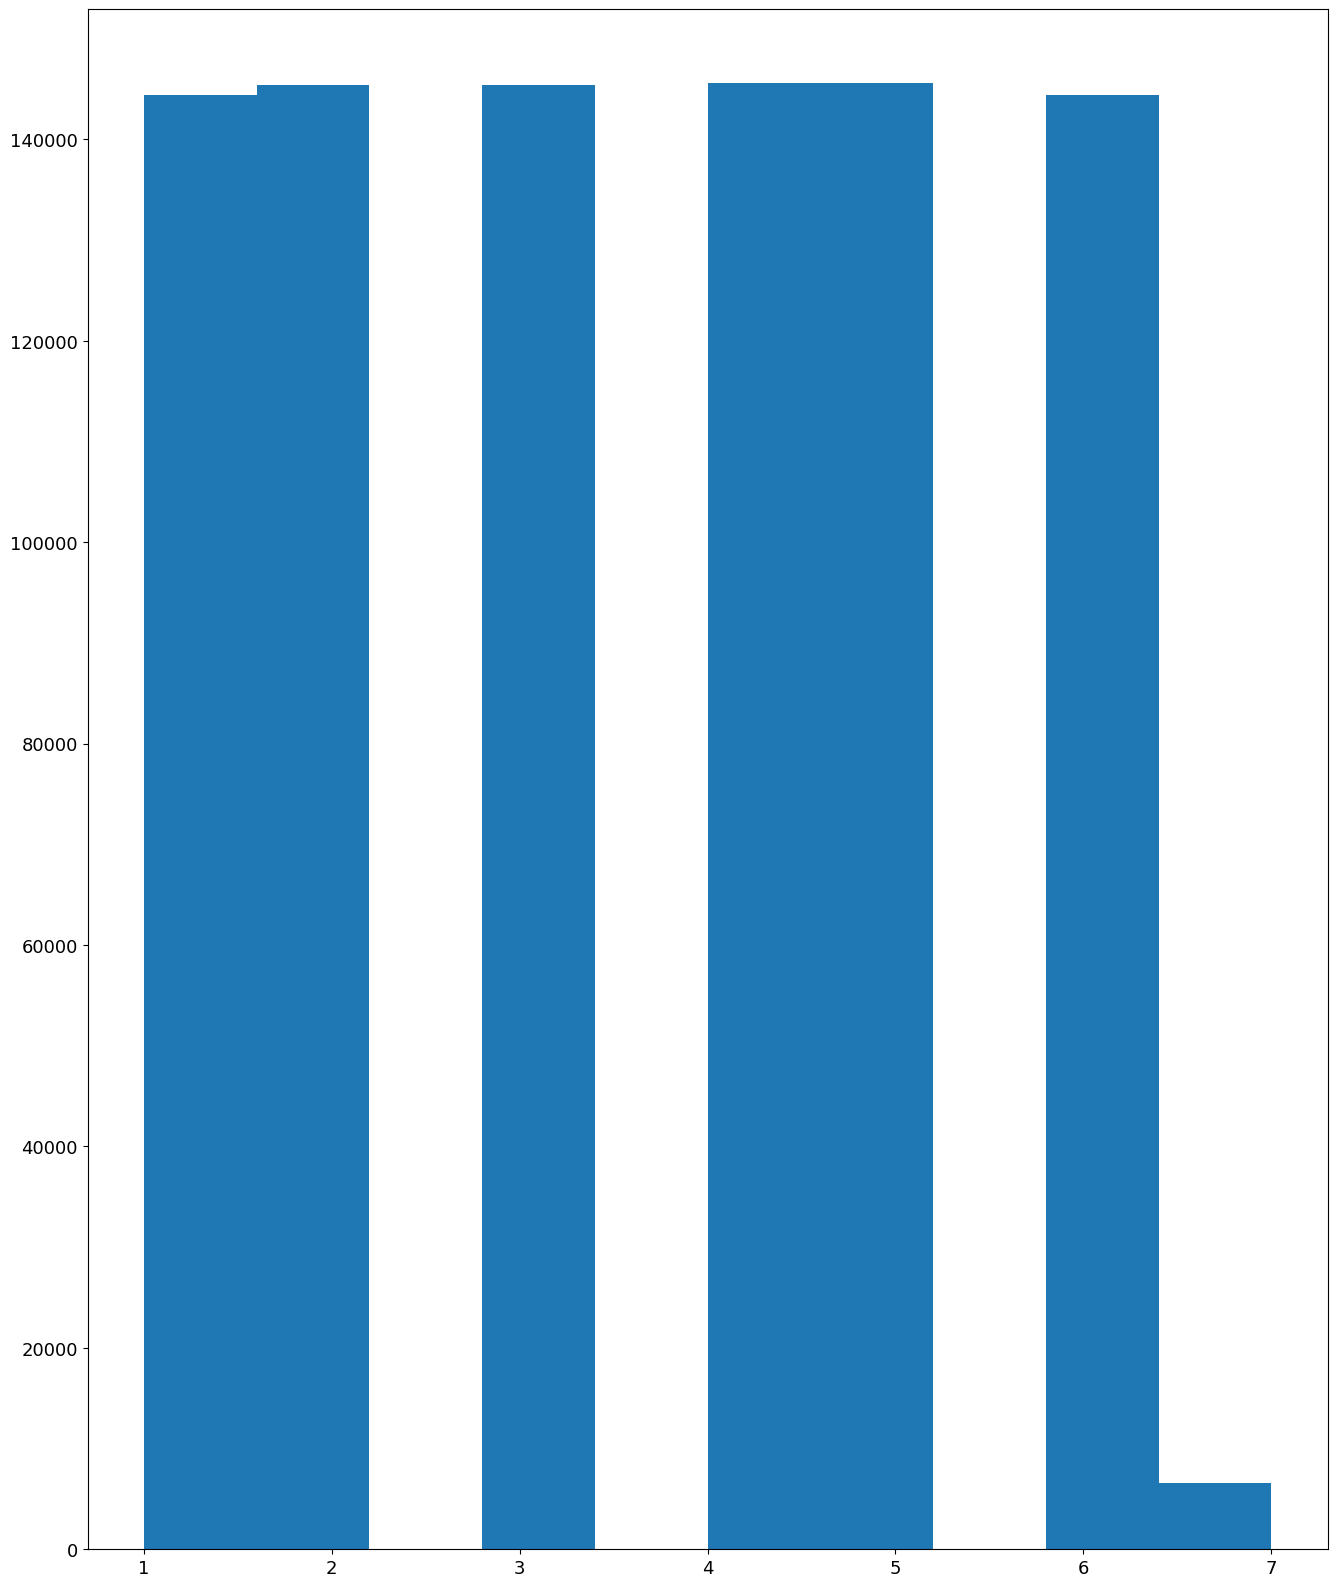

In [205]:
plt.hist(df_full['DayOfWeek'])

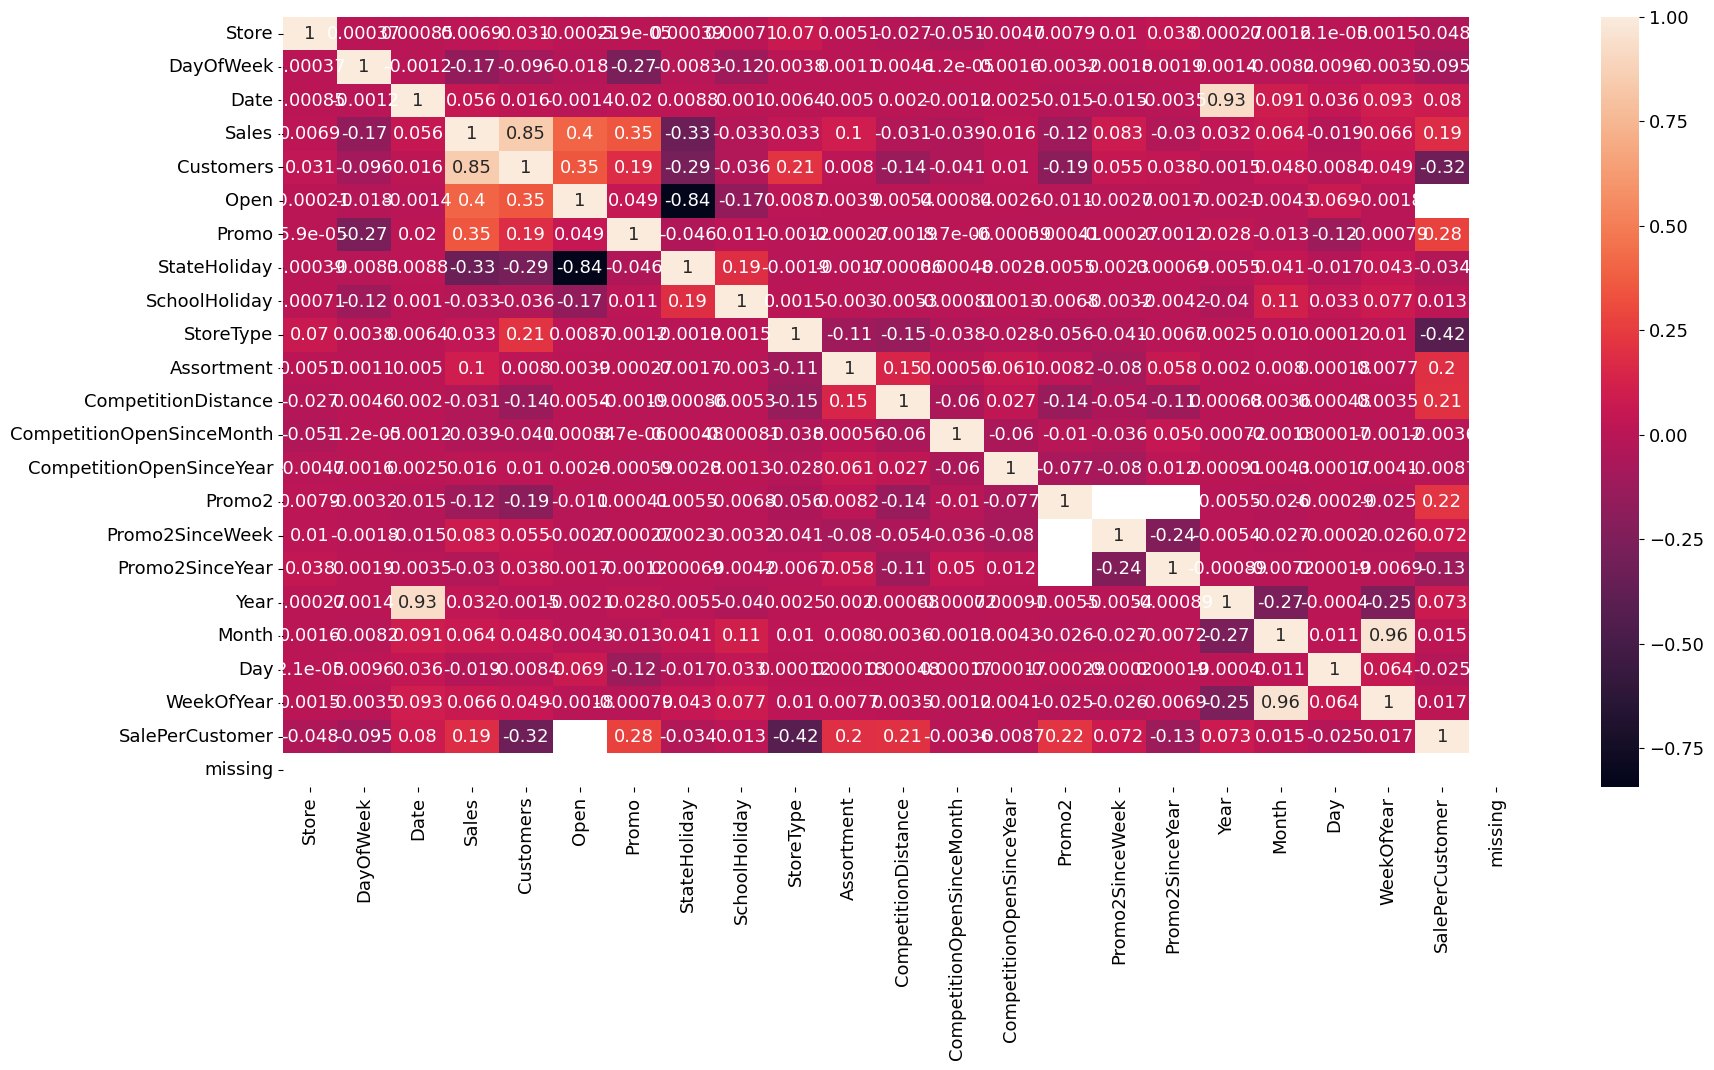

In [206]:
# Correlation
plt.figure(figsize = (20, 10))
sns.heatmap(df_full.corr(), annot = True);

## Sales distribution

In [207]:
df_full['Sales'].describe()

count    877545.000000
mean       6692.740114
std        3321.262273
min           0.000000
25%        4672.000000
50%        6244.000000
75%        8257.000000
max       41551.000000
Name: Sales, dtype: float64

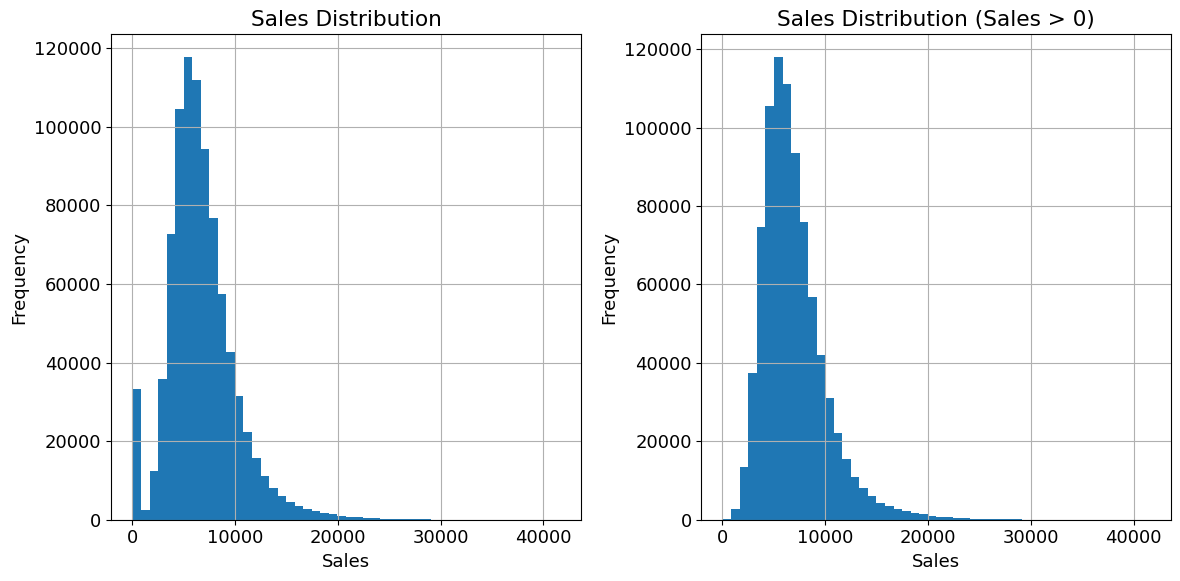

In [208]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
df_full['Sales'].hist(bins=50)
plt.title('Sales Distribution')
plt.xlabel('Sales')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
df_full[df_full['Sales'] > 0]['Sales'].hist(bins=50)
plt.title('Sales Distribution (Sales > 0)')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

<Figure size 1400x600 with 0 Axes>

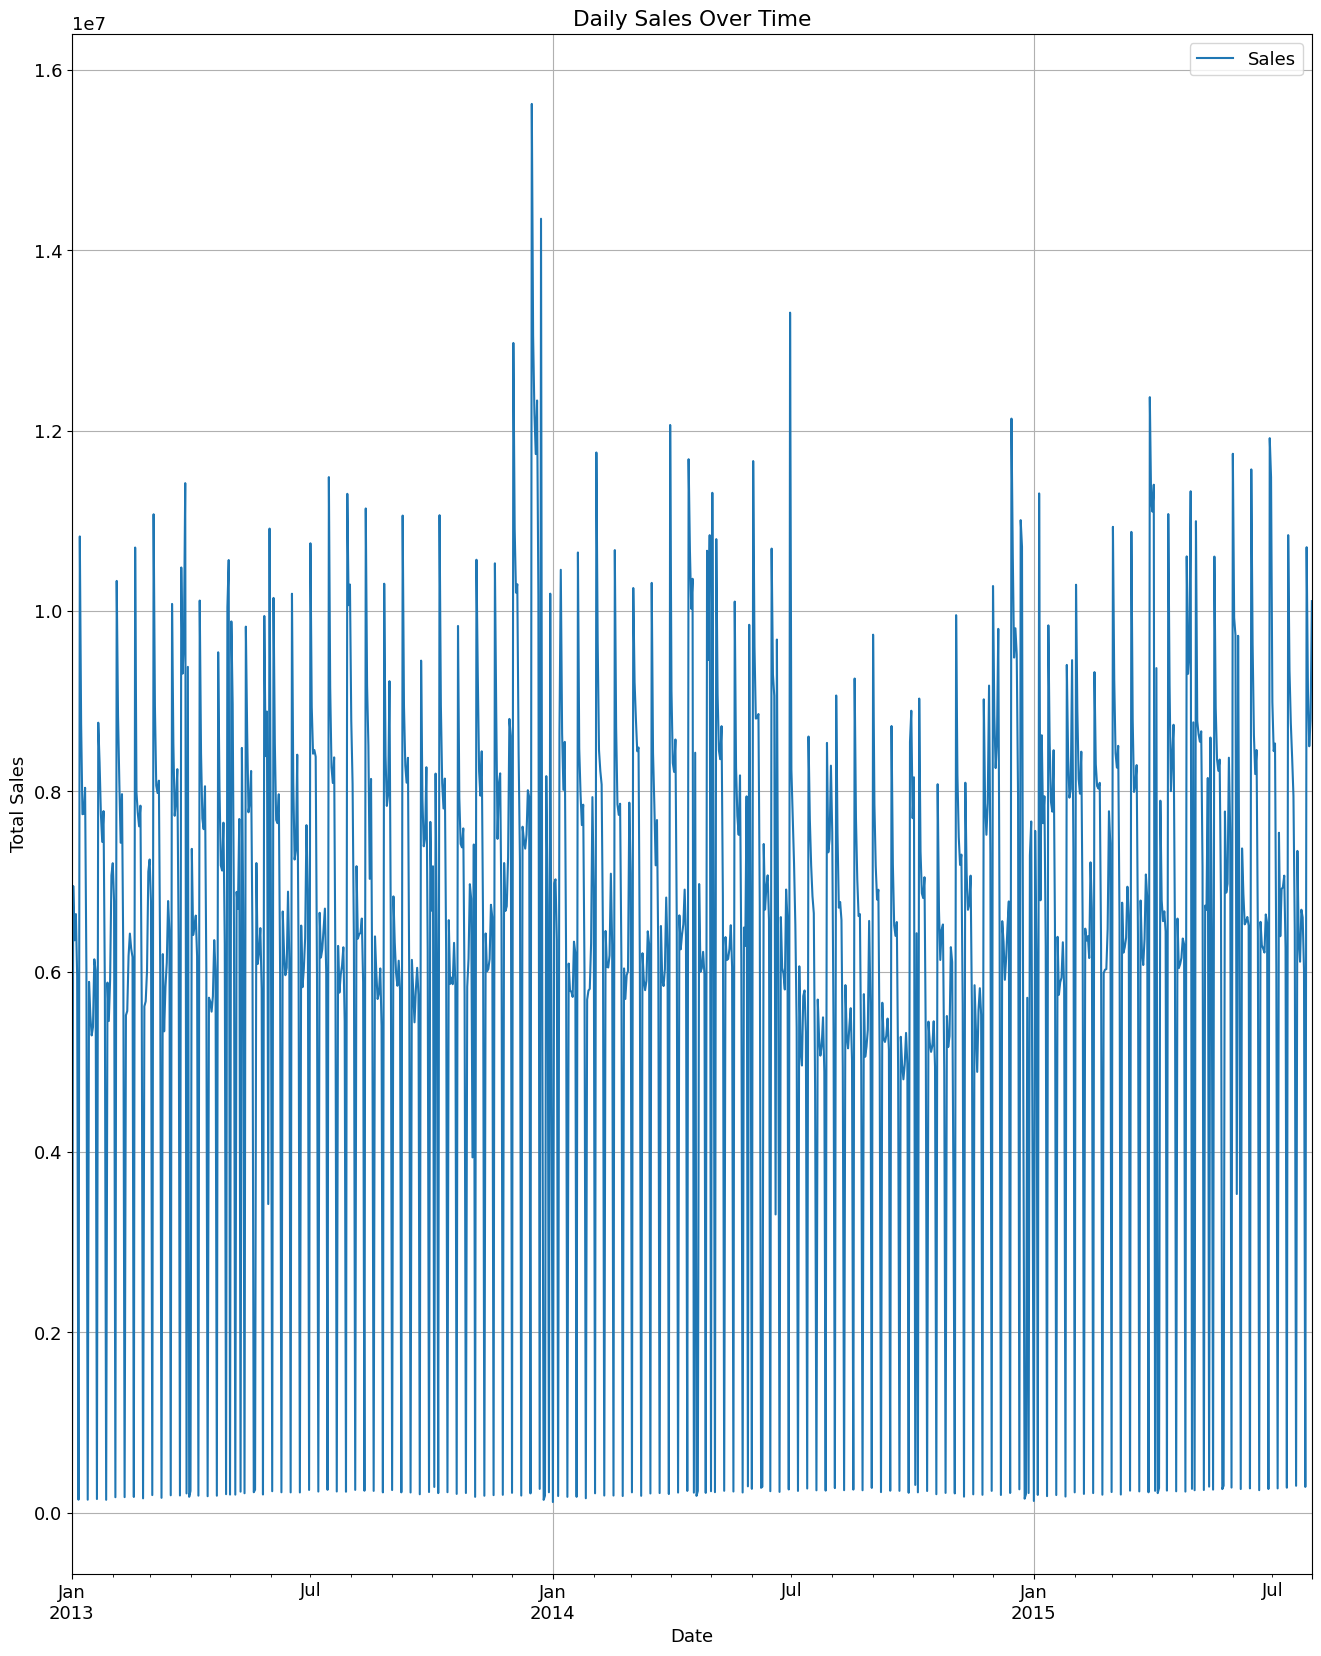

In [209]:
daily_sales = df_full.groupby('Date')['Sales'].sum().reset_index()
daily_sales.set_index('Date', inplace=True)

plt.figure(figsize=(14, 6))
daily_sales.plot()
plt.title('Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

In [210]:
daily_sales['Year'] = daily_sales.index.year
daily_sales['Month'] = daily_sales.index.month
daily_sales['Day'] = daily_sales.index.day
daily_sales['DayOfWeek'] = daily_sales.index.dayofweek
daily_sales['WeekOfYear'] = daily_sales.index.isocalendar().week

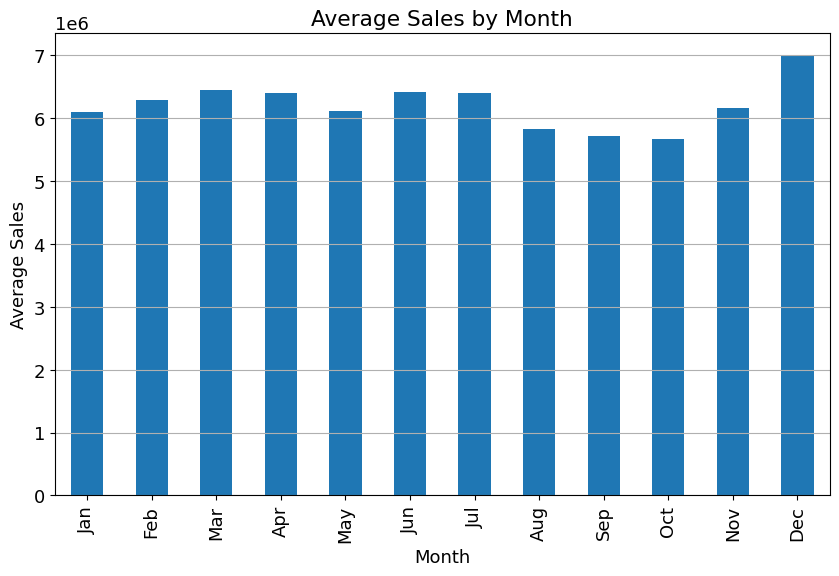

In [211]:
monthly_sales = daily_sales.groupby('Month')['Sales'].mean()
plt.figure(figsize=(10, 6))
monthly_sales.plot(kind='bar')
plt.title('Average Sales by Month')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True, axis='y')
plt.show()

c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\USER\AppData\Local\Temp\ipykernel_2620\602274246.py:14: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


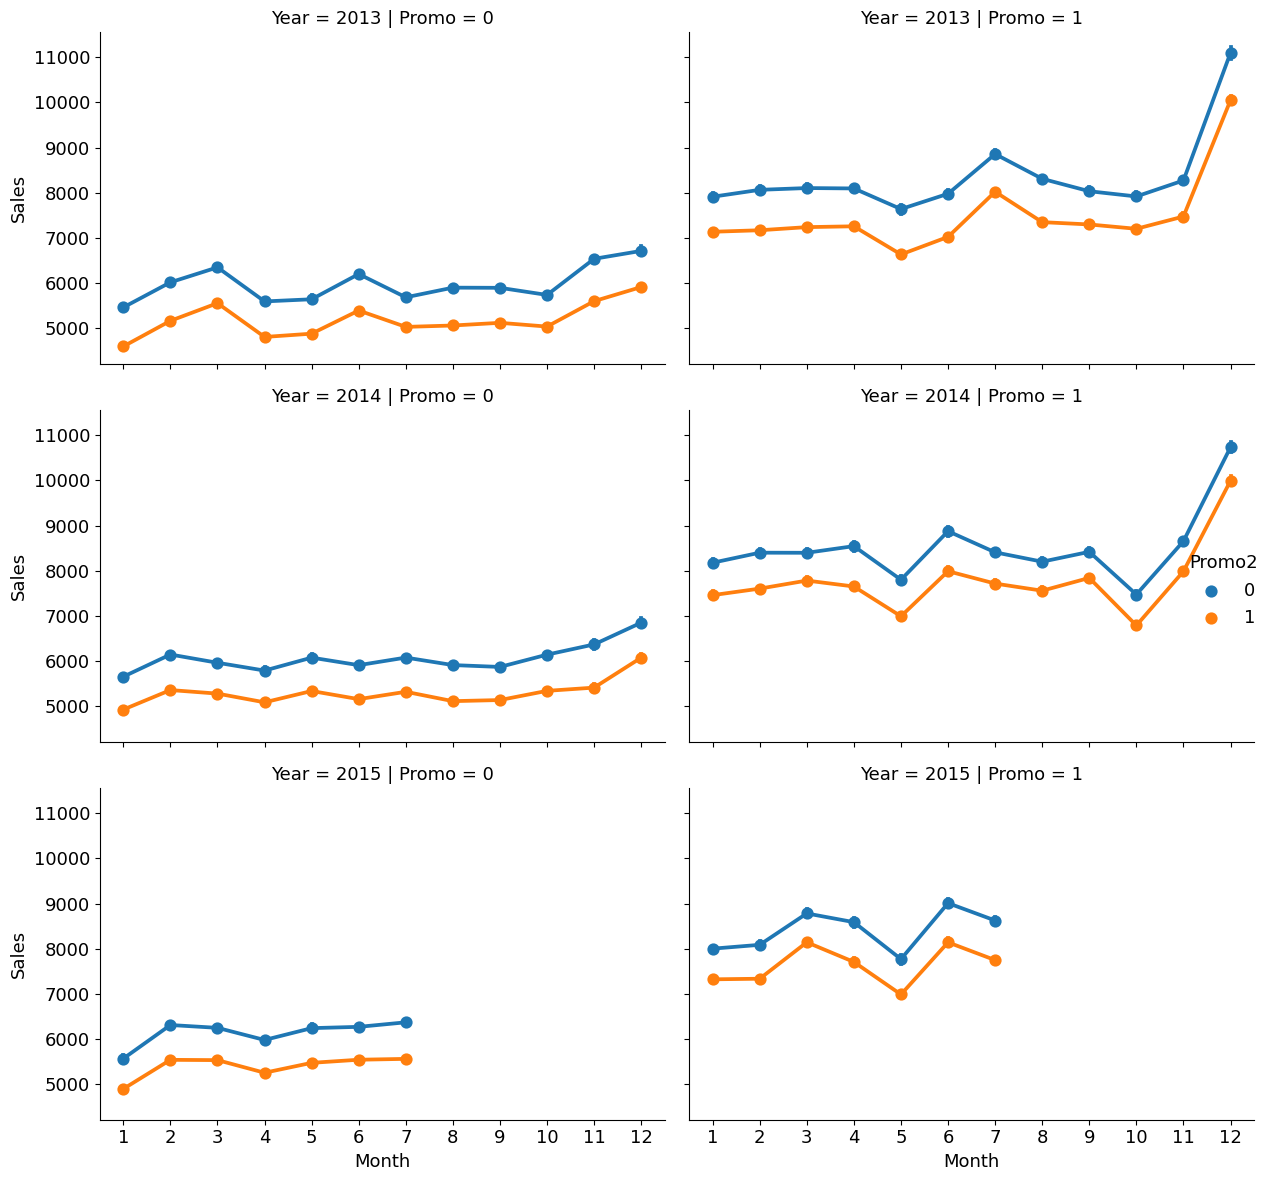

In [212]:
# Sales trend over the months
sns.catplot(
    data=df_full,
    x="Month",
    y="Sales",
    col="Promo",
    hue="Promo2",
    row="Year",
    kind="point",  # you can use "point" or "box" too
    height=4,
    aspect=1.5
)

plt.tight_layout()
plt.show()


We can see from the above trends that sales tend to spike in November and December. So, there is a seasonality factor present in the data.

c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


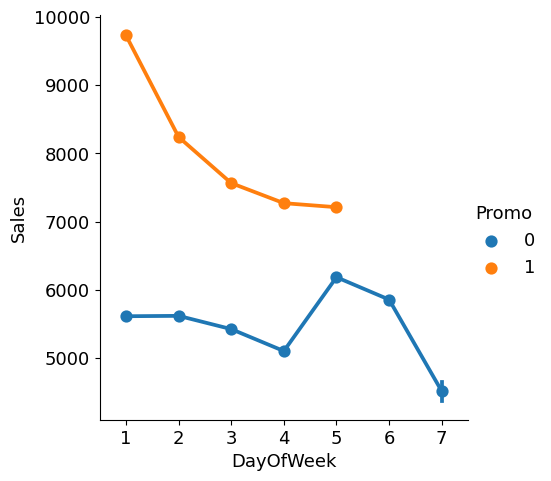

In [213]:
# Sales trend over days
sns.catplot(data = df_full, x = "DayOfWeek", y = "Sales", hue = "Promo", kind="point");

It make sense as the store is closed on sunday

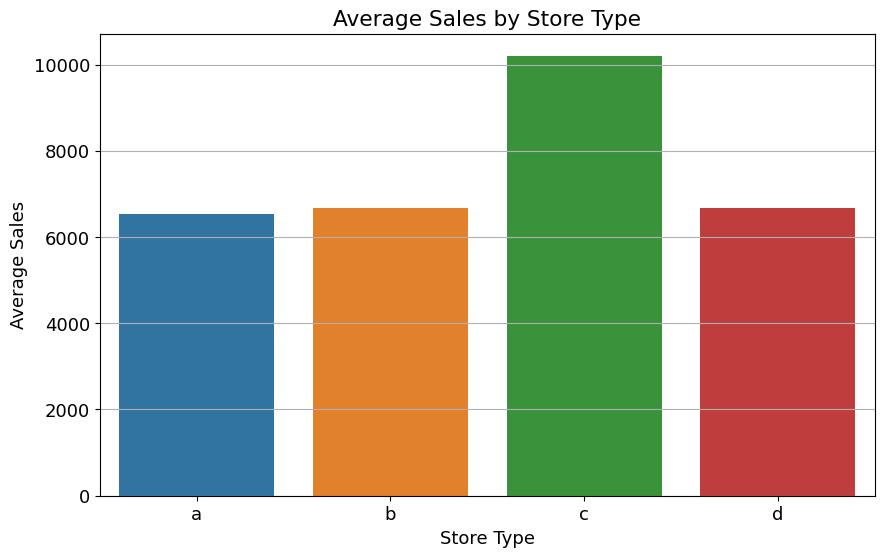

In [214]:
store_type_sales = df_full.groupby('StoreType')['Sales'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x='StoreType', y='Sales', data=store_type_sales)
plt.title('Average Sales by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Average Sales')
plt.xticks(ticks = [0,1,2,3],labels=['a','b','c','d'])
plt.grid(True, axis='y')
plt.show()

The heighest sales is of store type C

Choose The Store We will work on (Store 7)

In [215]:
df_7 = df_full[(df_full["Store"] == 7) & (df_full['Open'] == 1)].set_index('Date')
sales_7 = df_7['Sales']



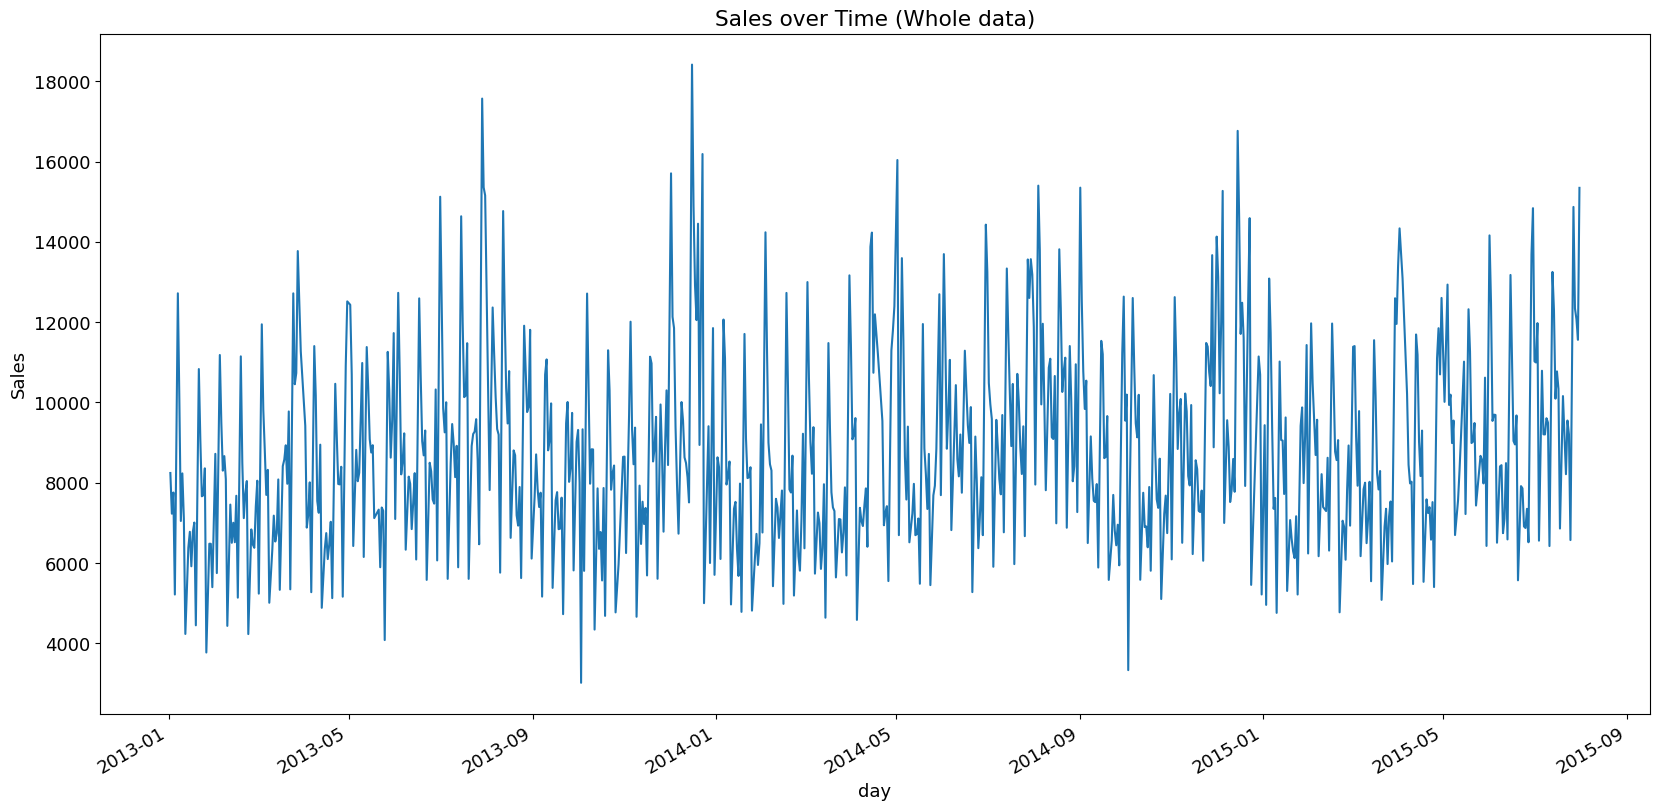

In [216]:
plt.figure(figsize=(20,10))
df_7["Sales"].plot()
# plt.ylim(bottom=0)
plt.xlabel('day')
plt.ylabel('Sales')
plt.title('Sales over Time (Whole data)')
plt.show()

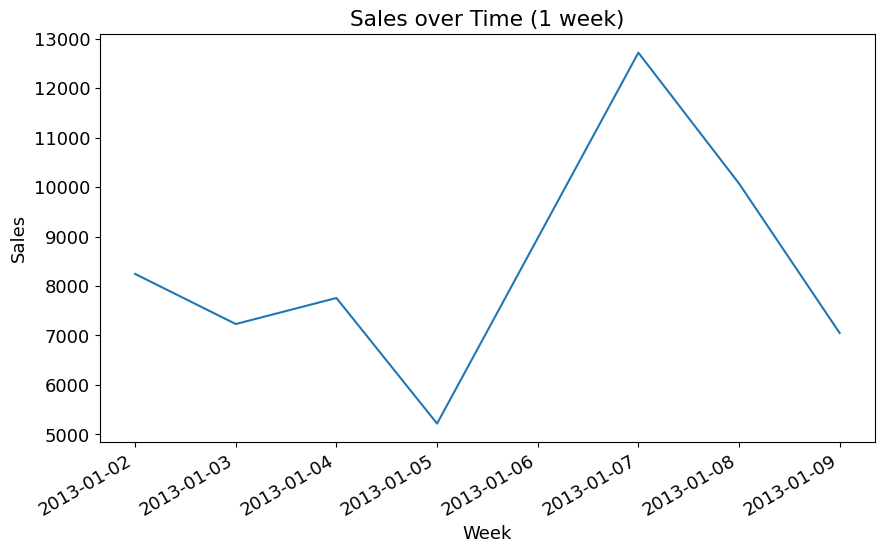

In [217]:
plt.figure(figsize=(10, 6))
df_7['Sales'][:7].plot()
plt.xlabel('Week')
plt.ylabel('Sales')
plt.title('Sales over Time (1 week)')
plt.show()

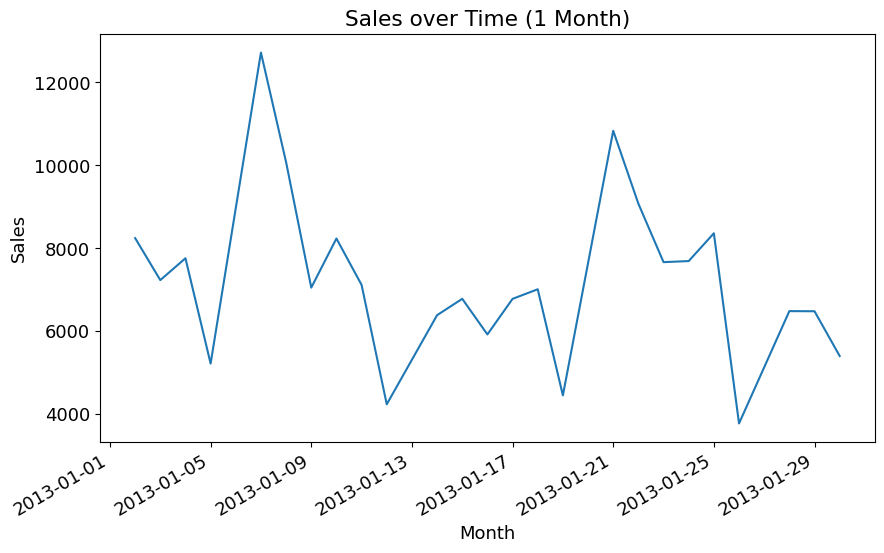

In [218]:
plt.figure(figsize=(10, 6))
df_7['Sales'][:25].plot()
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Sales over Time (1 Month)')
plt.show()

In [219]:
df_7.head()

Store  DayOfWeek  Sales  Customers  Open  Promo  StateHoliday  \
Date                                                                        
2013-01-02      7          3   8244        955     1      0             0   
2013-01-03      7          4   7231        867     1      0             0   
2013-01-04      7          5   7758        870     1      0             0   
2013-01-05      7          6   5218        575     1      0             0   
2013-01-07      7          1  12718       1150     1      1             0   

            SchoolHoliday  StoreType  Assortment  ...  \
Date                                              ...   
2013-01-02              1          1           3  ...   
2013-01-03              1          1           3  ...   
2013-01-04              1          1           3  ...   
2013-01-05              0          1           3  ...   
2013-01-07              0          1           3  ...   

            CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  \
Date                                                            
2013-01-02                    2013.0       0              NaN   
2013-01-03                    2013.0       0              NaN   
2013-01-04                    2013.0       0              NaN   
2013-01-05                    2013.0       0              NaN   
2013-01-07                    2013.0       0              NaN   

            Promo2SinceYear  Year  Month  Day  WeekOfYear  SalePerCustomer  \
Date                                                                         
2013-01-02              NaN  2013      1    2           1         8.632461   
2013-01-03              NaN  2013      1    3           1         8.340254   
2013-01-04              NaN  2013      1    4           1         8.917241   
2013-01-05              NaN  2013      1    5           1         9.074783   
2013-01-07              NaN  2013      1    7           2        11.059130   

            missing  
Date                 
2013-01-02    False  
2013-01-03    False  
2013-01-04    False  
2013-01-05    False  
2013-01-07    False  

[5 rows x 22 columns]

In [220]:
def draw_seasonal_box_plot(df, col_name):
    # Draw Plot
    
    #plt.figure(figsize=(10, 10))  # Adjust the figsize as needed
    fig, axes = plt.subplots(1, 3,figsize=(15, 10))
    sns.boxplot(x='Year', y=col_name, data=df, ax=axes[0])
    #sns.boxplot(x='Quarter', y=col_name, data=df, ax=axes[1])
    sns.boxplot(x='Month', y=col_name, data=df, ax=axes[1])
    sns.boxplot(x='DayOfWeek', y=col_name, data=df, ax=axes[2])
    # Set Title
    axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=10)
    #axes[1].set_title('Quarter-wise Box Plot\n(The Seasonality)', fontsize=10)
    axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=10)
    axes[2].set_title('Weeknumber-wise Box Plot\n(The Seasonality)', fontsize=10)
    
    plt.tight_layout()
    plt.show()

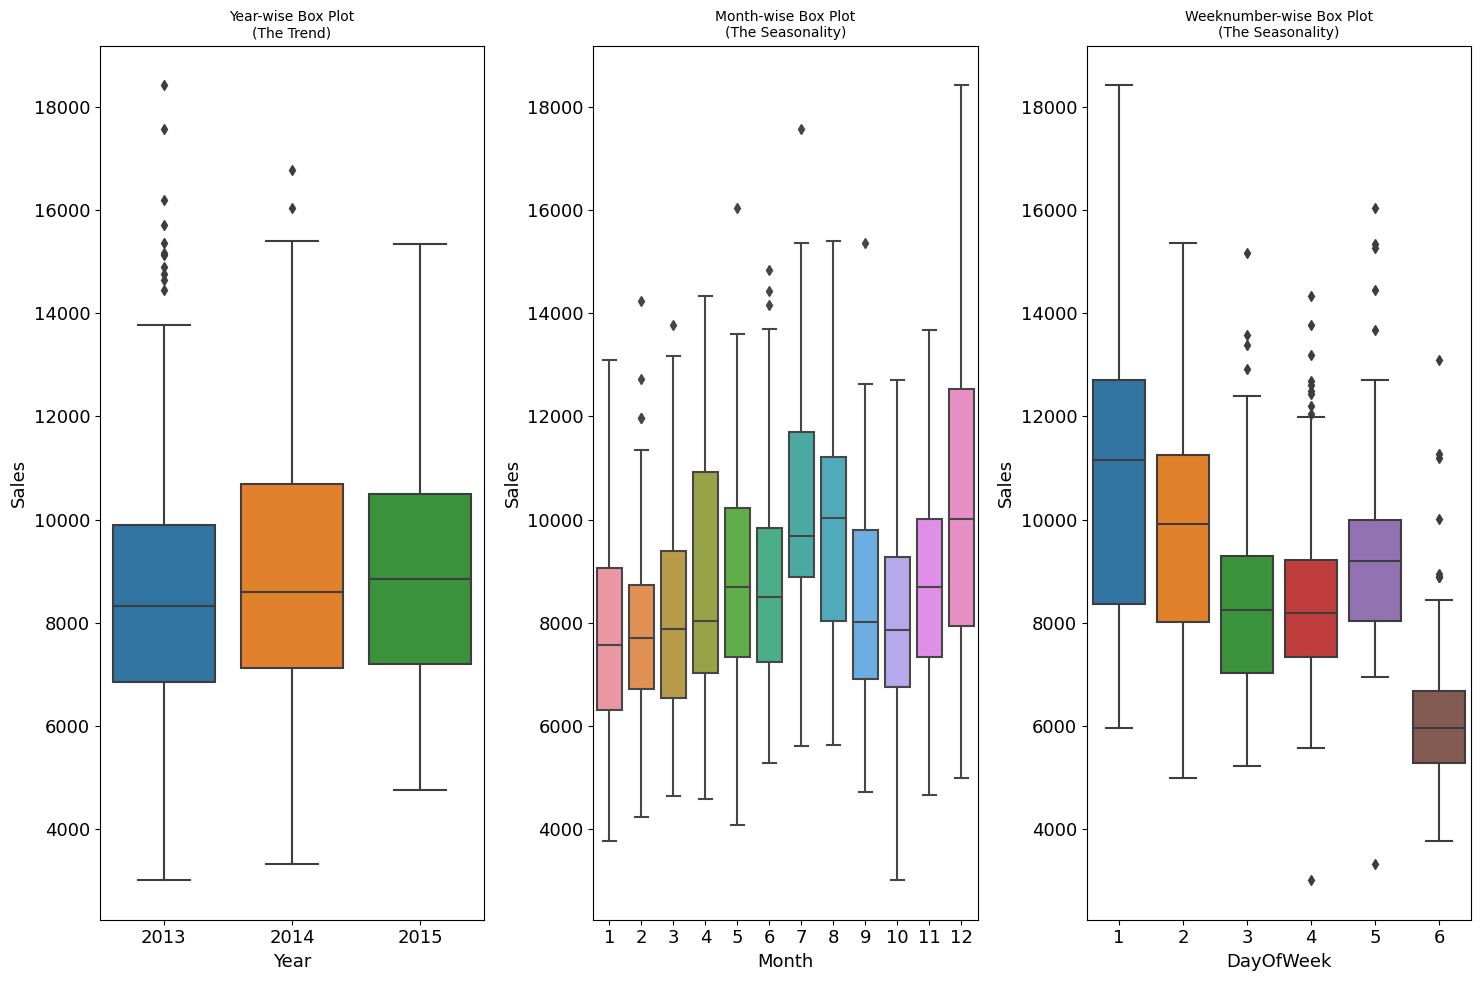

In [221]:
draw_seasonal_box_plot(df_7,"Sales")

- The peak of sales are in Nov and Dec (last two month because of holidays)
- 2014 has higher sales than the rest 
- Sales are better in Monday as the store is usually closed in Sunday

In [222]:
def monthly_quarter_line_plot(df,col_x,col_y,hue_col,title="Monthly"):
    plt.figure(figsize=(10,8))
    sns.lineplot(data=df,
                 x=col_x,
                 y=col_y,
                 hue=hue_col,
                 legend='full',palette="tab10")

    # add title
    plt.title(title+' Seasonal plot')

    # move the legend outside of the main figure
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packa

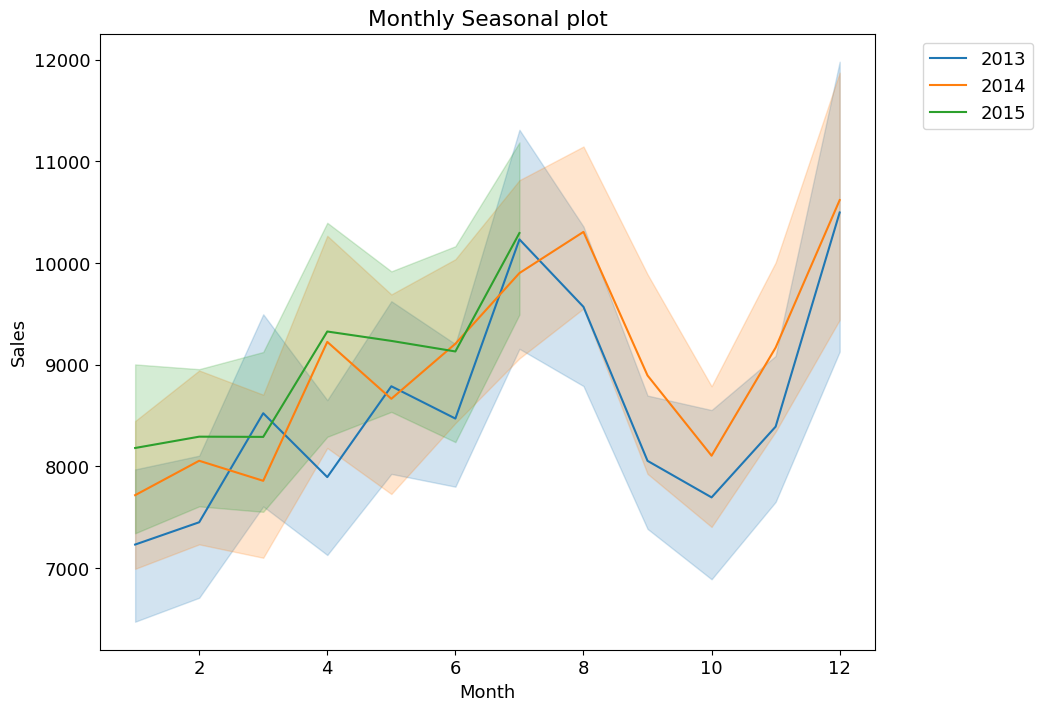

In [223]:
monthly_quarter_line_plot(df_7,"Month","Sales","Year",title="Monthly")

### Stationarity of Time Series 
In order to use time series forecasting models, we need to ensure that our time series data is stationary i.e constant mean, constant variance and constant covariance with time. 

There are 2 ways to test the stationarity of time series
1. Rolling Mean: Visualization
2. Dicky - Fuller test: Statistical test

1. Rolling Mean: A rolling analysis of a time series model is often used to assess the model's stability over time. The window is rolled (slid across the data) on a weekly basis, in which the average is taken on a weekly basis. Rolling Statistics is a visualization test, where we can compare the original data with the rolled data and check if the data is stationary or not.

2. Dicky -Fuller test: This test provides us the statistical data such as p-value to understand whether we can reject the null hypothesis. The null hypothesis is that data is not stationary and the alternative hypothesis says that data is stationary. If p-value is less than the critical value (say 0.5), we will reject the null hypothesis and say that data is stationary.

In [224]:
def test_stationarity(timeseries):
    result = adfuller(timeseries.dropna())
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    
    if result[1] <= 0.05:
        print("Result: The series is stationary")
    else:
        print("Result: The series is non-stationary")

print("Stationarity Test for Original Series:")
test_stationarity(df_7['Sales'])

Stationarity Test for Original Series:
ADF Statistic: -5.006395
p-value: 0.000022
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
Result: The series is stationary


In [225]:
# Function to test the stationarity
def test_stationarity_rolling(timeseries):
    
    # Determing rolling statistics
    roll_mean = timeseries.rolling(window=7).mean()
    roll_std = timeseries.rolling(window=7).std()

    # Plotting rolling statistics:
    orig = plt.plot(timeseries.resample('W').mean(), color='blue',label='Original')
    mean = plt.plot(roll_mean.resample('W').mean(), color='red', label='Rolling Mean')
    std = plt.plot(roll_std.resample('W').mean(), color='green', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.xticks(rotation= 45)
    plt.tight_layout()
    plt.show()
    
    



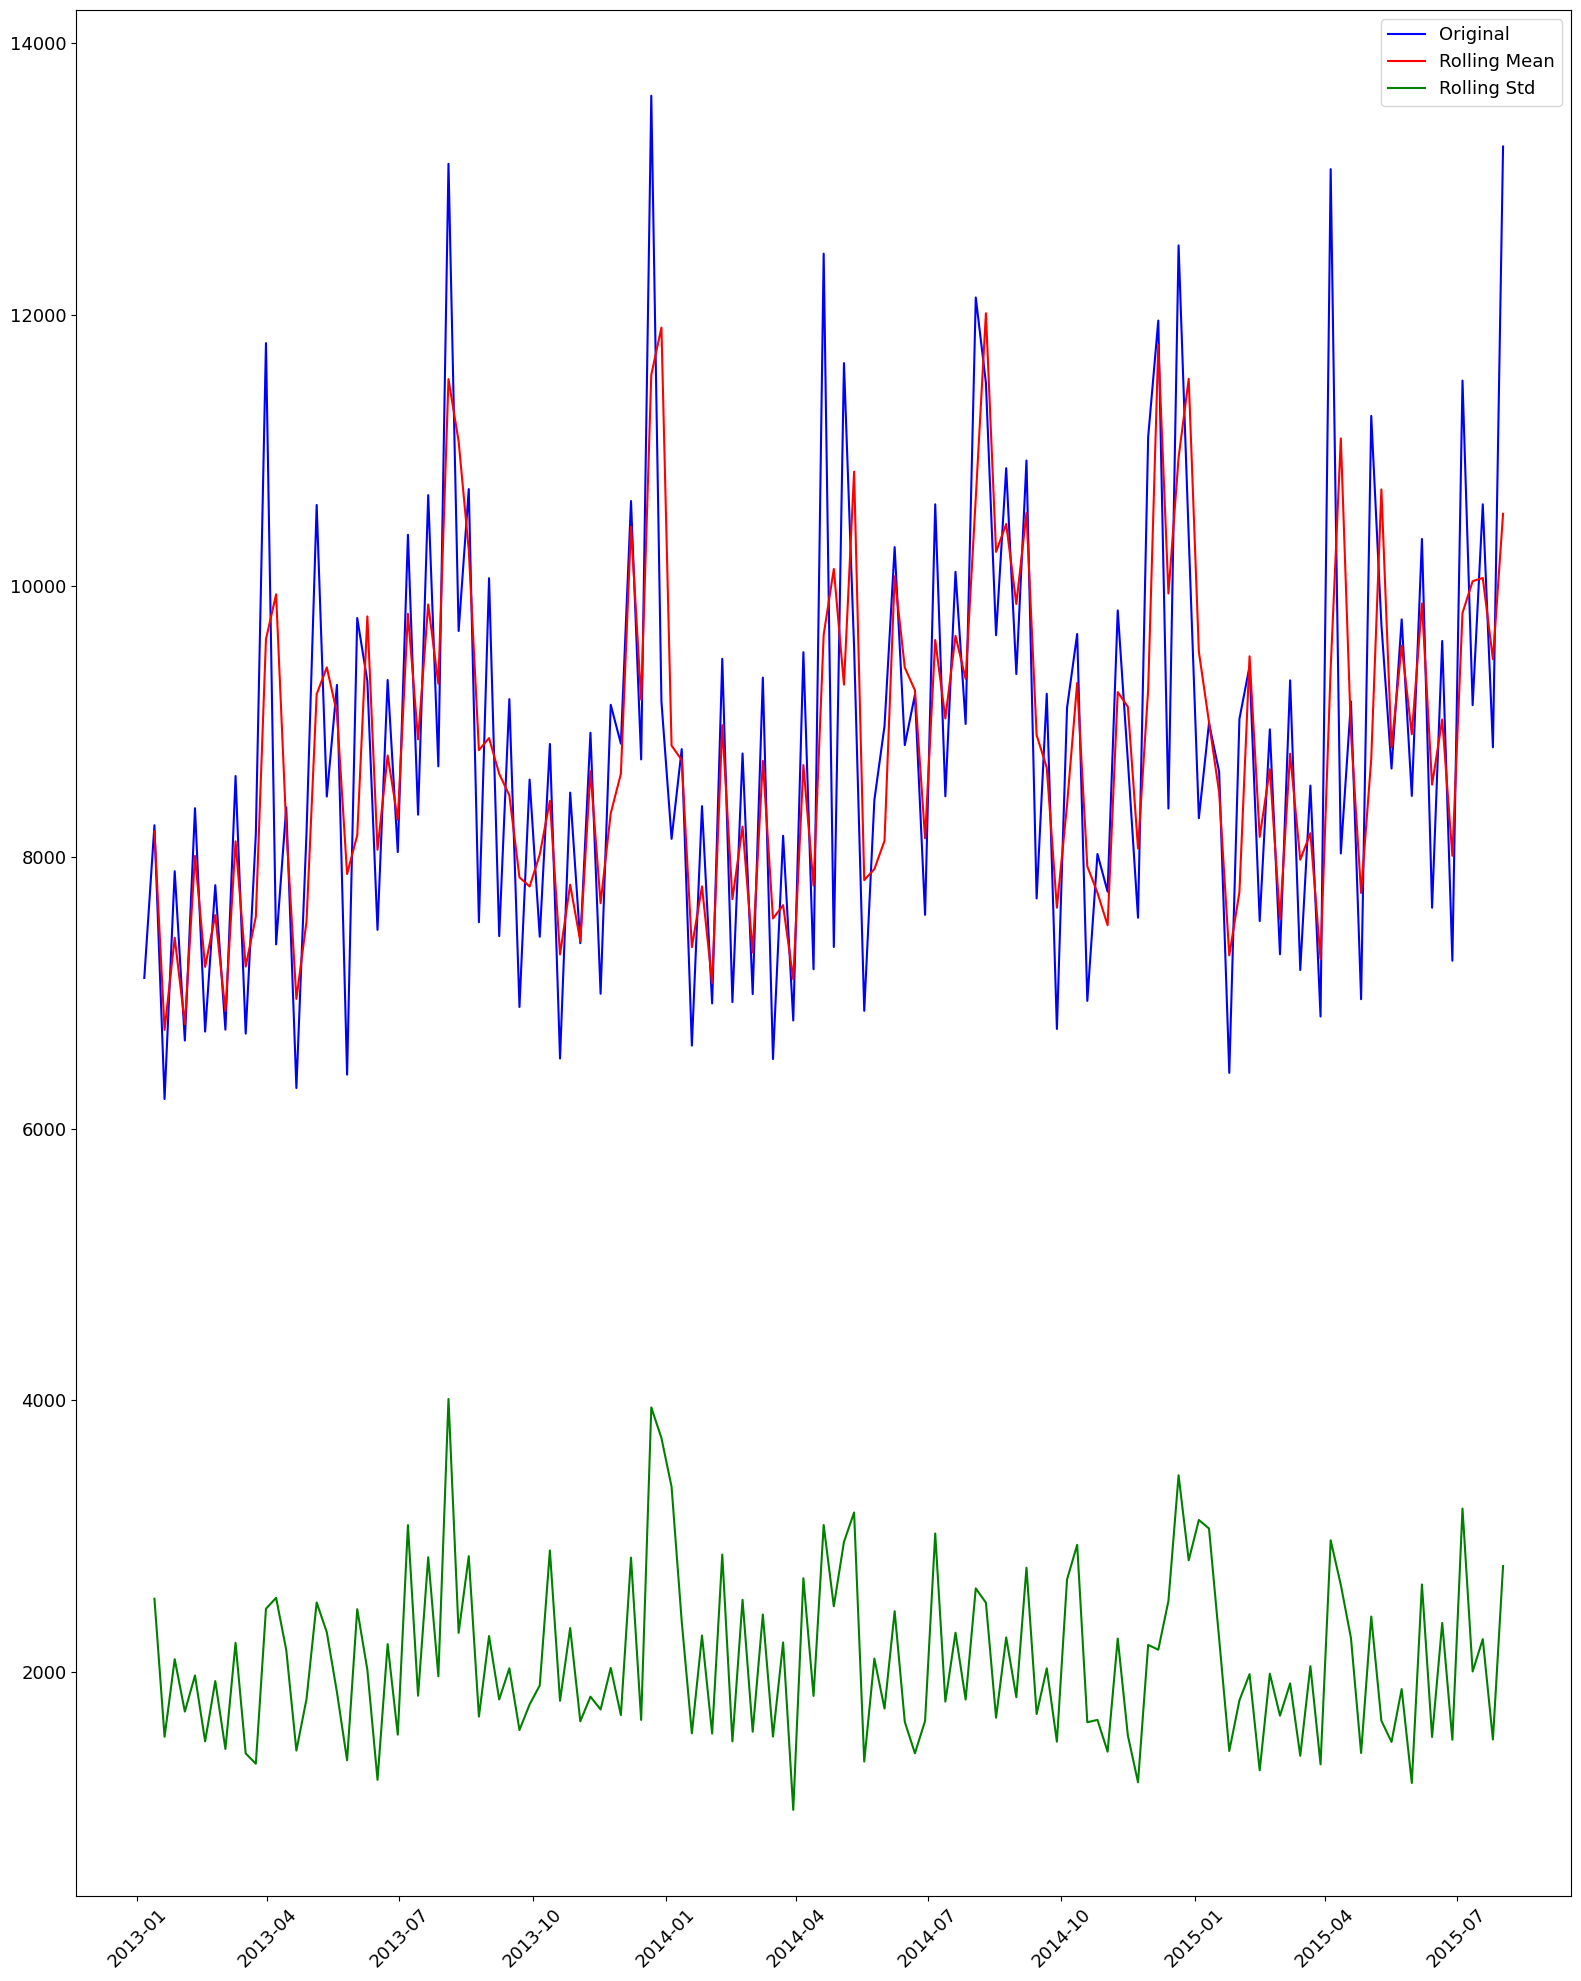

In [226]:
test_stationarity_rolling(sales_7)

We can see from the above plots and statistical tests that mean and variation doesn't change much with time, i.e they are constant. Thus, we don't need to perform any transformation (needed when time series is not stationary). 

In [227]:
def rmspe(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_indices = y_true != 0
    y_true_nz = y_true[non_zero_indices]
    y_pred_nz = y_pred[non_zero_indices]
    
    percentage_error = np.abs((y_true_nz - y_pred_nz) / y_true_nz)
    return np.sqrt(np.mean(percentage_error ** 2))

def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    rmspe_val = rmspe(y_true, y_pred)
    
    print(f"{model_name} Results:")
    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"RMSPE: {rmspe_val:.4f}")
    print("*" * 40)
    
    return model_name, mse, rmse, mae, rmspe_val

In [228]:
validation_days = 30
train_data = df_7.iloc[:-validation_days]
valid_data = df_7.iloc[-validation_days:]
y_true = valid_data['Sales'].values

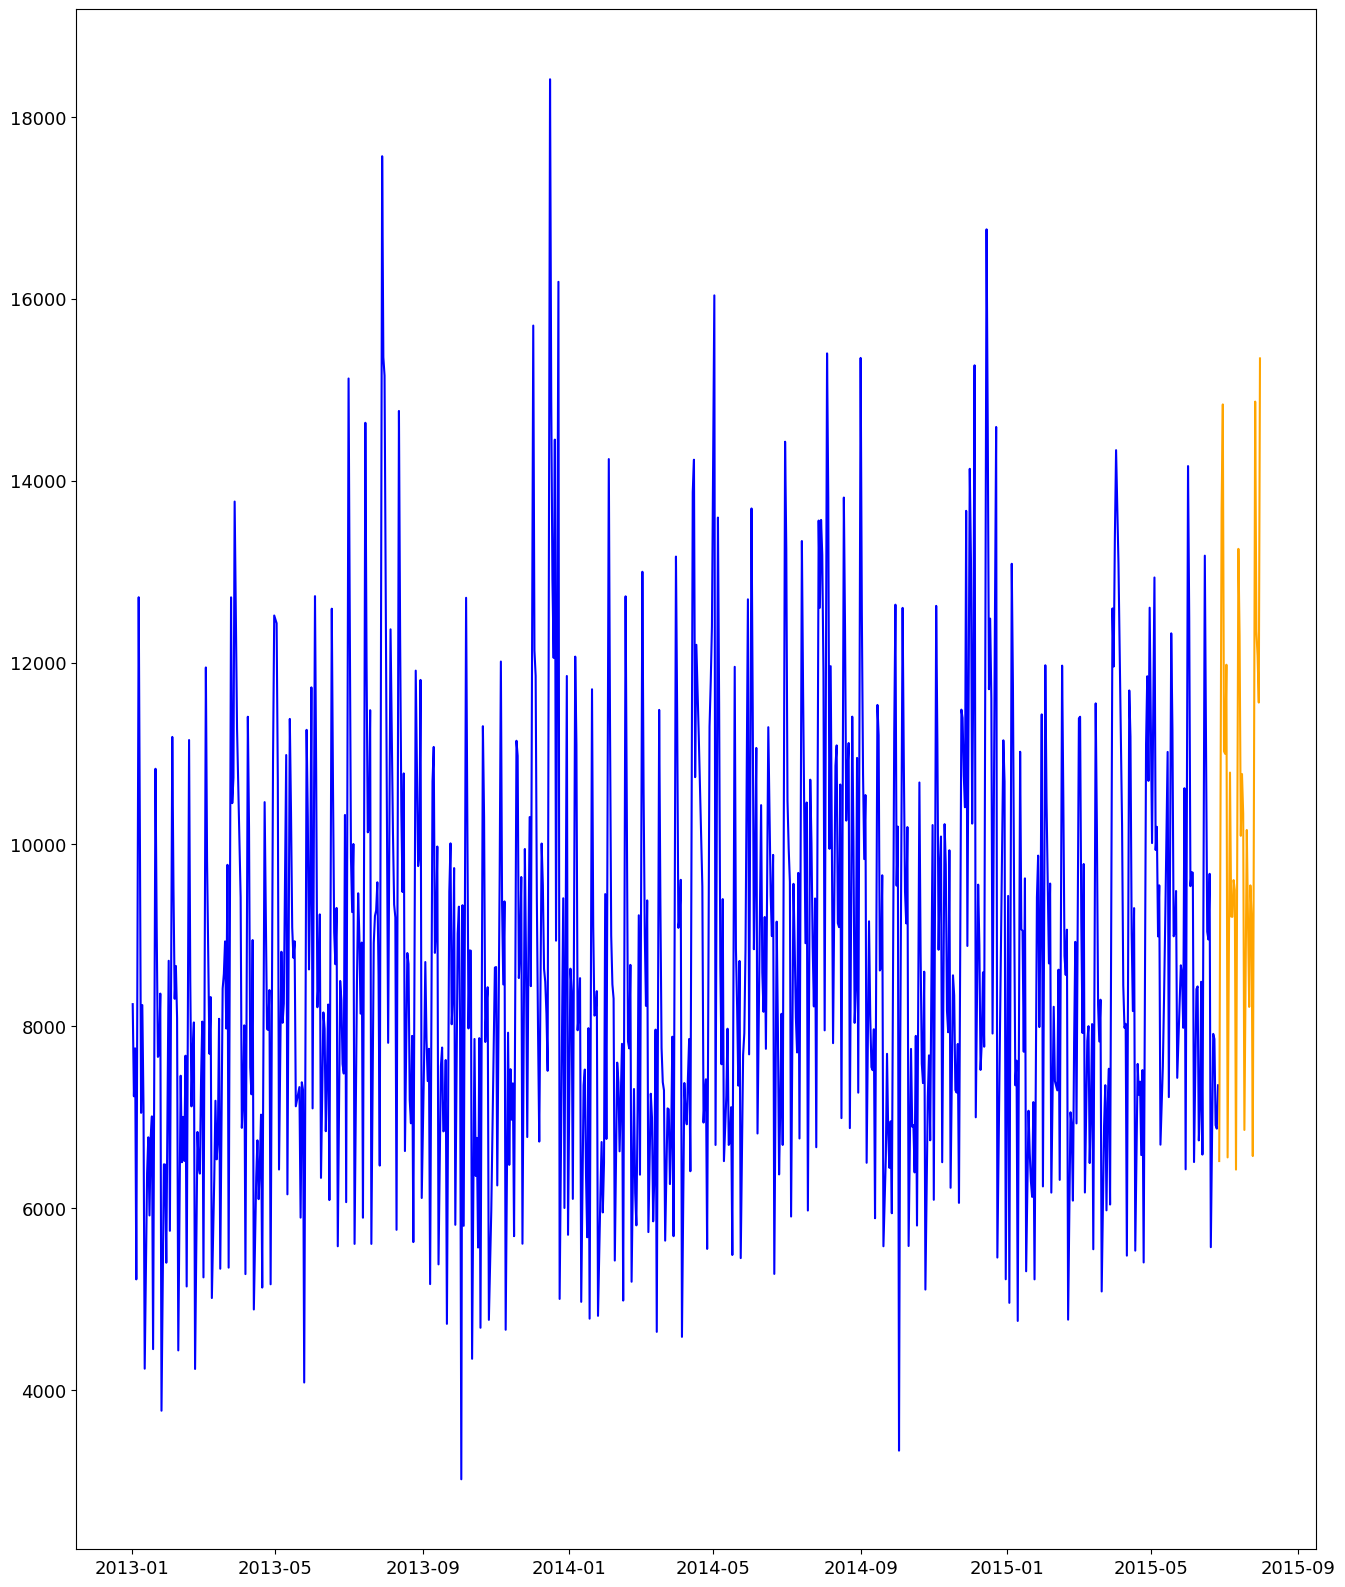

In [229]:
fig ,axes =plt.subplots(1,1)
axes.plot(train_data['Sales'], label='Train',color='blue')
axes.plot(valid_data['Sales'], label='Test',color='orange')
plt.show()

## Decompostion

In [230]:
def classical_decomposition(data,period_value=7,model_type="additive",plots=True):
    #We set extrapolate_trend to 'freq' which results in no NaN values in trend or resid components
    #Because smoothing using moving average method within the period value in case of two_sided=True
    #or at the begining only if we set two_sided=False
    result= seasonal_decompose(data,period=period_value, model=model_type,two_sided=False,
                                   extrapolate_trend='freq')
    
    trend = result.trend
    
    seasonal = result.seasonal
    residuals = result.resid
    
    if plots:
        resid_var = np.var(residuals.values)
        trend_resid_var = np.var(residuals.values+trend.values)
        seasonal_resid_var = np.var(residuals.values+seasonal.values)
        trend_strength = max(0,1-(resid_var/trend_resid_var))
        seasonal_strength = max(0,1-(resid_var/seasonal_resid_var))
        
        print(f"The strength of the trend is: {trend_strength} \n And the strength of Seasonality is: {seasonal_strength}")
        
        fig,axes = plt.subplots(4, 1, sharex=True, sharey=False)
        fig.set_figheight(10)
        fig.set_figwidth(15)

        axes[0].plot(data, label='Original')
        axes[0].legend(loc='upper left')

        axes[1].plot(trend, label='Trend')
        axes[1].legend(loc='upper left')

        axes[2].plot(seasonal, label='Seasonality')
        axes[2].legend(loc='upper left')

        axes[3].plot(residuals, label='Residuals')
        axes[3].legend(loc='upper left')
    
    return trend,seasonal,residuals


- Multiplicative won't work as our sales have zero values

The strength of the trend is: 0.05095197946525054 
 And the strength of Seasonality is: 0.4684525191951696


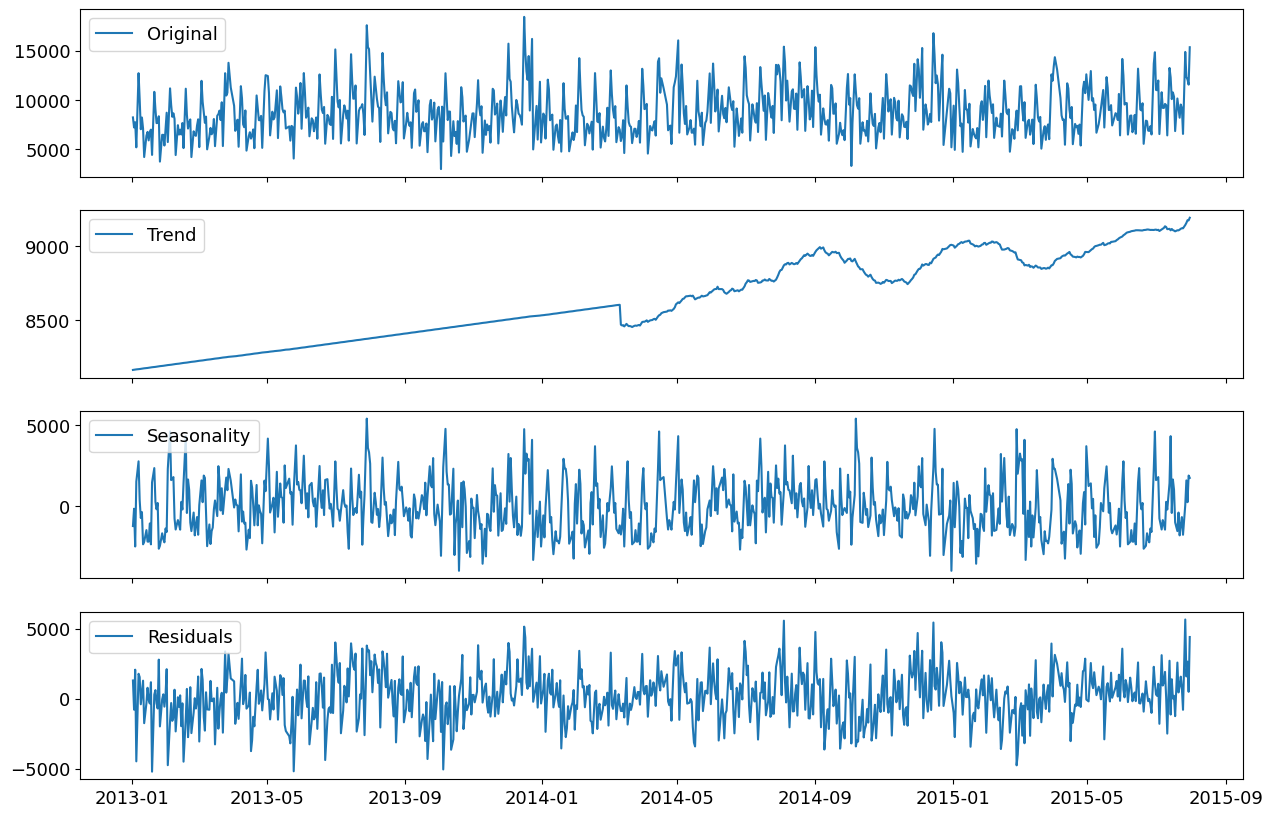

In [231]:
trend_add, seasonal_add, resid_add = classical_decomposition(df_7['Sales'],period_value=365,
                                                            model_type="additive",plots=True)

In [232]:
def STL_decomposition(data,n_p=7,robustness=True,n_t=14,n_L=9,s_d=0,t_d=0,lp_d=0,model_type="additive",plots=True):
    if model_type =="multiplicative":
        data_used = np.log(data)
    else:
        data_used = data
    stl = STL(data_used,robust = robustness,
              period=n_p,trend=n_t,low_pass=n_L,
              seasonal_deg=s_d,trend_deg=t_d,low_pass_deg=lp_d,
             )
    result = stl.fit()
    if model_type =="multiplicative":
        trend = np.exp(result.trend)
        seasonal = np.exp(result.seasonal)
        residuals = np.exp(result.resid)
    else:
        trend = result.trend
        seasonal = result.seasonal
        residuals = result.resid

    if plots:
        resid_var = np.var(residuals.values)
        trend_resid_var = np.var(residuals.values+trend.values)
        seasonal_resid_var = np.var(residuals.values+seasonal.values)
        trend_strength = max(0,1-(resid_var/trend_resid_var))
        seasonal_strength = max(0,1-(resid_var/seasonal_resid_var))
        
        print(f"The strength of the trend is: {trend_strength} \n And the strength of Seasonality is: {seasonal_strength}")
        
        fig,axes = plt.subplots(4, 1, sharex=True, sharey=False)
        fig.set_figheight(10)
        fig.set_figwidth(15)

        axes[0].plot(data, label='Original')
        axes[0].legend(loc='upper left')

        axes[1].plot(trend, label='Trend')
        axes[1].legend(loc='upper left')

        axes[2].plot(seasonal, label='Seasonality')
        axes[2].legend(loc='upper left')

        axes[3].plot(residuals, label='Residuals')
        axes[3].legend(loc='upper left')
    
    return trend,seasonal,residuals


The strength of the trend is: 0.9997268116022914 
 And the strength of Seasonality is: 0.9999944233685311


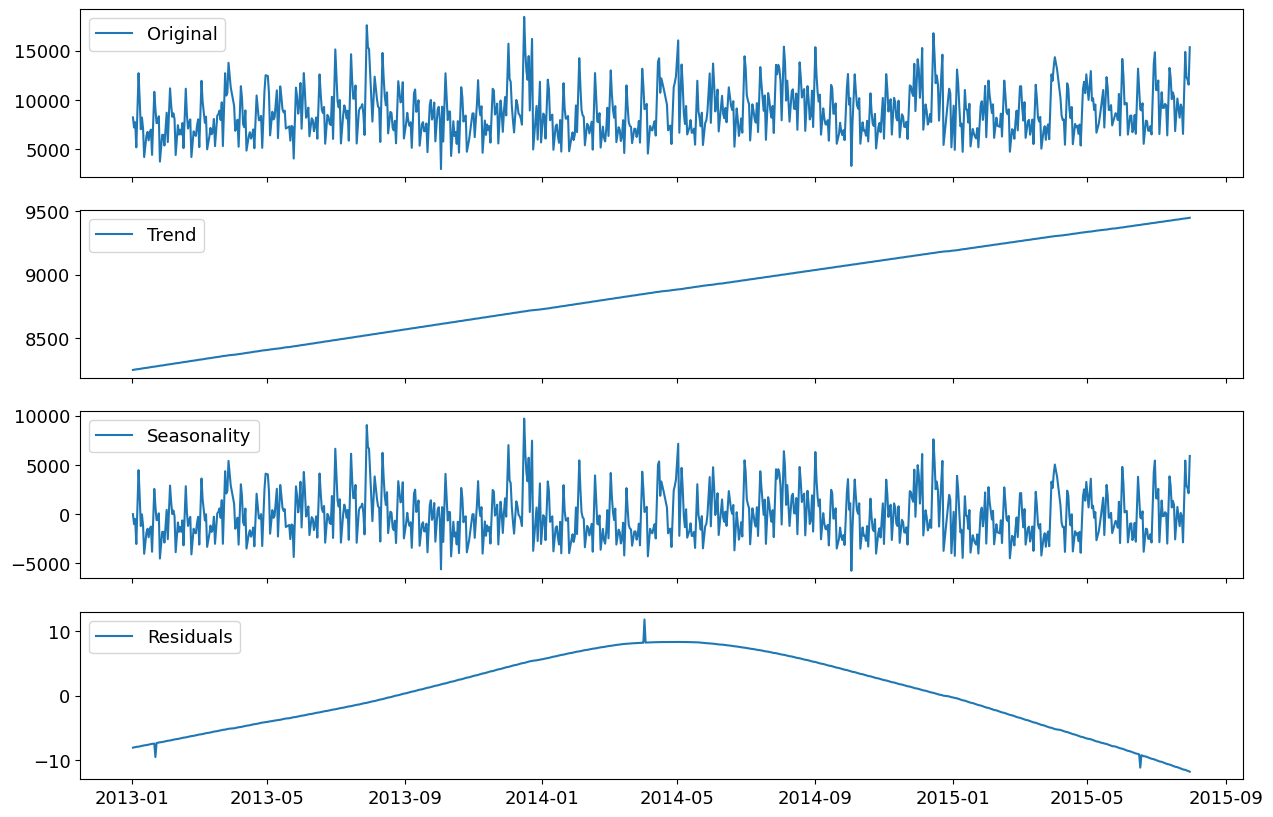

In [233]:
trend_stl,seasonal_stl,residuals_stl = STL_decomposition(df_7['Sales'],
                                                         n_p=365,robustness=True,n_t=(365*2)+1,n_L=367,
                                                         s_d=1,t_d=1,lp_d=1,model_type="additive",plots=True)


In [234]:
# check if res is stationary
def test_stationarity(timeseries):
    result = adfuller(timeseries.dropna(),regression='ctt')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    
    if result[1] <= 0.05:
        print("Result: The series is stationary")
    else:
        print("Result: The series is non-stationary")

print("Stationarity Test for Original Series:")
test_stationarity(residuals_stl)

Stationarity Test for Original Series:
ADF Statistic: -1.803830
p-value: 0.881635
Critical Values:
	1%: -4.386
	5%: -3.840
	10%: -3.558
Result: The series is non-stationary


### Insights:
- Trend is linear and week slightly increasing from 8200 to 9250.
- We don’t need complex trend modeling (like MSTL or high-order polynomial fitting)
- Holt’s Linear Trend or Drift method might work reasonably well.
- seasonality is stable, this is ideal for seasonal models (Seasonal Naive, SARIMA, Prophet, or ETS with seasonality)
- This is ideal for seasonal models (Seasonal Naive, SARIMA, Prophet, or ETS with seasonality), easonality period of 7 is justified.
- Residuals are stationary (white noise).

In [235]:
mstl = MSTL(df_7["Sales"], periods=(7, 14,30,90), stl_kwargs={"seasonal_deg": 1})
res = mstl.fit()

In [236]:
print(type(res.resid))

<class 'pandas.core.series.Series'>


In [237]:
# check if res is stationary
def test_stationarity(timeseries):
    result = adfuller(timeseries.dropna(),regression='n')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    
    if result[1] <= 0.05:
        print("Result: The series is stationary")
    else:
        print("Result: The series is non-stationary")

print("Stationarity Test for Original Series:")
test_stationarity(res.resid)

Stationarity Test for Original Series:
ADF Statistic: -5.770525
p-value: 0.000000
Critical Values:
	1%: -2.569
	5%: -1.941
	10%: -1.616
Result: The series is stationary


C:\Users\USER\AppData\Local\Temp\ipykernel_2620\2060783969.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


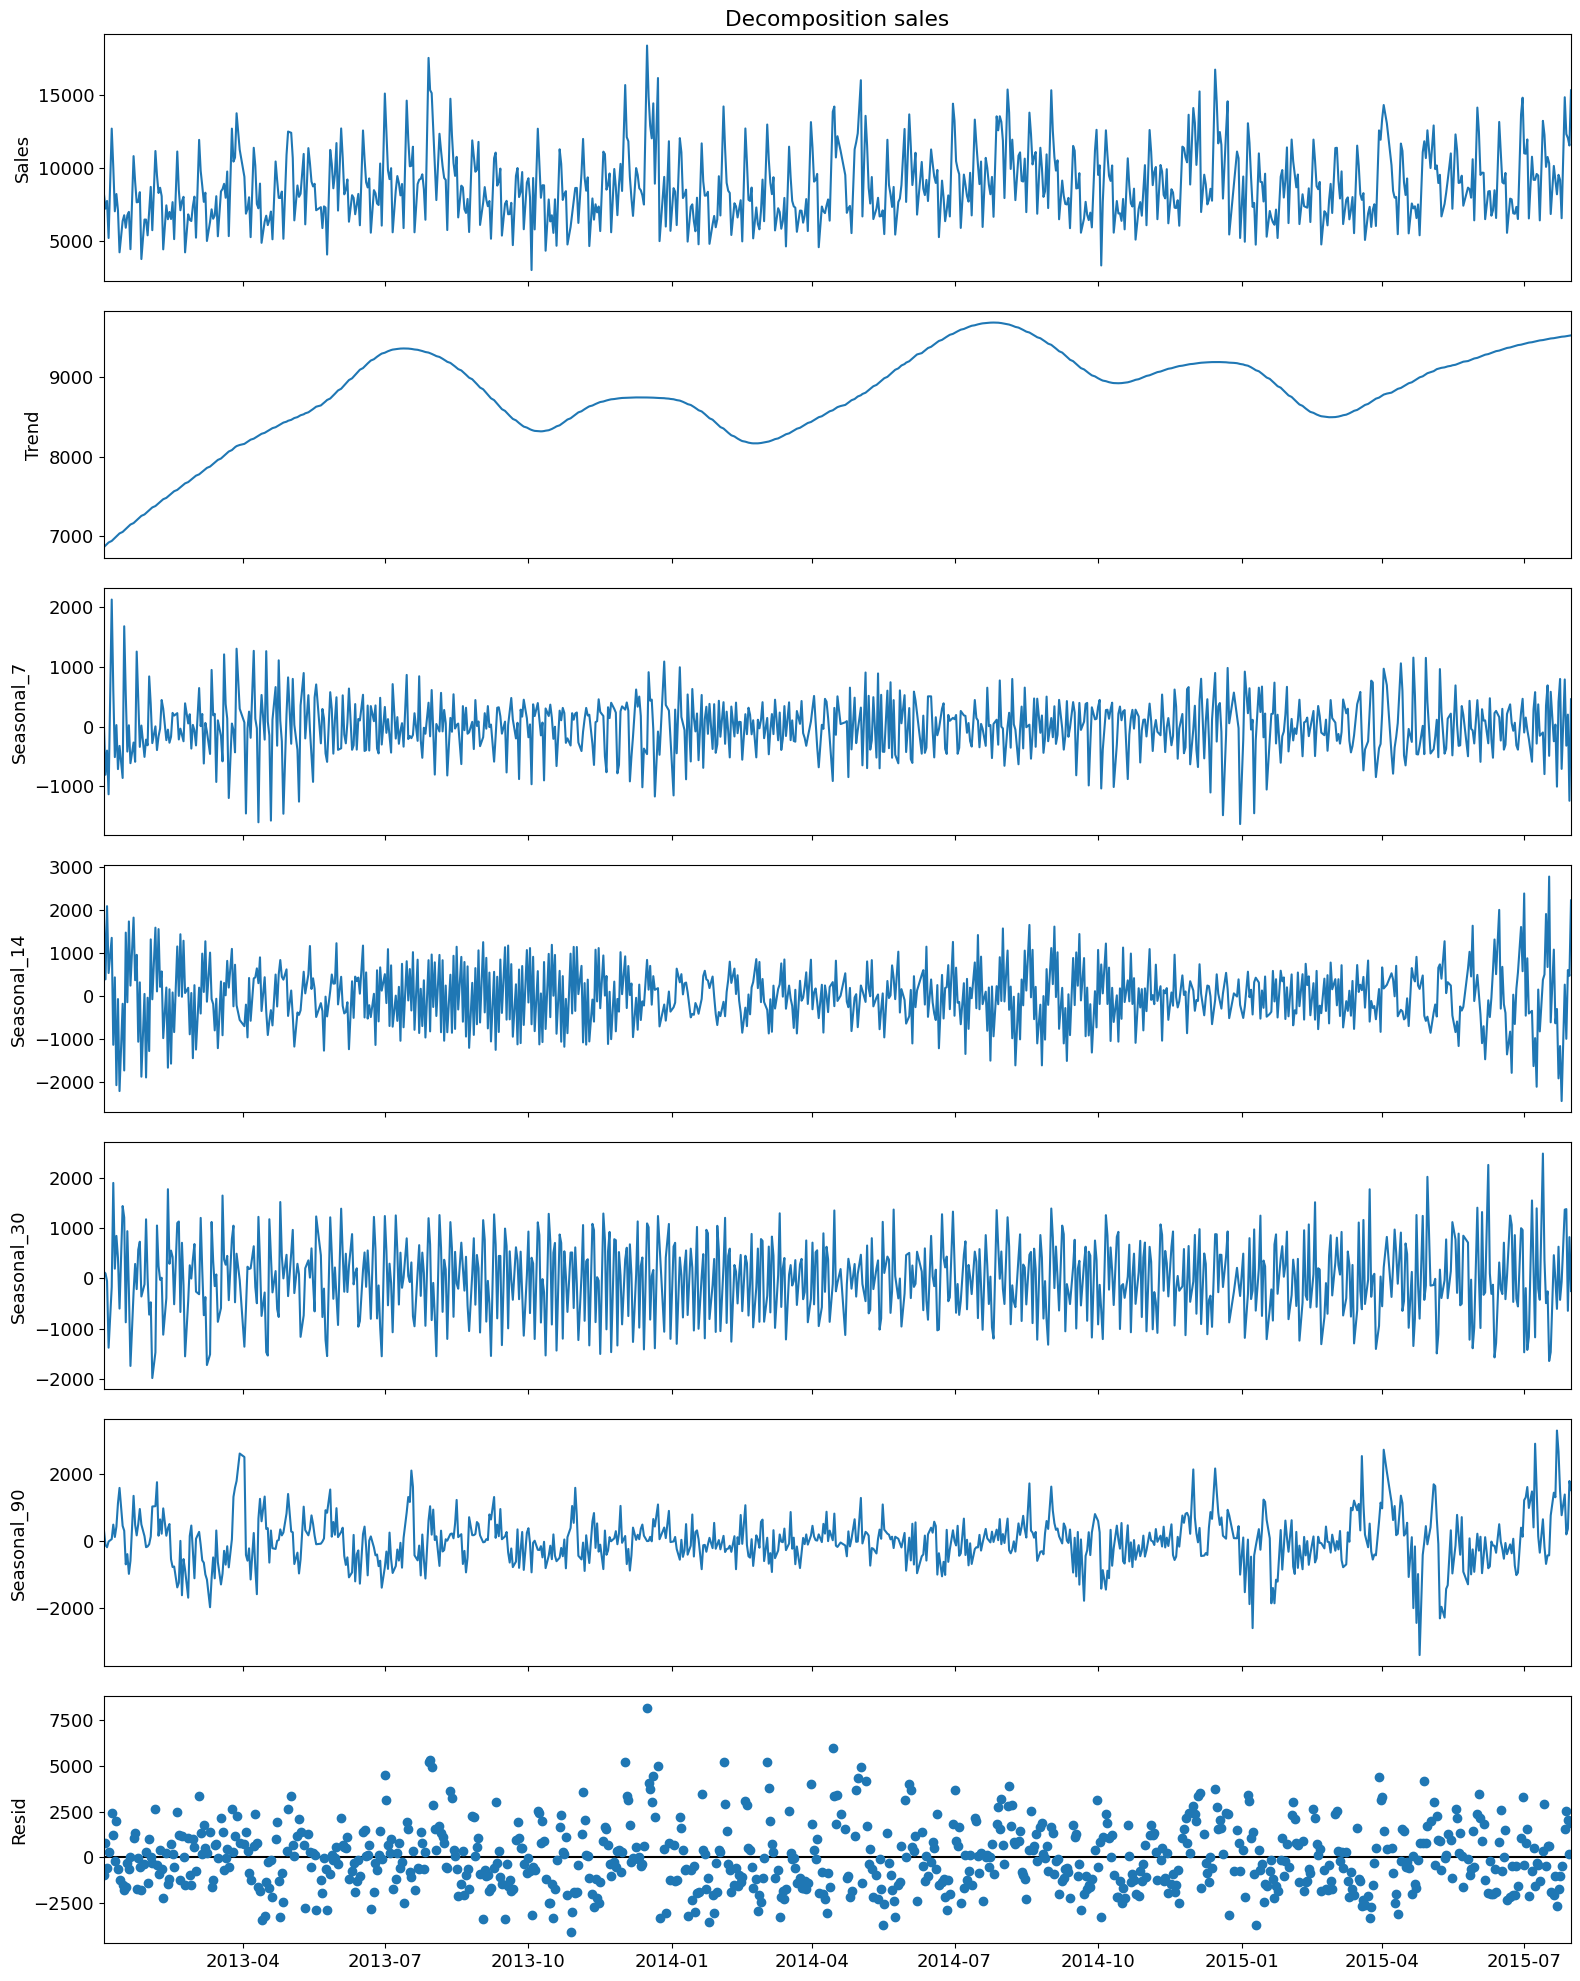

In [238]:
# Start with the plot from the results object `res`
plt.rc("figure", figsize=(16, 20))
plt.rc("font", size=13)
fig = res.plot()

# Make plot pretty
axs = fig.get_axes()

axs[0].set_ylabel("Sales")
axs[0].set_title("Decomposition sales")

plt.tight_layout()

### insights for MSTL:
- the trend:

    - Rises gradually through 2013,

    - Stagnates and dips in 2014,

    - Rises again in 2015.

- Weekly Seasonality 7-day:
  - Strong weekly pattern with varying amplitude over time.
- Bi-weekly Seasonality 14-day:
  - Biweekly cycles likely from business processes 
- Monthly 30-day:
  - less stable, important due to monthly planing and payroll
- Residuals
  - Random-like scatter, no strong periodicity left: Decomposition quality is very high here — almost all seasonality and trend removed cleanly

# 2. Simple Forecasting

In [239]:
df_7

Store  DayOfWeek  Sales  Customers  Open  Promo  StateHoliday  \
Date                                                                        
2013-01-02      7          3   8244        955     1      0             0   
2013-01-03      7          4   7231        867     1      0             0   
2013-01-04      7          5   7758        870     1      0             0   
2013-01-05      7          6   5218        575     1      0             0   
2013-01-07      7          1  12718       1150     1      1             0   
...           ...        ...    ...        ...   ...    ...           ...   
2015-07-27      7          1  14869       1340     1      1             0   
2015-07-28      7          2  12342       1158     1      1             0   
2015-07-29      7          3  12074       1166     1      1             0   
2015-07-30      7          4  11560       1116     1      1             0   
2015-07-31      7          5  15344       1414     1      1             0   

            SchoolHoliday  StoreType  Assortment  ...  \
Date                                              ...   
2013-01-02              1          1           3  ...   
2013-01-03              1          1           3  ...   
2013-01-04              1          1           3  ...   
2013-01-05              0          1           3  ...   
2013-01-07              0          1           3  ...   
...                   ...        ...         ...  ...   
2015-07-27              1          1           3  ...   
2015-07-28              1          1           3  ...   
2015-07-29              1          1           3  ...   
2015-07-30              1          1           3  ...   
2015-07-31              1          1           3  ...   

            CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  \
Date                                                            
2013-01-02                    2013.0       0              NaN   
2013-01-03                    2013.0       0              NaN   
2013-01-04                    2013.0       0              NaN   
2013-01-05                    2013.0       0              NaN   
2013-01-07                    2013.0       0              NaN   
...                              ...     ...              ...   
2015-07-27                    2013.0       0              NaN   
2015-07-28                    2013.0       0              NaN   
2015-07-29                    2013.0       0              NaN   
2015-07-30                    2013.0       0              NaN   
2015-07-31                    2013.0       0              NaN   

            Promo2SinceYear  Year  Month  Day  WeekOfYear  SalePerCustomer  \
Date                                                                         
2013-01-02              NaN  2013      1    2           1         8.632461   
2013-01-03              NaN  2013      1    3           1         8.340254   
2013-01-04              NaN  2013      1    4           1         8.917241   
2013-01-05              NaN  2013      1    5           1         9.074783   
2013-01-07              NaN  2013      1    7           2        11.059130   
...                     ...   ...    ...  ...         ...              ...   
2015-07-27              NaN  2015      7   27          31        11.096269   
2015-07-28              NaN  2015      7   28          31        10.658031   
2015-07-29              NaN  2015      7   29          31        10.355060   
2015-07-30              NaN  2015      7   30          31        10.358423   
2015-07-31              NaN  2015      7   31          31        10.851485   

            missing  
Date                 
2013-01-02    False  
2013-01-03    False  
2013-01-04    False  
2013-01-05    False  
2013-01-07    False  
...             ...  
2015-07-27    False  
2015-07-28    False  
2015-07-29    False  
2015-07-30    False  
2015-07-31    False  

[786 rows x 22 columns]

In [240]:
# take the last 30 days from store 7 as validation data
validation_days = 30
train_data = df_7.iloc[:-validation_days]
valid_data = df_7.iloc[-validation_days:]
y_true = valid_data['Sales'].values # to calculate RMPS


## Naive Method
The forecast for a time t is simply the observed value at time t-1.

last known value → next forecast

In [241]:
def naive_forecast(train_series, test_series):
    """
    Naive forecast: uses the last observation to predict the next.
    
    Parameters:
    - train_series: pd.Series of training data (with datetime index)
    - test_series: pd.Series of validation/test data (with datetime index)
    
    Returns:
    - pd.Series of forecasts aligned with test_series index
    """
    # grab the last value from training and combine it with test data (excluding last)
    combined = np.append(train_series.iloc[-1], test_series.iloc[:-1].values)

    # shift by 1 to make it a forecast
    forecast_values = np.roll(combined, 1)

    # return as Series aligned to test_series index
    return pd.Series(forecast_values, index=test_series.index, name="NaiveForecast")


In [242]:
naiive_pred = naive_forecast(train_data['Sales'],valid_data['Sales'])


In [243]:
Naive_metrics = evaluate_model(y_true, naiive_pred, "Naive Method")

Naive Method Results:
MSE: 12610245.07
RMSE: 3551.09
MAE: 2880.13
RMSPE: 0.3512
****************************************


## Moving Average
uses a window of previous n observations to forecast


In [244]:
def moving_average_forecast(train_series, test_series, window):
    """
    Moving Average forecast with a fixed rolling window.
    
    Parameters:
    - train_series: pd.Series of training Sales data
    - test_series: pd.Series of test/validation Sales data
    - window: int, window size for moving average
    
    Returns:
    - pd.Series of forecasts aligned with test_series index
    """
    # min_periods=1 ensures that the average is still computed even for the first few rows (with fewer than window values).
    train_ma = train_series.rolling(window=window, min_periods=1).mean() 
    last_ma = train_ma.iloc[-1]
    
    # Initialize forecast list
    forecast = [last_ma]

    # Simulate forecasting by using only already predicted values
    history = list(train_series.values)
    
    for i in range(1, len(test_series)):
        recent_data = history[-window:]  # last 'window' values
        forecast.append(np.mean(recent_data))
        history.append(test_series.iloc[i-1])  # append true value from test for next step

    return pd.Series(forecast, index=test_series.index, name=f"MA_{window}")


In [245]:
moving_average_pred_7 = moving_average_forecast(train_data['Sales'],valid_data['Sales'],window=7)
moving_average_pred_14 = moving_average_forecast(train_data['Sales'],valid_data['Sales'],window=14)

In [246]:
MA_7_metrics = evaluate_model(y_true, moving_average_pred_7, "Moving_Average_7 Method")
MA_14_metrics = evaluate_model(y_true, moving_average_pred_14, "Moving_Average_14 Method")

Moving_Average_7 Method Results:
MSE: 9501375.67
RMSE: 3082.43
MAE: 2399.16
RMSPE: 0.2835
****************************************
Moving_Average_14 Method Results:
MSE: 7336815.20
RMSE: 2708.66
MAE: 2014.43
RMSPE: 0.2522
****************************************


### Seasonal Naive 
uses the value from the same day a season ago as the forecast
the decompostion and correlation showed a strong weekly and bi-weekly season so we will be using that


In [247]:
import pandas as pd

def seasonal_naive_forecast(train_data, valid_data, seasonal_period=7):
    """
    Seasonal naive forecast using past sales from the same seasonal period.
    
    Args:
        train_data (pd.Series): series with datetime index , 'Sales' values .
        valid_data (pd.Series): series with datetime index and (optional) 'Sales' values.
        seasonal_period (int): Seasonal lag in days (e.g., 7 for weekly).
        
    Returns:
        List of predicted sales for each date in valid_data.
    """
    y_pred = []
    train_sales_lookup = train_data.to_dict()
    valid_sales_lookup = {}  # Store predictions as we go for reuse

    for date in valid_data.index:
        previous_date = date - pd.Timedelta(days=seasonal_period)

        if previous_date in train_sales_lookup:
            pred = train_sales_lookup[previous_date]
        elif previous_date in valid_sales_lookup:
            pred = valid_sales_lookup[previous_date]
        else:
            # Fallback: use average sales of the same weekday in training data
            weekday = date.weekday()
            same_weekday_sales = train_data[train_data.index.weekday == weekday]
            pred = same_weekday_sales.mean()

        y_pred.append(pred)
        valid_sales_lookup[date] = pred  # Cache prediction

    #return y_pred
    return pd.Series(y_pred, index=valid_data.index, name=f"Seasonal_Naive_pred_{seasonal_period}")




In [248]:
seasonal_naive_7_pred = seasonal_naive_forecast(train_data['Sales'],valid_data['Sales'],seasonal_period=7)
seasonal_naive_14_pred = seasonal_naive_forecast(train_data['Sales'],valid_data['Sales'],seasonal_period=14)



In [249]:
Seasonal_naive_7_metrics = evaluate_model(y_true, seasonal_naive_7_pred, "Seasonal_naive_7 Method")
Seasonal_naive_14_metrics = evaluate_model(y_true, seasonal_naive_14_pred, "Seasonal_naive_14 Method")

Seasonal_naive_7 Method Results:
MSE: 15071232.97
RMSE: 3882.17
MAE: 3351.83
RMSPE: 0.3173
****************************************
Seasonal_naive_14 Method Results:
MSE: 4495771.40
RMSE: 2120.32
MAE: 1758.73
RMSPE: 0.1870
****************************************


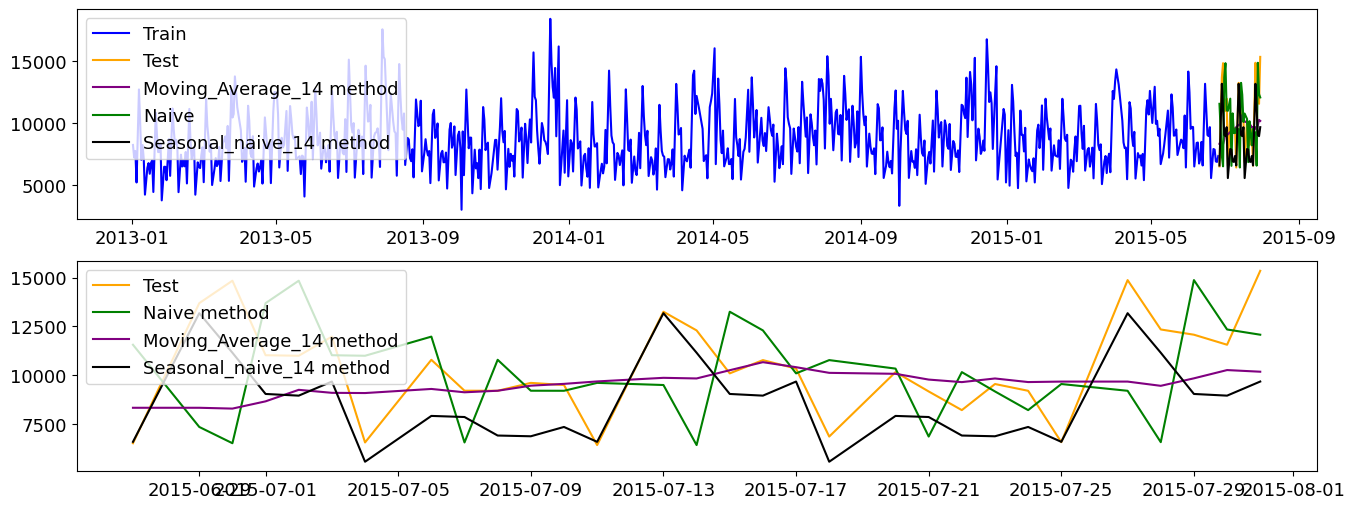

In [250]:
fig ,axes =plt.subplots(2,1)
fig.set_figheight(6)
fig.set_figwidth(16)

axes[0].plot(train_data['Sales'], label='Train',color='blue')
axes[0].plot(valid_data['Sales'], label='Test',color='orange')

#axes[0].plot(moving_average_pred_7,label="Moving_Average_7 method",color='red')
axes[0].plot(moving_average_pred_14,label="Moving_Average_14 method",color='purple')
axes[0].plot(naiive_pred, label='Naive',color='green')
axes[0].plot(seasonal_naive_14_pred,label="Seasonal_naive_14 method",color='black')

axes[0].legend(loc='best')

axes[1].plot(valid_data['Sales'], label='Test',color='orange')
#axes[1].plot(moving_average_pred_7,label="Moving_Average_7 method",color='red')
axes[1].plot(naiive_pred,label="Naive method",color='green')
axes[1].plot(moving_average_pred_14,label="Moving_Average_14 method",color='purple')
axes[1].plot(seasonal_naive_14_pred,label="Seasonal_naive_14 method",color='black')

#axes[1].plot(drift_pred,label='Drift',color='orchid')
axes[1].legend(loc='best')
plt.show()

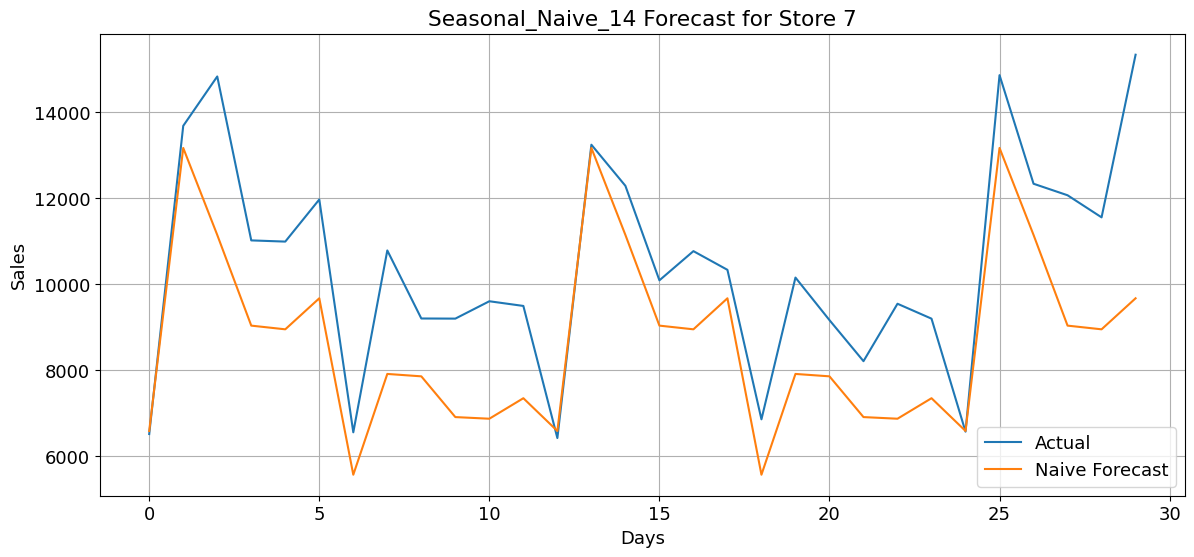

In [251]:
plt.figure(figsize=(14, 6))
plt.plot(range(len(y_true)), y_true, label='Actual')
plt.plot(range(len(seasonal_naive_14_pred)), seasonal_naive_14_pred, label='Naive Forecast')
plt.title(f'Seasonal_Naive_14 Forecast for Store {7}')
plt.xlabel('Days')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

## Weighted Moving Average

In [252]:
def weighted_moving_average_forecast(train_data,test_data,window: int,weights = None):
    """
    Perform weighted moving average forecast.

    Args:
        train_data (pd.Series): Series with datetime index and sales values.
        test_data (pd.Series): Series with datetime index (values ignored, used for length).
        window (int): Size of the window (7, 14, etc.).
        weights (np.ndarray): Custom weights of size == window. If None, use equal weights.

    Returns:
        pd.Series: Forecasted values with same index as test_data.
    """
    if weights is None:
        weights = np.ones(window) / window  # Equal weights by default
    else:
        weights = np.asarray(weights)
        if len(weights) != window:
            raise ValueError(f"Length of weights must be equal to the window size ({window})")
        weights = weights / weights.sum()  # Normalize

    last_values = train_data.iloc[-window:].values.copy()
    y_pred = []

    for i in range(len(test_data)):
        forecast = np.dot(last_values, weights)
        y_pred.append(forecast)

        # Update rolling window
        last_values = np.roll(last_values, -1)
        if i < len(test_data) - 1:
            last_values[-1] = test_data.iloc[i]  # Replace with real sales for one-step-ahead

    return pd.Series(y_pred, index=test_data.index)


In [253]:
weights_7 = np.array([0.05, 0.05, 0.1, 0.1, 0.2, 0.2, 0.3])
weights_14 = np.array([
    0.01, 0.01, 0.02, 0.02,
    0.04, 0.05, 0.07, 0.08,
    0.10, 0.12, 0.13, 0.14,
    0.10, 0.11
])


In [254]:
W_moving_average_pred_7 = weighted_moving_average_forecast(train_data['Sales'],valid_data['Sales'],window=7,weights=weights_7)
W_moving_average_pred_14 = weighted_moving_average_forecast(train_data['Sales'],valid_data['Sales'],window=14,weights=weights_14)

In [255]:
WMA_7_metrics = evaluate_model(y_true, W_moving_average_pred_7, "WMA_7 Method")
WMA_14_metrics = evaluate_model(y_true, W_moving_average_pred_14, "WMA_14 Method")

WMA_7 Method Results:
MSE: 7760134.96
RMSE: 2785.70
MAE: 1880.17
RMSPE: 0.2710
****************************************
WMA_14 Method Results:
MSE: 7985652.83
RMSE: 2825.89
MAE: 2147.69
RMSPE: 0.2676
****************************************


## Exponentially Weighted Moving Average (EWMA): 
also known as Simple Exponential Smoothing/ simple ETS

gives more weight to recent observations, which makes it more responsive to recent changes in the data compared to a simple moving average.

In [256]:
def exponential_weighted_moving_average(train_data, valid_data, alpha = 0.3):
    """
    Forecast using Exponentially Weighted Moving Average (EWMA).
    
    Args:
        train_data (pd.Series): Training sales data (index: Date, values: Sales).
        valid_data (pd.Series): Validation sales data (index: Date, values: Sales).
        alpha (float): Smoothing factor (0 < alpha <= 1).
        
    Returns:
        pd.Series: Forecasted values for the validation period.
    """
    y_pred_ewma = []
    
    # Initialize with last known value from training
    prev_ewma = train_data.iloc[-1]

    for i in range(len(valid_data)):
        forecast = prev_ewma
        y_pred_ewma.append(forecast)

        # Update EWMA with actual value after prediction
        prev_ewma = alpha * valid_data.iloc[i] + (1 - alpha) * prev_ewma

    return pd.Series(y_pred_ewma, index=valid_data.index)


In [257]:
EWMA_pred_01 = exponential_weighted_moving_average(train_data['Sales'],valid_data['Sales'],alpha=0.1)
EWMA_pred_008 = exponential_weighted_moving_average(train_data['Sales'],valid_data['Sales'],alpha=0.08)


In [258]:
EWMA_01_metrics = evaluate_model(y_true, EWMA_pred_01, "EWMA_01 Method")
EWMA_008_metrics = evaluate_model(y_true, EWMA_pred_008, "EWMA_008 Method")


EWMA_01 Method Results:
MSE: 8212336.18
RMSE: 2865.72
MAE: 2138.99
RMSPE: 0.2545
****************************************
EWMA_008 Method Results:
MSE: 8526909.30
RMSE: 2920.09
MAE: 2228.71
RMSPE: 0.2538
****************************************


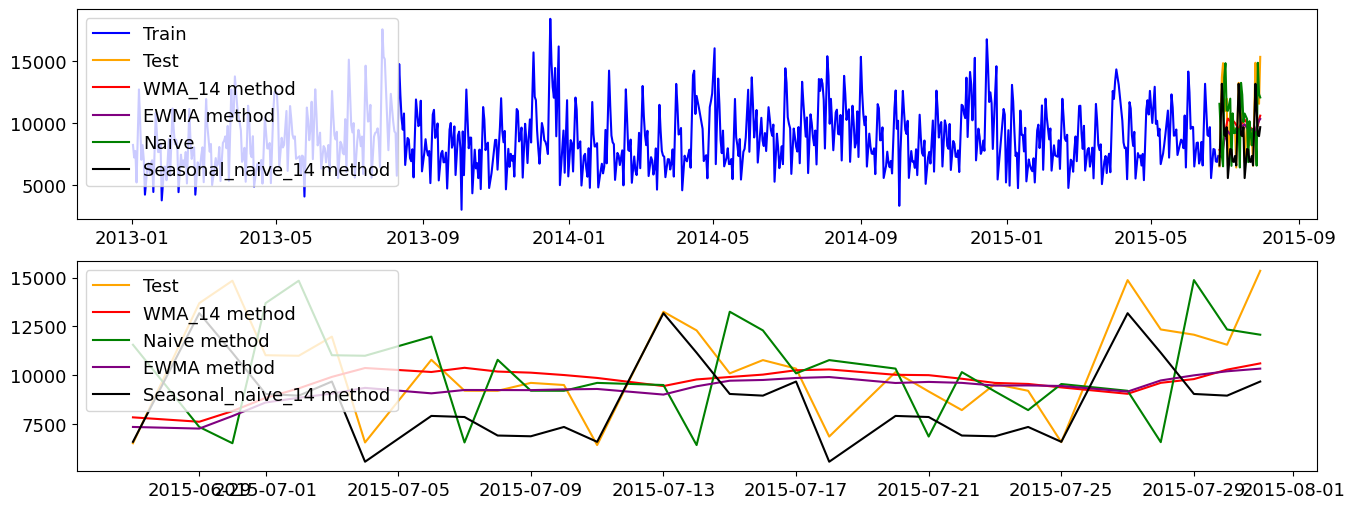

In [259]:
fig ,axes =plt.subplots(2,1)
fig.set_figheight(6)
fig.set_figwidth(16)

axes[0].plot(train_data['Sales'], label='Train',color='blue')
axes[0].plot(valid_data['Sales'], label='Test',color='orange')

axes[0].plot(W_moving_average_pred_14,label="WMA_14 method",color='red')
axes[0].plot(EWMA_pred_01,label="EWMA method",color='purple')
axes[0].plot(naiive_pred, label='Naive',color='green')
axes[0].plot(seasonal_naive_14_pred,label="Seasonal_naive_14 method",color='black')

axes[0].legend(loc='best')

axes[1].plot(valid_data['Sales'], label='Test',color='orange')
axes[1].plot(W_moving_average_pred_14,label="WMA_14 method",color='red')
axes[1].plot(naiive_pred,label="Naive method",color='green')
axes[1].plot(EWMA_pred_01,label="EWMA method",color='purple')
axes[1].plot(seasonal_naive_14_pred,label="Seasonal_naive_14 method",color='black')

#axes[1].plot(drift_pred,label='Drift',color='orchid')
axes[1].legend(loc='best')
plt.show()

In [260]:
def metric_df(list_metrics, sort_by='RMSPE'):
    df = pd.DataFrame(list_metrics, columns=['Model', 'MSE', 'RMSE', 'MAE', 'RMSPE'])
    return df.sort_values(by=sort_by)

In [261]:
list_metrics = [Naive_metrics, MA_7_metrics,MA_14_metrics,WMA_7_metrics,WMA_14_metrics,EWMA_008_metrics,EWMA_01_metrics,Seasonal_naive_7_metrics,Seasonal_naive_14_metrics]
df_simple_re = metric_df(list_metrics)
df_simple_re

Model           MSE         RMSE          MAE     RMSPE
8  Seasonal_naive_14 Method  4.495771e+06  2120.323419  1758.733333  0.187045
2  Moving_Average_14 Method  7.336815e+06  2708.655608  2014.433333  0.252173
5           EWMA_008 Method  8.526909e+06  2920.087207  2228.706447  0.253813
6            EWMA_01 Method  8.212336e+06  2865.717394  2138.986018  0.254528
4             WMA_14 Method  7.985653e+06  2825.889740  2147.693333  0.267557
3              WMA_7 Method  7.760135e+06  2785.701880  1880.170000  0.270966
1   Moving_Average_7 Method  9.501376e+06  3082.430157  2399.161905  0.283462
7   Seasonal_naive_7 Method  1.507123e+07  3882.168591  3351.833333  0.317340
0              Naive Method  1.261025e+07  3551.090687  2880.133333  0.351195

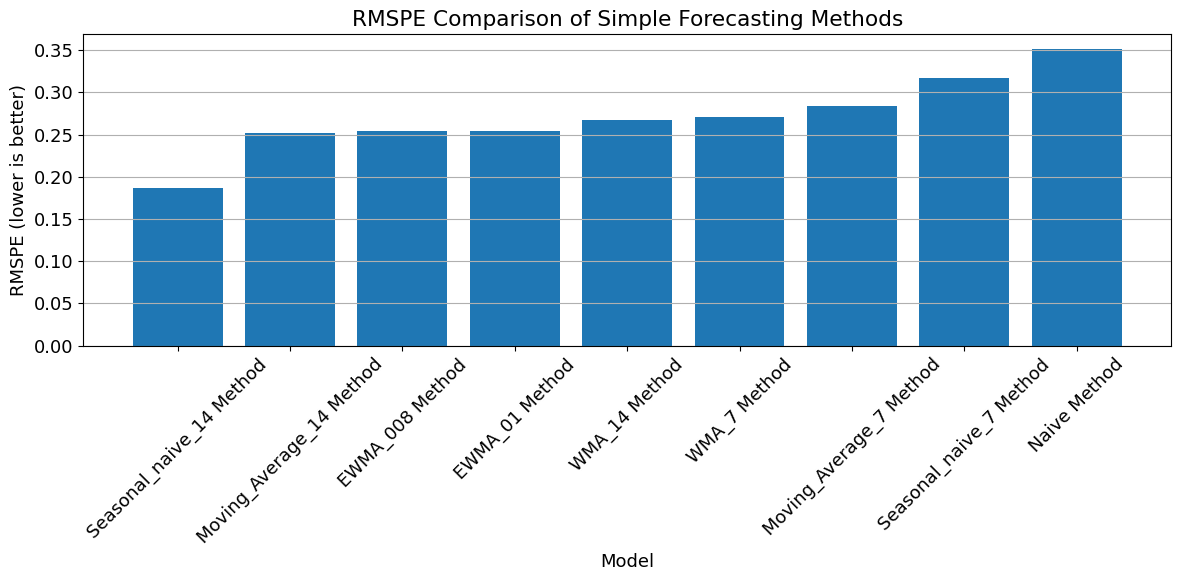

In [262]:
plt.figure(figsize=(12, 6))
plt.bar(df_simple_re['Model'], df_simple_re['RMSPE'])
plt.title('RMSPE Comparison of Simple Forecasting Methods')
plt.xlabel('Model')
plt.ylabel('RMSPE (lower is better)')
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# 3. ETL Modles

- Simple Exponential Smoothing (SES) - handles level only
- Holt's Linear Method - handles level and trend
- Holt-Winters Method - handles level, trend, and seasonality
- 
The perfect one for our data is Holt-Winters additive Method 

In [263]:
seasonal_periods = 7 

hw_add_model = ExponentialSmoothing(
    train_data['Sales'], 
    trend='add', 
    seasonal='add', 
    seasonal_periods=seasonal_periods
).fit(optimized=True)
hw_add_forecast = hw_add_model.forecast(steps=len(valid_data))

c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result 

In [264]:
HW7_metrics = evaluate_model(y_true, hw_add_forecast.values, "Holt Winter 7 Smoothing")

Holt Winter 7 Smoothing Results:
MSE: 16109699.53
RMSE: 4013.69
MAE: 3382.96
RMSPE: 0.3223
****************************************


In [265]:
seasonal_periods = 14

hw_add_model = ExponentialSmoothing(
    train_data['Sales'], 
    trend='add', 
    seasonal='add', 
    seasonal_periods=seasonal_periods
).fit(optimized=True)
hw_add_forecast_14 = hw_add_model.forecast(steps=len(valid_data))

c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result 

In [266]:
HW14_metrics = evaluate_model(y_true, hw_add_forecast_14.values, "Holt Winter 14 Smoothing")

Holt Winter 14 Smoothing Results:
MSE: 12667440.02
RMSE: 3559.13
MAE: 2971.54
RMSPE: 0.2866
****************************************


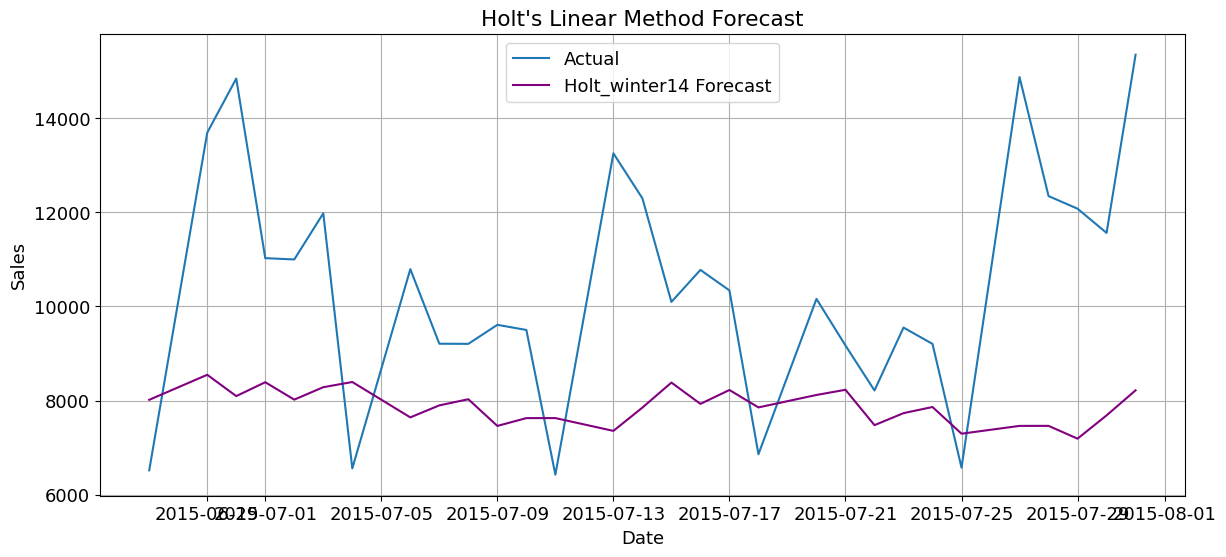

In [267]:
plt.figure(figsize=(14, 6))
plt.plot(valid_data.index, valid_data['Sales'].values, label='Actual')
plt.plot(valid_data.index, hw_add_forecast_14.values, label='Holt_winter14 Forecast',color='purple')
#plt.plot(valid_data.index, hw_add_forecast.values, label='Holt_winter7 Forecast',color='green')
plt.title('Holt\'s Linear Method Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

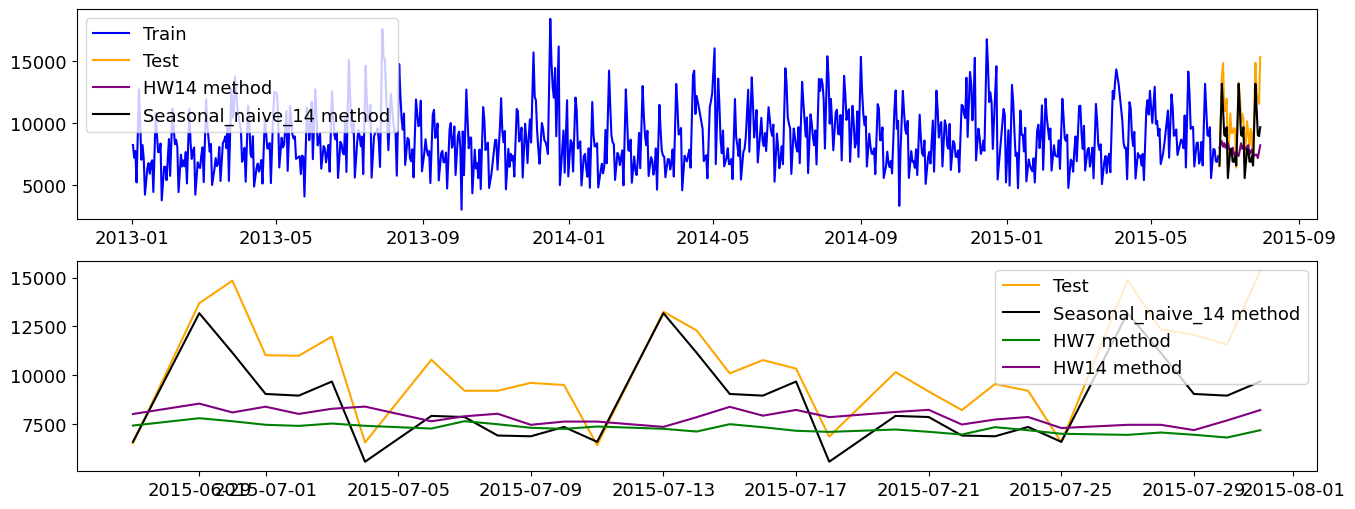

In [268]:
fig ,axes =plt.subplots(2,1)
fig.set_figheight(6)
fig.set_figwidth(16)

axes[0].plot(train_data['Sales'], label='Train',color='blue')
axes[0].plot(valid_data['Sales'], label='Test',color='orange')
axes[0].plot(valid_data.index,hw_add_forecast_14.values,label="HW14 method",color='purple')
#axes[0].plot(valid_data.index, hw_add_forecast.values, label='Holt_winter7 Forecast',color='green')
axes[0].plot(seasonal_naive_14_pred,label="Seasonal_naive_14 method",color='black')

axes[0].legend(loc='best')

axes[1].plot(valid_data['Sales'], label='Test',color='orange')
axes[1].plot(seasonal_naive_14_pred,label="Seasonal_naive_14 method",color='black')
axes[1].plot(valid_data.index,hw_add_forecast.values,label="HW7 method",color='green')
axes[1].plot(valid_data.index,hw_add_forecast_14.values,label="HW14 method",color='purple')

#axes[1].plot(drift_pred,label='Drift',color='orchid')
axes[1].legend(loc='best')
plt.show()

In [269]:
list_metrics = [EWMA_008_metrics,EWMA_01_metrics,Seasonal_naive_7_metrics,Seasonal_naive_14_metrics,HW14_metrics,HW7_metrics]
df_simple_ETS_re = metric_df(list_metrics)
df_simple_ETS_re

Model           MSE         RMSE          MAE     RMSPE
3  Seasonal_naive_14 Method  4.495771e+06  2120.323419  1758.733333  0.187045
0           EWMA_008 Method  8.526909e+06  2920.087207  2228.706447  0.253813
1            EWMA_01 Method  8.212336e+06  2865.717394  2138.986018  0.254528
4  Holt Winter 14 Smoothing  1.266744e+07  3559.134729  2971.535729  0.286577
2   Seasonal_naive_7 Method  1.507123e+07  3882.168591  3351.833333  0.317340
5   Holt Winter 7 Smoothing  1.610970e+07  4013.689018  3382.962939  0.322339

# 4. Arima Models

Our data has seasonality, so we will be using SARIMA

## how to choose SARIMA Parameters:

Step 1: Make data stationary
- Use ADF test to check.

Apply differencing if needed.

Step 2: Use ACF/PACF plots
- Helps estimate p, q, P, Q.



In [270]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [271]:
def test_stationarity(timeseries):
    result = adfuller(timeseries.dropna())
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    
    if result[1] <= 0.05:
        print("Result: The series is stationary")
    else:
        print("Result: The series is non-stationary")

print("Stationarity Test for Original Series:")
test_stationarity(train_data['Sales'])

Stationarity Test for Original Series:
ADF Statistic: -5.151908
p-value: 0.000011
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569
Result: The series is stationary


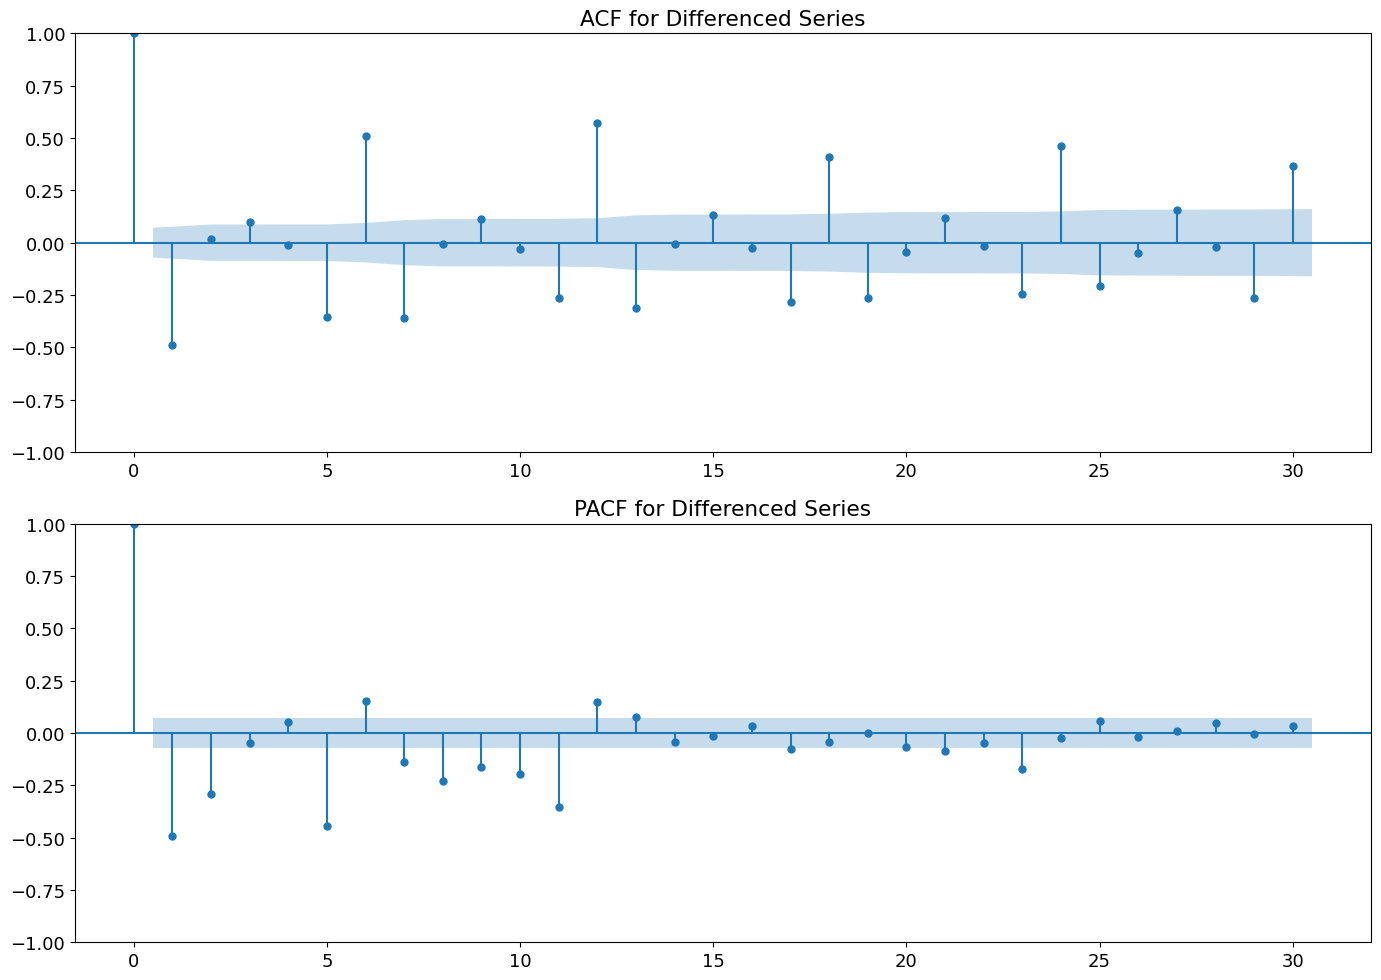

In [272]:
train_ts_diff = train_data['Sales'].diff().dropna()
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
plot_acf(train_ts_diff, lags=30, ax=ax1)
ax1.set_title('ACF for Differenced Series')
plot_pacf(train_ts_diff, lags=30, ax=ax2)
ax2.set_title('PACF for Differenced Series')
plt.tight_layout()
plt.show()

<Axes: title={'center': 'Seasonally Differenced Series'}, xlabel='Date'>

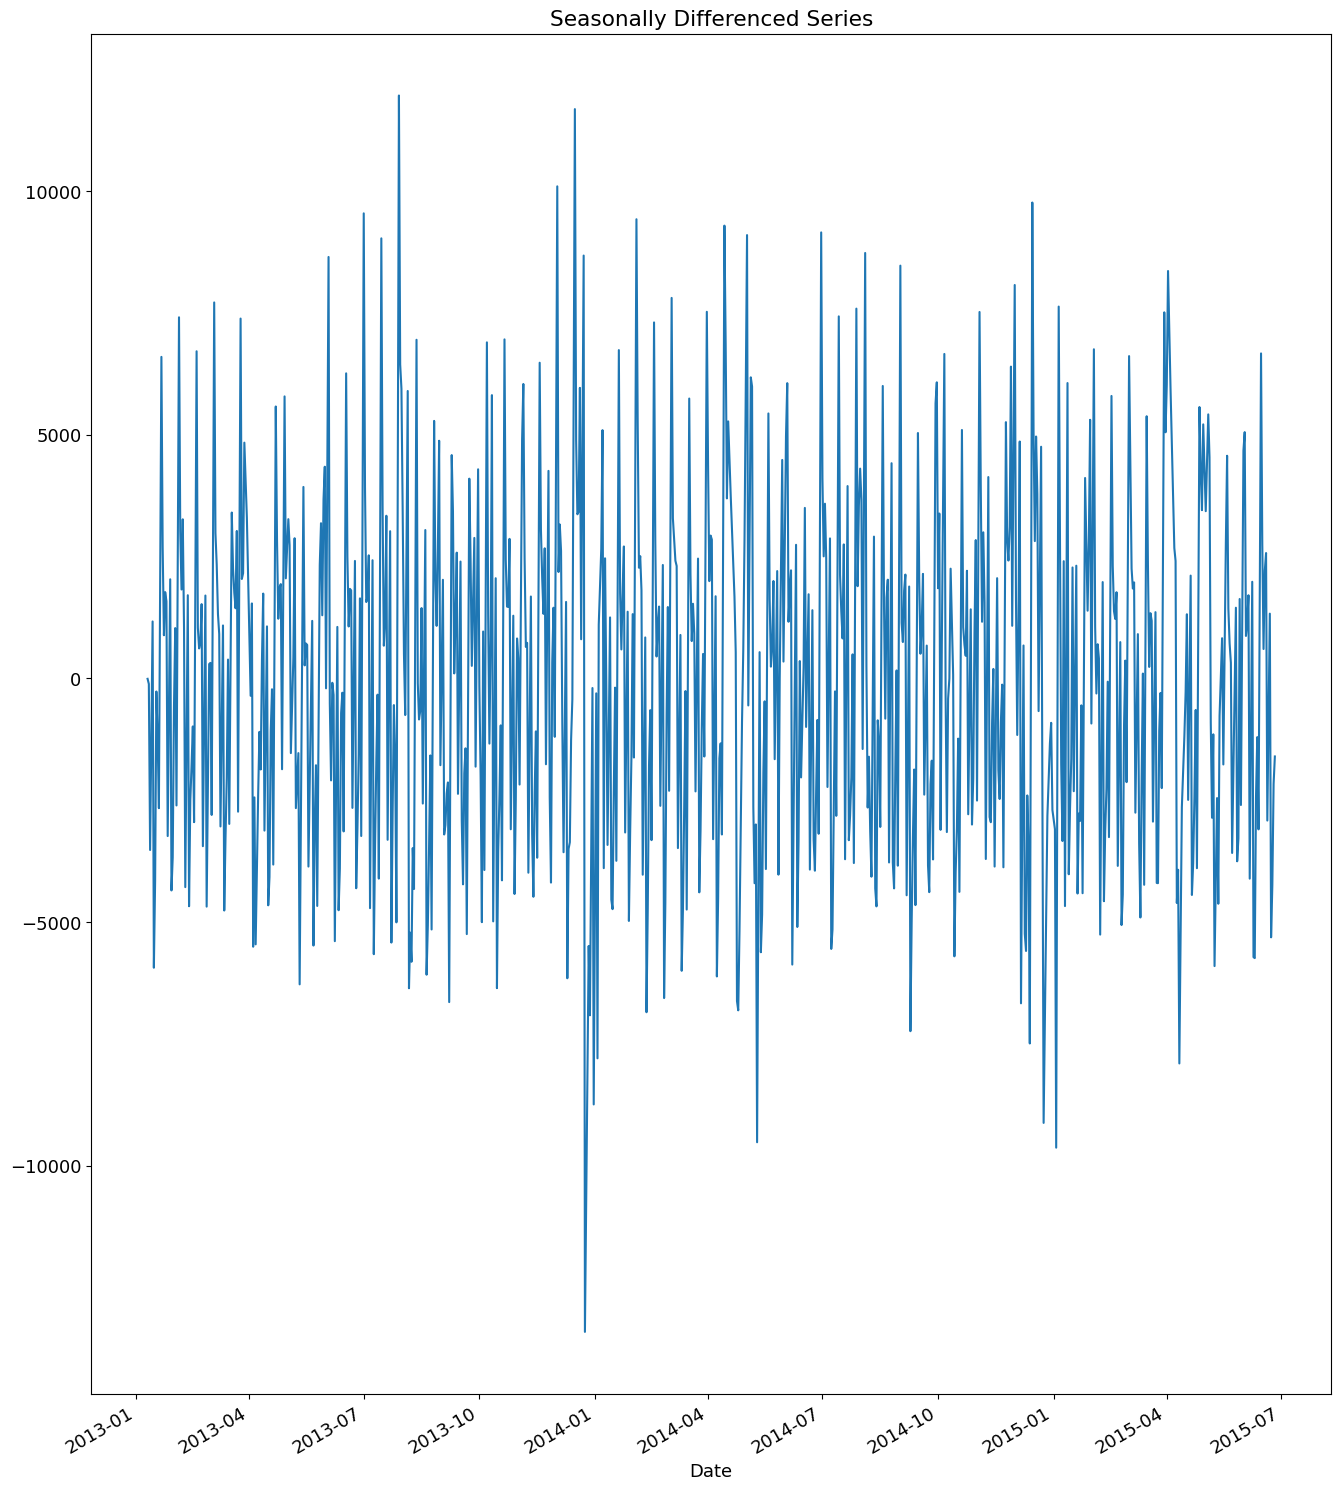

In [273]:
S = 7
seasonal_diff = train_data['Sales'].diff(S)
seasonal_diff.dropna().plot(title="Seasonally Differenced Series")


In [274]:
test_stationarity(seasonal_diff)

ADF Statistic: -10.118439
p-value: 0.000000
Critical Values:
	1%: -3.439
	5%: -2.866
	10%: -2.569
Result: The series is stationary


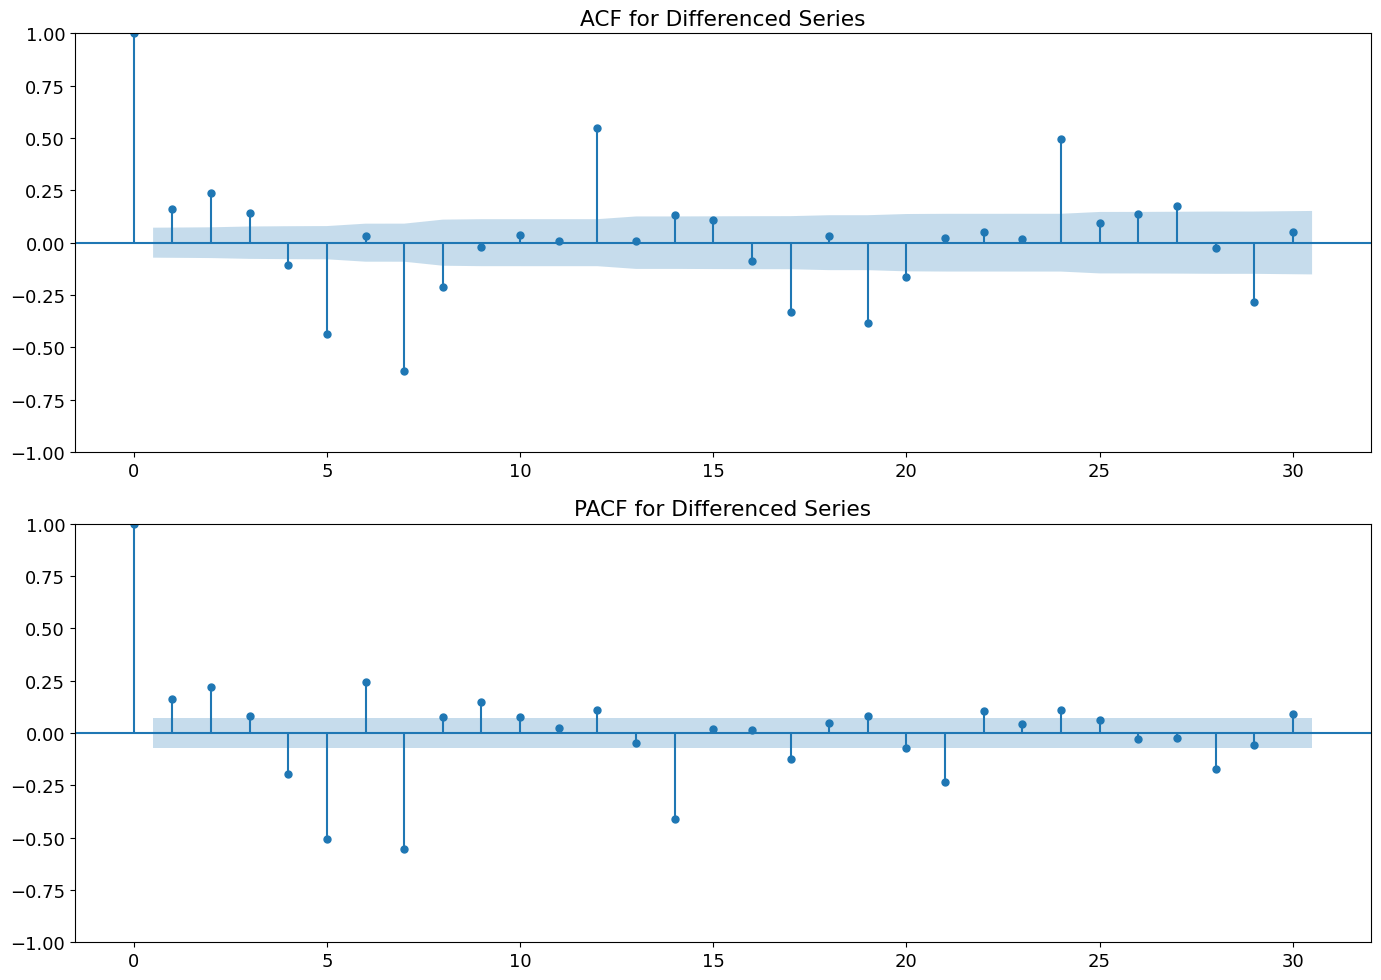

In [275]:
S = 7
seasonal_diff = train_data['Sales'].diff(S).dropna()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
plot_acf(seasonal_diff, lags=30, ax=ax1)
ax1.set_title('ACF for Differenced Series')
plot_pacf(seasonal_diff, lags=30, ax=ax2)
ax2.set_title('PACF for Differenced Series')
plt.tight_layout()
plt.show()


- Extracted values:
  - p: 1
  - d: 1
  - q: 2
  - s: 7
  - P: 1
  - Q: 1
  - D: 0 if stationary, 1 if there is seasonality


In [276]:
def fit_evaluate_arima(train_data, valid_data, order, seasonal_order=None):
    if seasonal_order:
        from statsmodels.tsa.statespace.sarimax import SARIMAX
        model = SARIMAX(train_data, order=order, seasonal_order=seasonal_order)
        model_name = f"SARIMA{order}{seasonal_order}"
    else:
        model = ARIMA(train_data, order=order)
        model_name = f"ARIMA{order}"
    
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(valid_data))
    
    metrics = evaluate_model(valid_data.values, forecast.values, model_name)
    
    plt.figure(figsize=(14, 6))
    plt.plot(valid_data.index, valid_data.values, label='Actual')
    plt.plot(valid_data.index, forecast.values, label=f'{model_name} Forecast')
    plt.title(f'{model_name} Forecast')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return metrics, model_fit


Fitting ARIMA(1, 1, 1) model...


c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(1, 1, 1) Results:
MSE: 9425541.27
RMSE: 3070.10
MAE: 2515.46
RMSPE: 0.2560
****************************************


c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


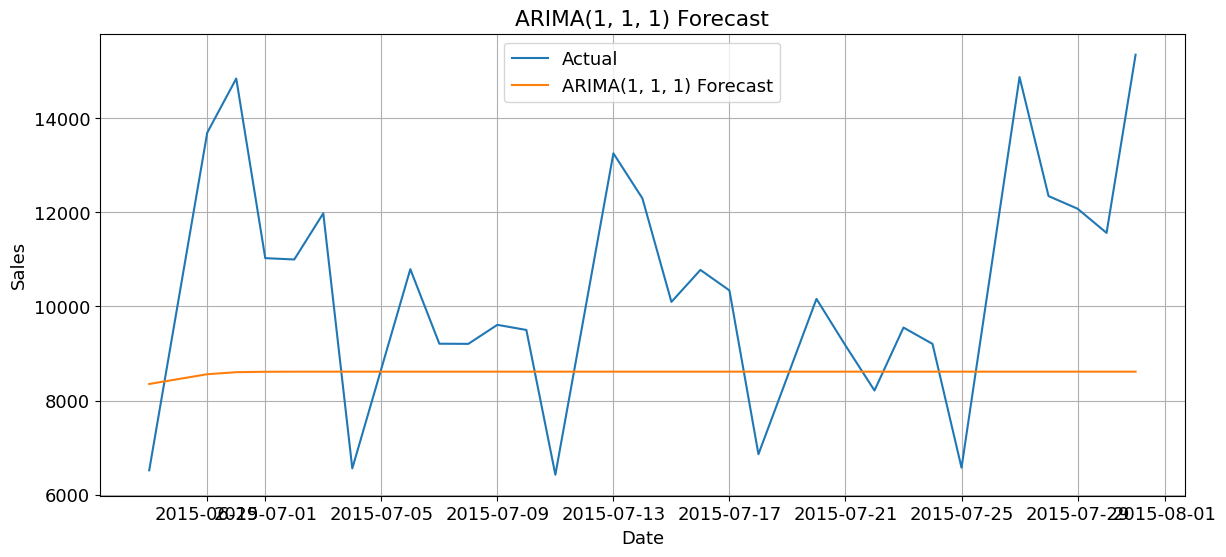

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  756
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -6924.404
Date:                Fri, 30 May 2025   AIC                          13854.809
Time:                        19:19:29   BIC                          13868.689
Sample:                             0   HQIC                         13860.155
                                - 756                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2073      0.039      5.321      0.000       0.131       0.284
ma.L1         -0.9496      0.012    -79.874      0.000      -0.973      -0.926
sigma2      5.401e+06   2.44e+05     22.137      0.0

c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting au

ARIMA(2, 1, 2) Results:
MSE: 8833330.02
RMSE: 2972.09
MAE: 2402.08
RMSPE: 0.2448
****************************************


c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


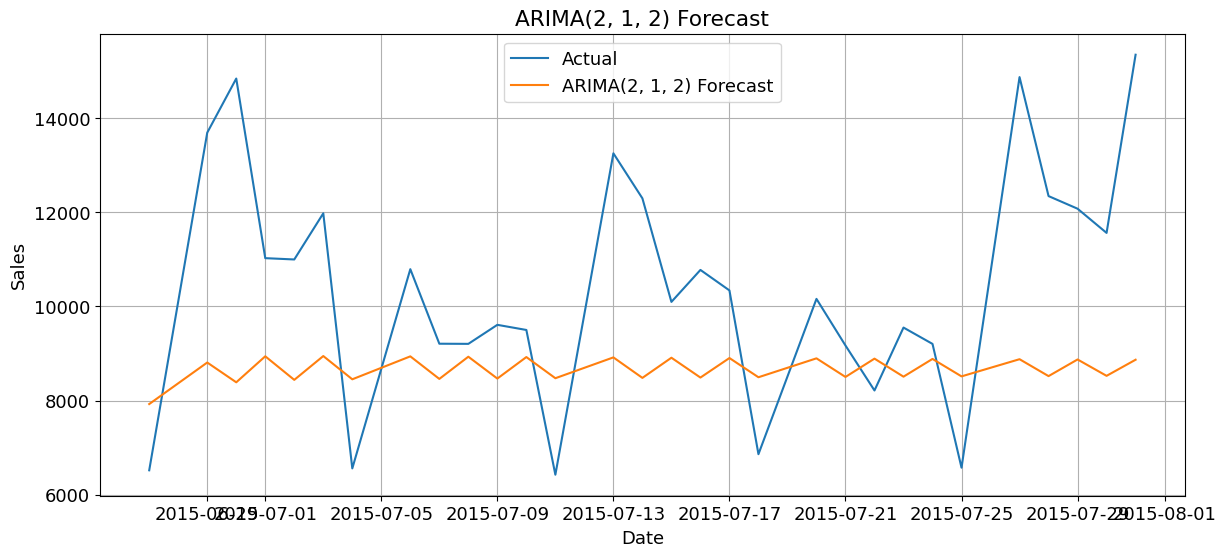

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  756
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -6901.260
Date:                Fri, 30 May 2025   AIC                          13812.521
Time:                        19:19:29   BIC                          13835.654
Sample:                             0   HQIC                         13821.432
                                - 756                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6745      0.045    -14.892      0.000      -0.763      -0.586
ar.L2          0.3046      0.043      7.016      0.000       0.220       0.390
ma.L1         -0.0261      0.027     -0.958      0.3

c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(2, 1, 1) Results:
MSE: 8894766.17
RMSE: 2982.41
MAE: 2403.42
RMSPE: 0.2515
****************************************


c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


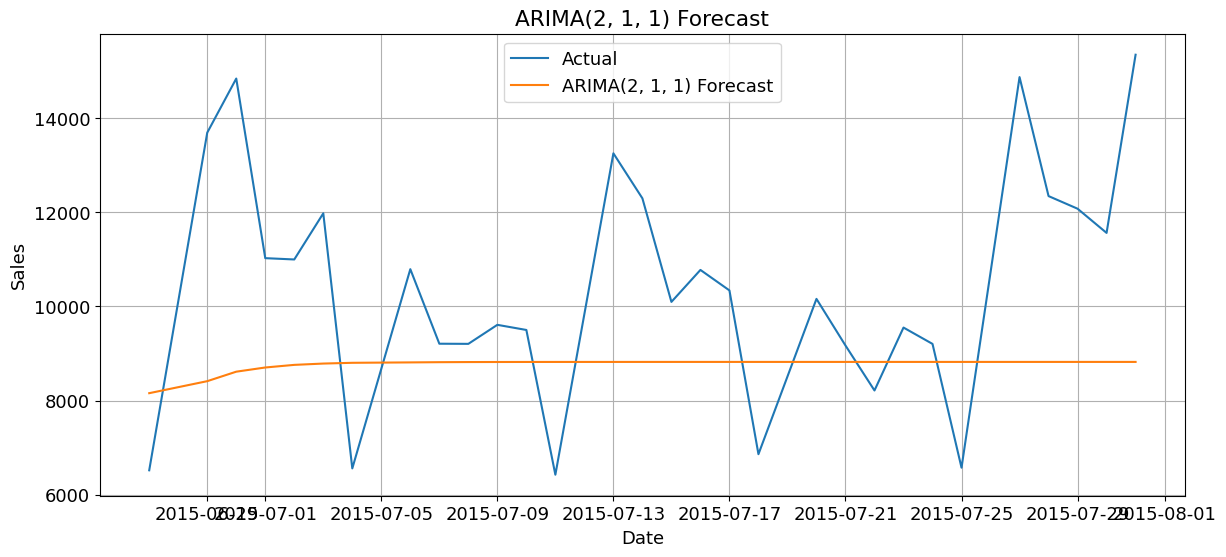

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  756
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -6913.348
Date:                Fri, 30 May 2025   AIC                          13834.696
Time:                        19:19:30   BIC                          13853.203
Sample:                             0   HQIC                         13841.825
                                - 756                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2076      0.031      6.790      0.000       0.148       0.268
ar.L2          0.1846      0.040      4.579      0.000       0.106       0.264
ma.L1         -0.9832      0.007   -134.901      0.0

c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is availab

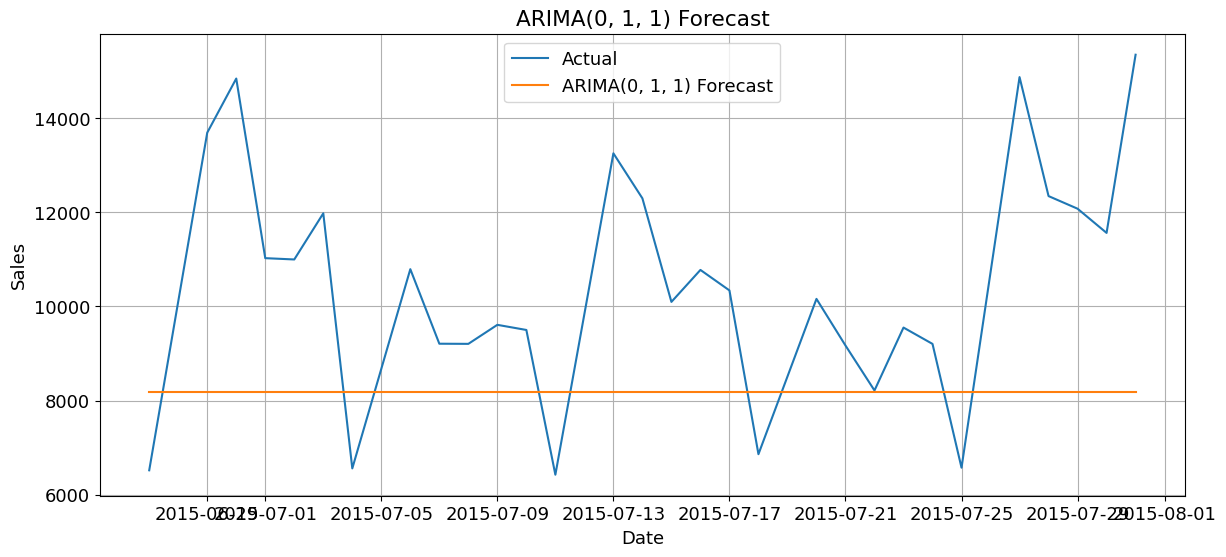

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  756
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -6936.622
Date:                Fri, 30 May 2025   AIC                          13877.245
Time:                        19:19:30   BIC                          13886.498
Sample:                             0   HQIC                         13880.809
                                - 756                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8904      0.015    -57.756      0.000      -0.921      -0.860
sigma2      5.572e+06   2.56e+05     21.728      0.000    5.07e+06    6.07e+06
Ljung-Box (L1) (Q):                  17.17   Jarque-

c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is availab

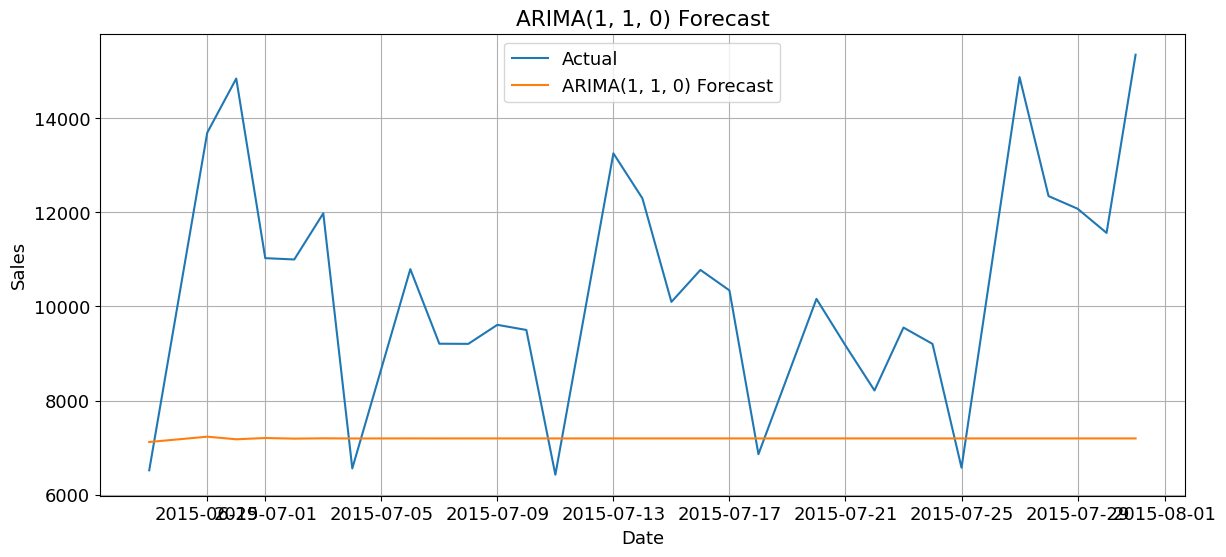

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  756
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -6991.896
Date:                Fri, 30 May 2025   AIC                          13987.792
Time:                        19:19:30   BIC                          13997.046
Sample:                             0   HQIC                         13991.357
                                - 756                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4869      0.035    -13.861      0.000      -0.556      -0.418
sigma2      6.476e+06   3.09e+05     20.985      0.000    5.87e+06    7.08e+06
Ljung-Box (L1) (Q):                  15.87   Jarque-

In [277]:
arima_orders = [
    (1, 1, 1),
    (2, 1, 2),
    (2, 1, 1),
    (0, 1, 1),
    (1, 1, 0)
]

arima_results = []

for order in arima_orders:
    print(f"\nFitting ARIMA{order} model...")
    metrics, model = fit_evaluate_arima(train_data['Sales'], valid_data['Sales'], order)
    print(model.summary())

    arima_results.append((f"ARIMA{order}", metrics))

In [278]:
from pmdarima import auto_arima

auto_arima(train_data['Sales'], n_fits=20).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  756
Model:               SARIMAX(3, 1, 2)   Log Likelihood               -6896.728
Date:                Fri, 30 May 2025   AIC                          13805.455
Time:                        19:19:39   BIC                          13833.216
Sample:                             0   HQIC                         13816.149
                                - 756                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6878      0.042    -16.371      0.000      -0.770      -0.605
ar.L2          0.3754      0.048      7.900      0.000       0.282       0.469
ar.L3          0.0816      0.042      1.930      0.054      -0.001       0.164
ma.L1         -0.0333      0.025     -1.352      0.176      -0.082       0.015
ma.L2         -0.9224      0.025    -36.295      0.000      -0.972      -0.873
sigma2       5.01e+06   1.33e-09   3.76e+15      0.000    5.01e+06    5.01e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):                82.77
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               1.03   Skew:                             0.68
Prob(H) (two-sided):                  0.80   Kurtosis:                         3.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.5e+31. Standard errors may be unstable.
"""


Fitting SARIMA(1, 1, 1)(1, 0, 1, 7) model...


c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(1, 1, 1)(1, 0, 1, 7) Results:
MSE: 9436341.05
RMSE: 3071.86
MAE: 2547.18
RMSPE: 0.2553
****************************************


c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


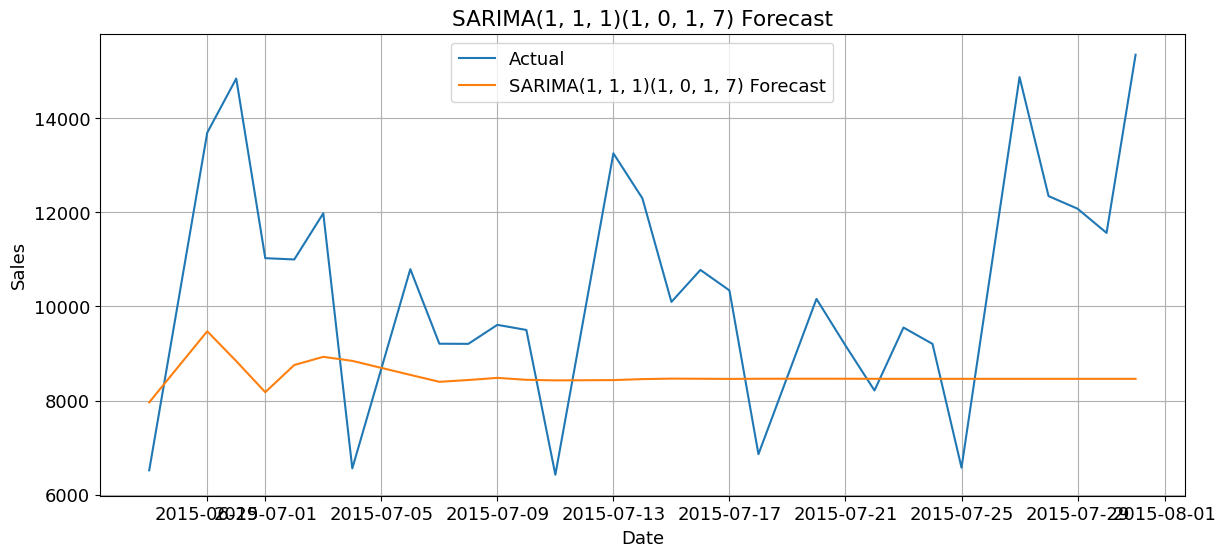

                                     SARIMAX Results                                     
Dep. Variable:                             Sales   No. Observations:                  756
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -6878.210
Date:                           Fri, 30 May 2025   AIC                          13766.419
Time:                                   19:19:40   BIC                          13789.553
Sample:                                        0   HQIC                         13775.330
                                           - 756                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1608      0.044      3.634      0.000       0.074       0.248
ma.L1         -0.8788      0.022    -40.552

c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(0, 1, 1)(1, 0, 1, 7) Results:
MSE: 10080201.29
RMSE: 3174.93
MAE: 2644.52
RMSPE: 0.2613
****************************************


c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


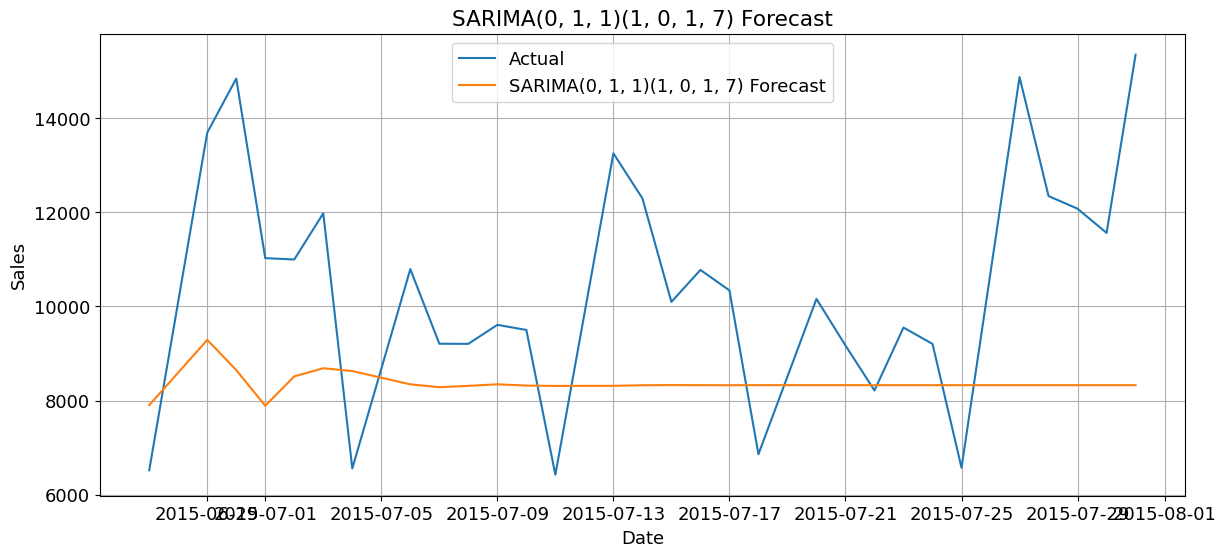

                                     SARIMAX Results                                     
Dep. Variable:                             Sales   No. Observations:                  756
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -6884.742
Date:                           Fri, 30 May 2025   AIC                          13777.483
Time:                                   19:19:40   BIC                          13795.990
Sample:                                        0   HQIC                         13784.612
                                           - 756                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8226      0.020    -40.288      0.000      -0.863      -0.783
ar.S.L7       -0.0436      0.096     -0.453

c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next

SARIMA(2, 1, 1)(0, 0, 1, 7) Results:
MSE: 9188783.53
RMSE: 3031.30
MAE: 2501.77
RMSPE: 0.2535
****************************************


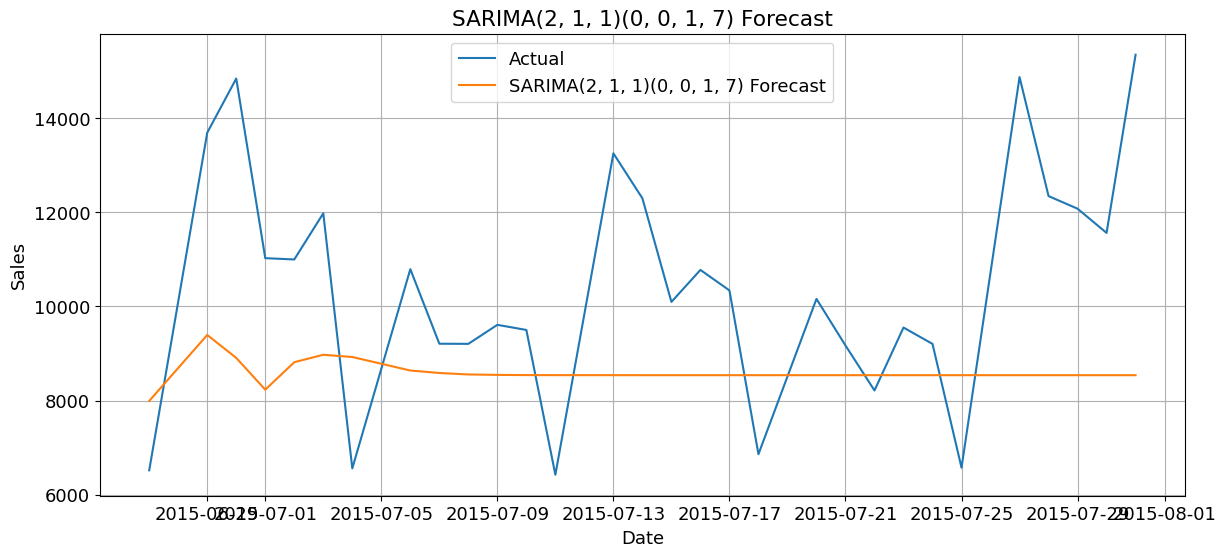

                                     SARIMAX Results                                     
Dep. Variable:                             Sales   No. Observations:                  756
Model:             SARIMAX(2, 1, 1)x(0, 0, 1, 7)   Log Likelihood               -6884.738
Date:                           Fri, 30 May 2025   AIC                          13779.476
Time:                                   19:19:41   BIC                          13802.610
Sample:                                        0   HQIC                         13788.387
                                           - 756                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1716      0.051      3.339      0.001       0.071       0.272
ar.L2          0.0765      0.055      1.397

In [279]:
seasonal_period = 7
sarima_configs = [
    ((1, 1, 1), (1, 0, 1, seasonal_period)),
    ((0, 1, 1), (1, 0, 1, seasonal_period)),
    ((2, 1, 1), (0, 0, 1, seasonal_period))
    
]


for order, seasonal_order in sarima_configs:
    print(f"\nFitting SARIMA{order}{seasonal_order} model...")
    metrics, model = fit_evaluate_arima(train_data['Sales'], valid_data['Sales'], order, seasonal_order)
    print(model.summary())
    arima_results.append((f"SARIMA{order}{seasonal_order}", metrics))


Fitting SARIMA(2, 1, 1)(0, 0, 1, 14) model...


c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(2, 1, 1)(0, 0, 1, 14) Results:
MSE: 8934939.85
RMSE: 2989.14
MAE: 2408.14
RMSPE: 0.2525
****************************************


c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


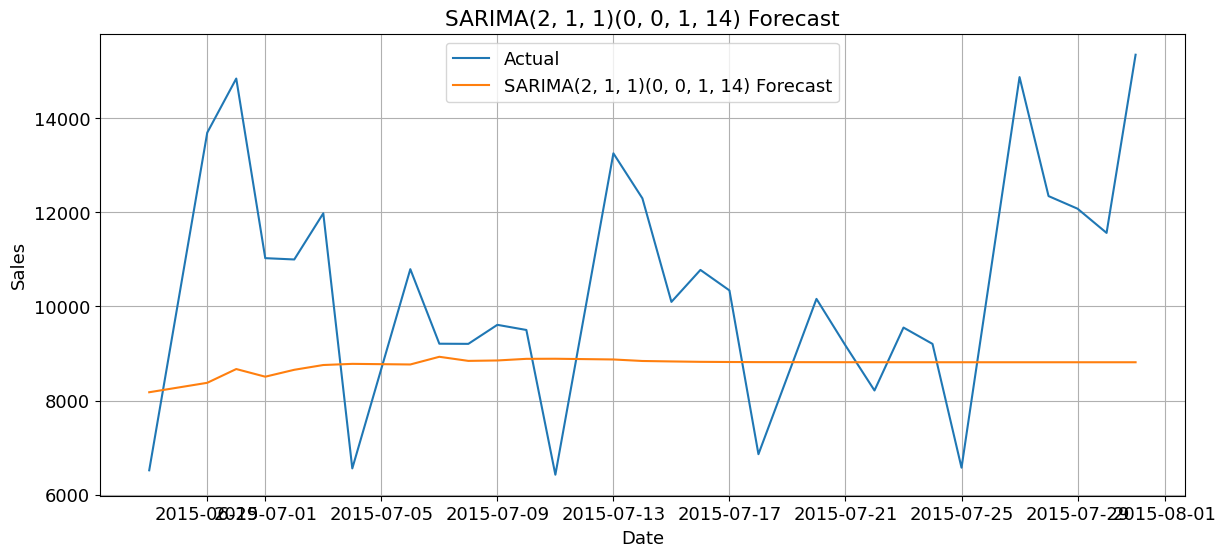

In [280]:
seasonal_period = 14
sarima_configs = [
    ((2, 1, 1), (0, 0, 1, seasonal_period))
    
]


for order, seasonal_order in sarima_configs:
    print(f"\nFitting SARIMA{order}{seasonal_order} model...")
    metrics, _ = fit_evaluate_arima(train_data['Sales'], valid_data['Sales'], order, seasonal_order)
    arima_results.append((f"SARIMA{order}{seasonal_order}", metrics))

## Using AutoArima

In [281]:
from pmdarima import auto_arima

auto_arima(train_data['Sales'], seasonal=True, m=7, n_fits=20).summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  756
Model:             SARIMAX(5, 1, 3)x(1, 0, [1, 2], 7)   Log Likelihood               -6795.858
Date:                                Fri, 30 May 2025   AIC                          13615.717
Time:                                        19:21:14   BIC                          13671.238
Sample:                                             0   HQIC                         13637.104
                                                - 756                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6230      0.048    -13.075      0.000      -0.716      -0.530
ar.L2         -0.3326      0.061     -5.417      0.000      -0.453      -0.212
ar.L3          0.4255      0.058      7.384      0.000       0.313       0.538
ar.L4          0.0660      0.054      1.230      0.219      -0.039       0.171
ar.L5         -0.2140      0.051     -4.231      0.000      -0.313      -0.115
ma.L1          0.0004      0.034      0.012      0.991      -0.066       0.066
ma.L2         -0.0705      0.033     -2.135      0.033      -0.135      -0.006
ma.L3         -0.8322      0.032    -26.313      0.000      -0.894      -0.770
ar.S.L7       -0.7255      0.142     -5.114      0.000      -1.004      -0.447
ma.S.L7        0.6078      0.149      4.084      0.000       0.316       0.899
ma.S.L14       0.0392      0.058      0.672      0.502      -0.075       0.154
sigma2      4.404e+06   3.56e-08   1.24e+14      0.000     4.4e+06     4.4e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):               173.98
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               0.98   Skew:                             0.73
Prob(H) (two-sided):                  0.89   Kurtosis:                         4.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.59e+29. Standard errors may be unstable.
"""

## Arima Results


In [282]:
arima_results

[('ARIMA(1, 1, 1)',
  ('ARIMA(1, 1, 1)',
   9425541.27232358,
   3070.1044399700118,
   2515.463628136445,
   0.25600301155613087)),
 ('ARIMA(2, 1, 2)',
  ('ARIMA(2, 1, 2)',
   8833330.017483782,
   2972.0918588569534,
   2402.084456042711,
   0.24478291606610184)),
 ('ARIMA(2, 1, 1)',
  ('ARIMA(2, 1, 1)',
   8894766.167816442,
   2982.409456767538,
   2403.4152139565936,
   0.2515297767516441)),
 ('ARIMA(0, 1, 1)',
  ('ARIMA(0, 1, 1)',
   11236120.0390815,
   3352.032225245083,
   2789.300833811972,
   0.2723399910016651)),
 ('ARIMA(1, 1, 0)',
  ('ARIMA(1, 1, 0)',
   16594757.935872568,
   4073.666399678865,
   3437.004260163942,
   0.32703502341216695)),
 ('SARIMA(1, 1, 1)(1, 0, 1, 7)',
  ('SARIMA(1, 1, 1)(1, 0, 1, 7)',
   9436341.048363233,
   3071.8627977764945,
   2547.1797590244214,
   0.2553438486171606)),
 ('SARIMA(0, 1, 1)(1, 0, 1, 7)',
  ('SARIMA(0, 1, 1)(1, 0, 1, 7)',
   10080201.287905108,
   3174.9332729846637,
   2644.522923509074,
   0.2613125795551425)),
 ('SARIMA(2, 1,

In [283]:
arima_metrics = pd.DataFrame({
    'Model': [result[0] for result in arima_results],
    'MSE': [result[1][1] for result in arima_results],
    'RMSE': [result[1][2] for result in arima_results],
    'MAE': [result[1][3] for result in arima_results],
    'RMSPE': [result[1][4] for result in arima_results]
})

print("Comparison of ARIMA Models:")
arima_metrics.sort_values('RMSPE')

Comparison of ARIMA Models:


Model           MSE         RMSE          MAE  \
1                ARIMA(2, 1, 2)  8.833330e+06  2972.091859  2402.084456   
2                ARIMA(2, 1, 1)  8.894766e+06  2982.409457  2403.415214   
8  SARIMA(2, 1, 1)(0, 0, 1, 14)  8.934940e+06  2989.136973  2408.144422   
7   SARIMA(2, 1, 1)(0, 0, 1, 7)  9.188784e+06  3031.300634  2501.765230   
5   SARIMA(1, 1, 1)(1, 0, 1, 7)  9.436341e+06  3071.862798  2547.179759   
0                ARIMA(1, 1, 1)  9.425541e+06  3070.104440  2515.463628   
6   SARIMA(0, 1, 1)(1, 0, 1, 7)  1.008020e+07  3174.933273  2644.522924   
3                ARIMA(0, 1, 1)  1.123612e+07  3352.032225  2789.300834   
4                ARIMA(1, 1, 0)  1.659476e+07  4073.666400  3437.004260   

      RMSPE  
1  0.244783  
2  0.251530  
8  0.252529  
7  0.253451  
5  0.255344  
0  0.256003  
6  0.261313  
3  0.272340  
4  0.327035

c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA(2, 1, 1)(0, 0, 1, 14) Results:
MSE: 8934939.85
RMSE: 2989.14
MAE: 2408.14
RMSPE: 0.2525
****************************************


c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


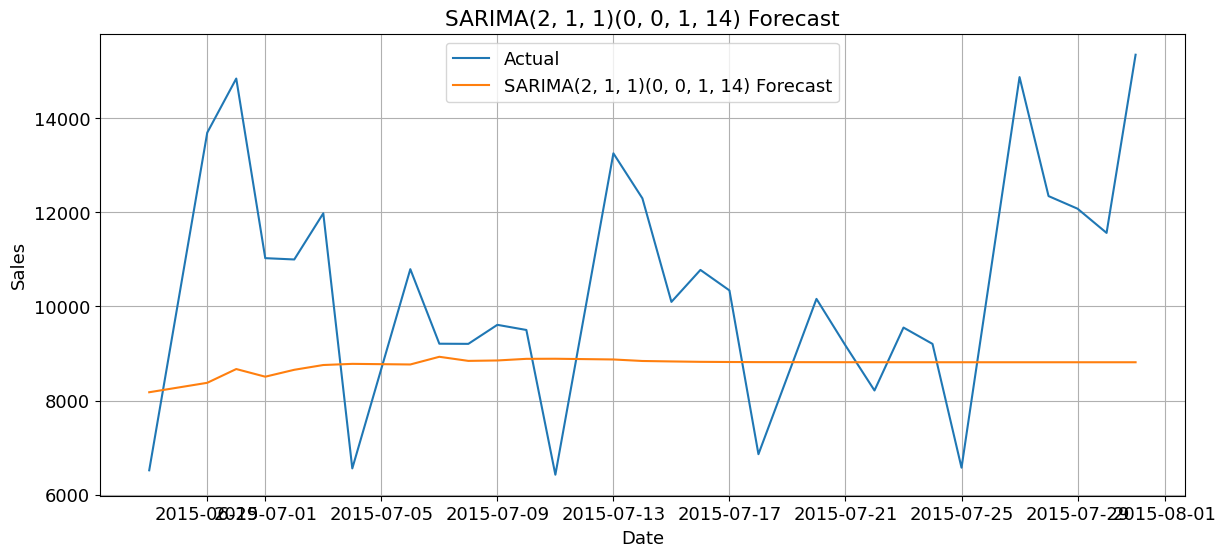

                                     SARIMAX Results                                      
Dep. Variable:                              Sales   No. Observations:                  756
Model:             SARIMAX(2, 1, 1)x(0, 0, 1, 14)   Log Likelihood               -6915.401
Date:                            Fri, 30 May 2025   AIC                          13840.803
Time:                                    19:21:15   BIC                          13863.936
Sample:                                         0   HQIC                         13849.714
                                            - 756                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2058      0.037      5.628      0.000       0.134       0.277
ar.L2          0.1975      0.047   

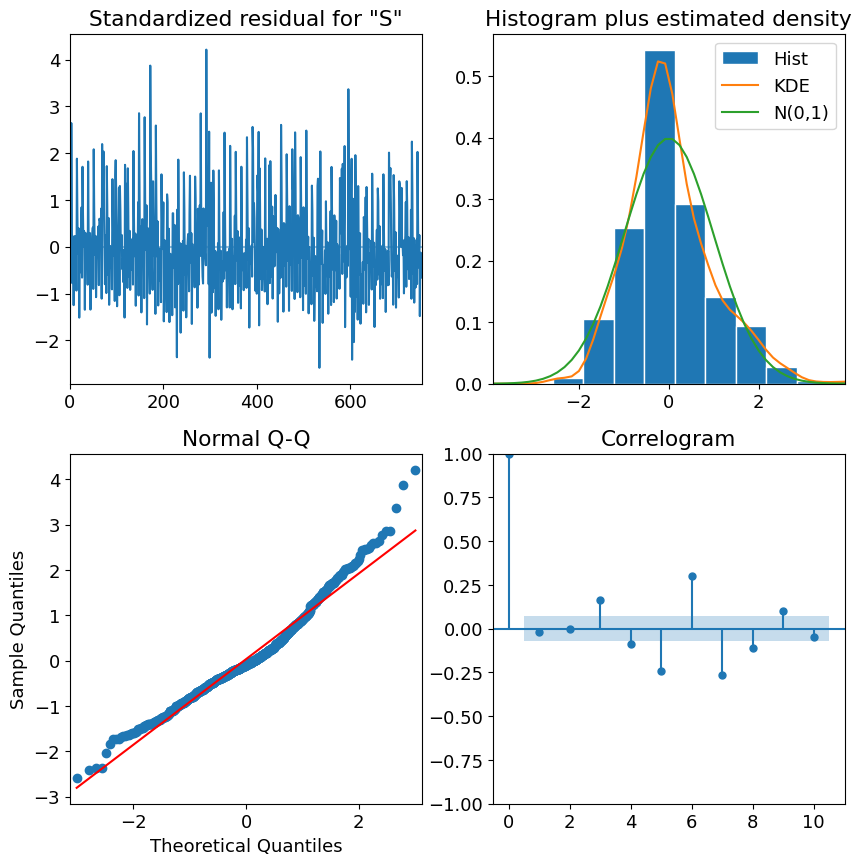

In [284]:
seasonal_period = 7
sarima_configs = [
    ((2, 1, 1), (0, 0, 1, seasonal_period))
    
]
metrics, model = fit_evaluate_arima(train_data['Sales'], valid_data['Sales'], order, seasonal_order)
print(model.summary())
model.plot_diagnostics(figsize=(10, 10))
plt.show()

# 5. Prophet

In [285]:
def prepare_for_prophet(df):
    df_prophet = df.reset_index().rename(columns={'Date': 'ds', 'Sales': 'y'})
    return df_prophet



In [286]:
store_id = 7
store_data = df_full[df_full['Store'] == store_id].copy()
store_data = store_data[store_data['Open'] == 1]
store_data = store_data.sort_values('Date')

In [287]:
store_ts = pd.Series(store_data['Sales'].values, index=store_data['Date'])
store_ts.name = 'Sales'
validation_days = 30
train_ts = store_ts.iloc[:-validation_days]
valid_ts = store_ts.iloc[-validation_days:]
print(train_ts.shape, valid_ts.shape)
train_prophet = prepare_for_prophet(train_ts.reset_index())
valid_prophet = prepare_for_prophet(valid_ts.reset_index())

(756,) (30,)


In [288]:
prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.05
)
prophet_model.fit(train_prophet)

19:21:16 - cmdstanpy - INFO - Chain [1] start processing
19:21:17 - cmdstanpy - INFO - Chain [1] done processing


In [289]:
future = prophet_model.make_future_dataframe(
    periods=(valid_prophet['ds'].max() - train_prophet['ds'].max()).days,
    freq='D'
)
forecast = prophet_model.predict(future)

In [290]:
prophet_predictions = forecast[forecast['ds'].isin(valid_prophet['ds'])]['yhat'].values

In [291]:
prophet_metrics = evaluate_model(valid_ts.values, prophet_predictions, "Prophet")

Prophet Results:
MSE: 3584040.86
RMSE: 1893.16
MAE: 1482.16
RMSPE: 0.1706
****************************************


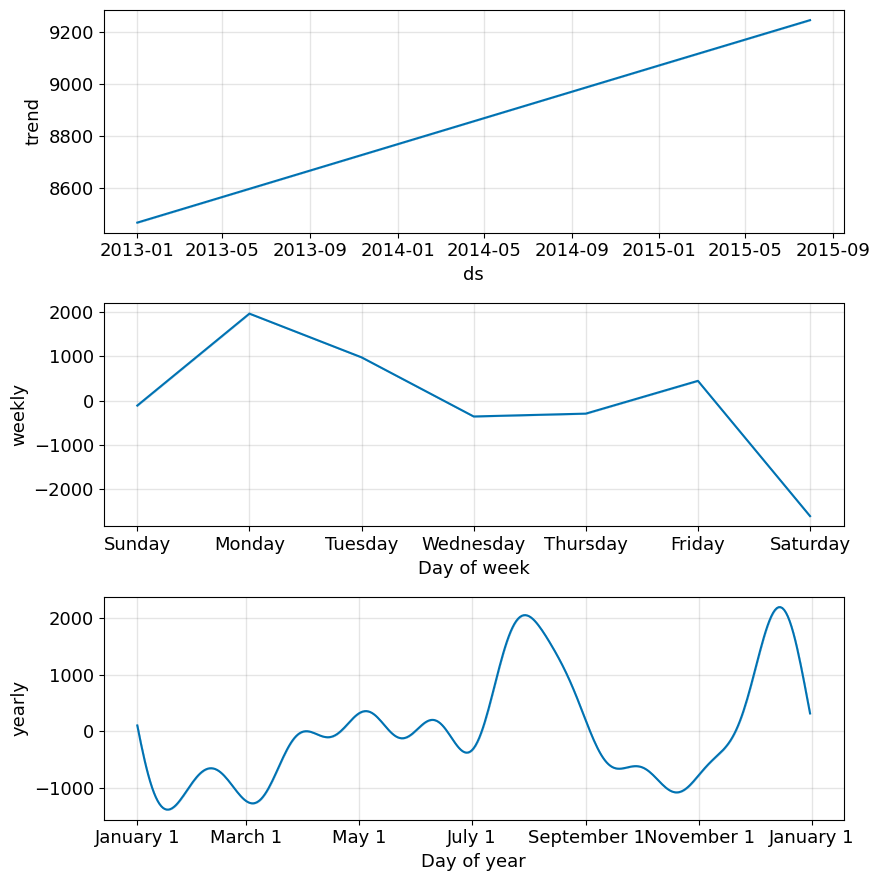

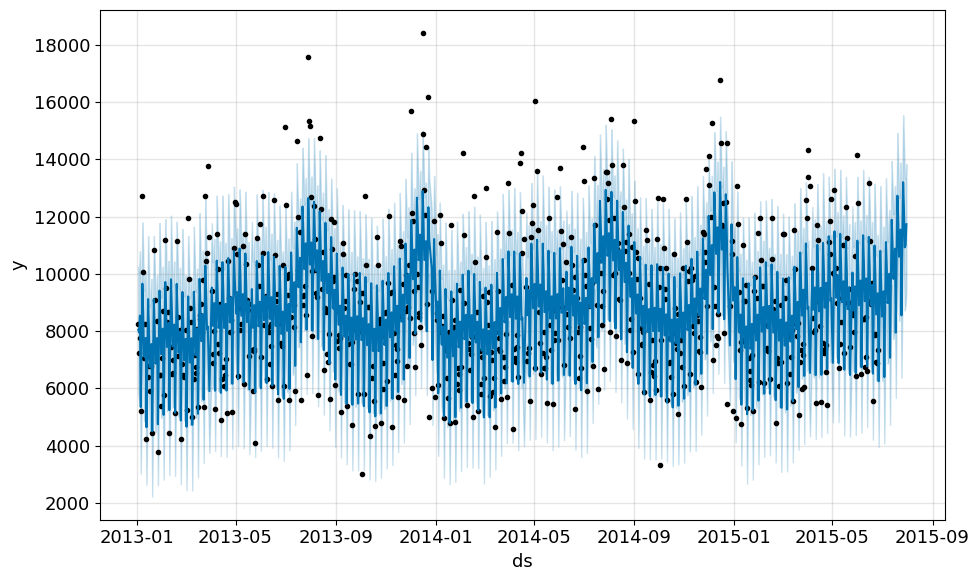

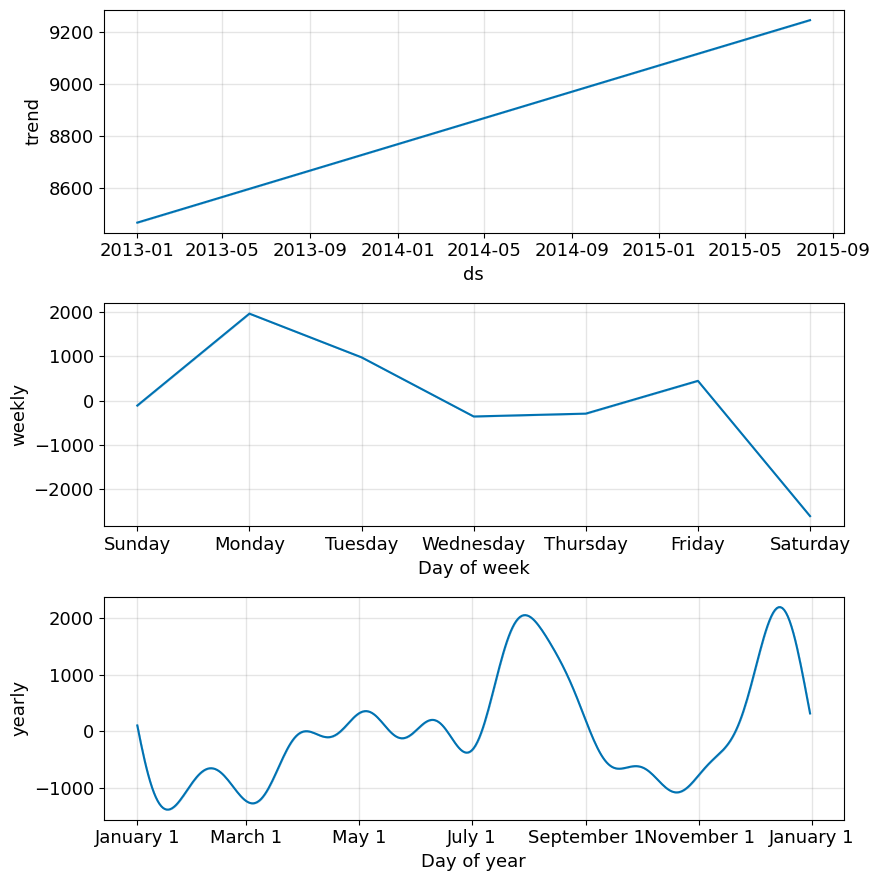

In [292]:
prophet_model.plot(forecast)
prophet_model.plot_components(forecast)


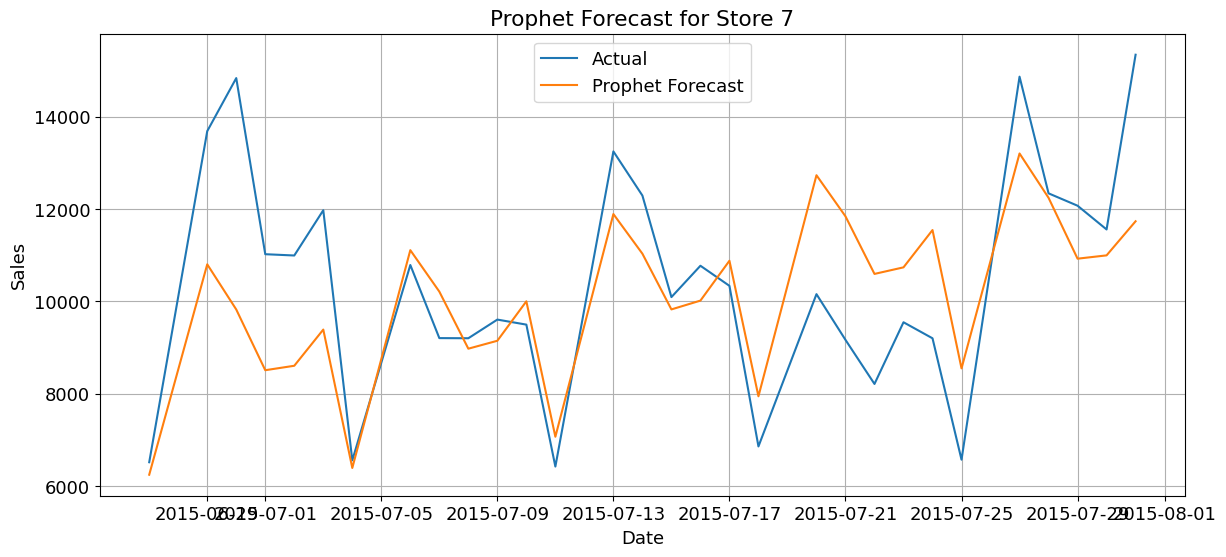

In [293]:
plt.figure(figsize=(14, 6))
plt.plot(valid_ts.index, valid_ts.values, label='Actual')
plt.plot(valid_ts.index, prophet_predictions, label='Prophet Forecast')
plt.title(f'Prophet Forecast for Store {store_id}')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

In [294]:
def prepare_for_prophet_with_regressors(df, store_data):
    """Prepare data for Prophet with additional regressors"""
    dates = df['ds'].to_list()
    
    promo_values = []
    state_holiday_values = []
    school_holiday_values = []
    
    for date in dates:
        matching_rows = store_data[store_data['Date'] == date]
        
        promo = 0 if matching_rows.empty else matching_rows['Promo'].values[0]
        promo_values.append(promo)
        
        state_holiday = 0 if matching_rows.empty else 1 if matching_rows['StateHoliday'].values[0] != '0' else 0
        state_holiday_values.append(state_holiday)
        
        school_holiday = 0 if matching_rows.empty else matching_rows['SchoolHoliday'].values[0]
        school_holiday_values.append(school_holiday)
    
    df['promo'] = promo_values
    df['state_holiday'] = state_holiday_values
    df['school_holiday'] = school_holiday_values
    
    return df

In [295]:
train_prophet_reg = prepare_for_prophet_with_regressors(train_prophet.copy(), store_data)

In [296]:
prophet_model_reg = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)

prophet_model_reg.add_regressor('promo')
prophet_model_reg.add_regressor('state_holiday')
prophet_model_reg.add_regressor('school_holiday')

prophet_model_reg.fit(train_prophet_reg)

19:21:19 - cmdstanpy - INFO - Chain [1] start processing
19:21:19 - cmdstanpy - INFO - Chain [1] done processing


In [297]:
future_reg = prophet_model_reg.make_future_dataframe(
    periods=(valid_prophet['ds'].max() - train_prophet_reg['ds'].max()).days,
    freq='D'
)
future_reg = prepare_for_prophet_with_regressors(future_reg, pd.concat([store_data, valid_prophet.rename(columns={'ds': 'Date', 'y': 'Sales'})]))

In [298]:
forecast_reg = prophet_model_reg.predict(future_reg)

prophet_reg_predictions = forecast_reg[forecast_reg['ds'].isin(valid_prophet['ds'])]['yhat'].values

In [299]:
prophet_reg_metrics = evaluate_model(valid_ts.values, prophet_reg_predictions, "Prophet with Regressors")

Prophet with Regressors Results:
MSE: 1836381.15
RMSE: 1355.13
MAE: 1083.95
RMSPE: 0.1209
****************************************


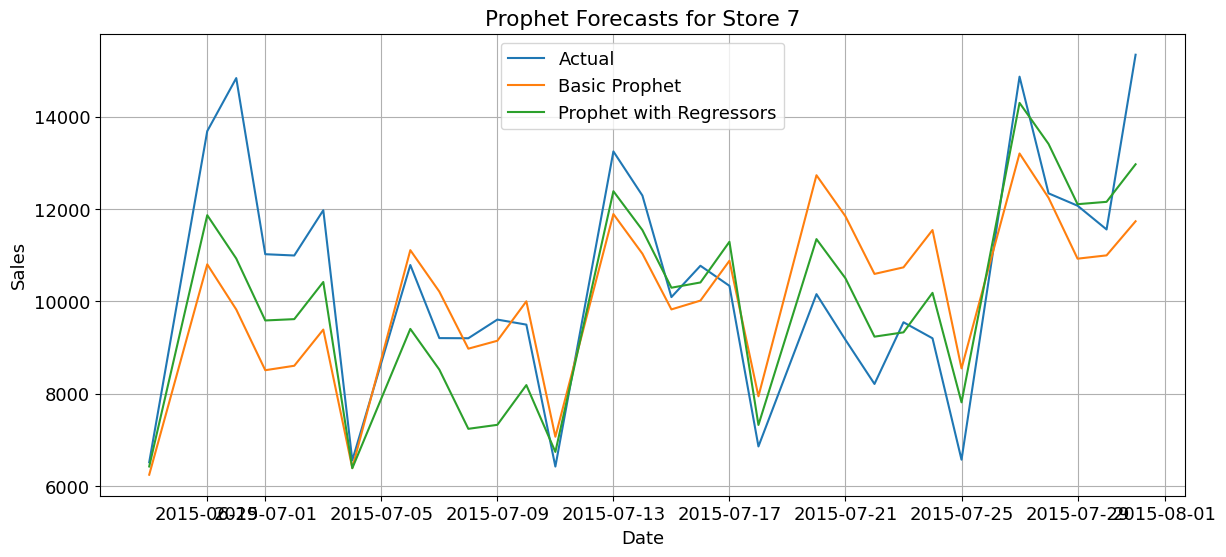

In [300]:
plt.figure(figsize=(14, 6))
plt.plot(valid_ts.index, valid_ts.values, label='Actual')
plt.plot(valid_ts.index, prophet_predictions, label='Basic Prophet')
plt.plot(valid_ts.index, prophet_reg_predictions, label='Prophet with Regressors')
plt.title(f'Prophet Forecasts for Store {store_id}')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

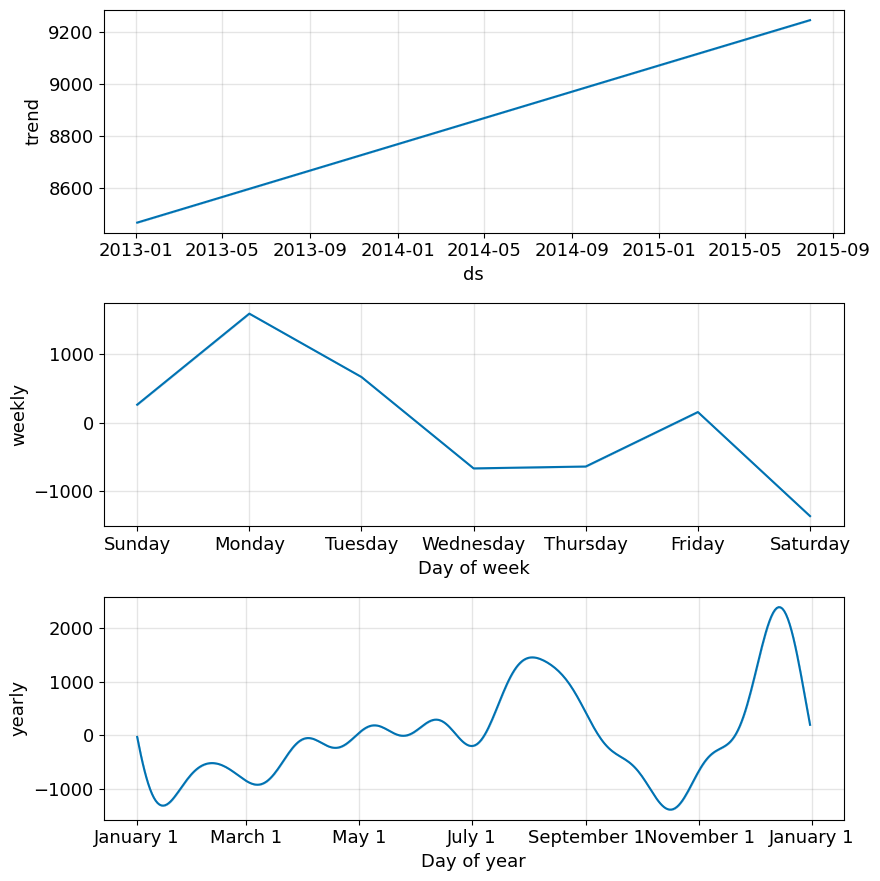

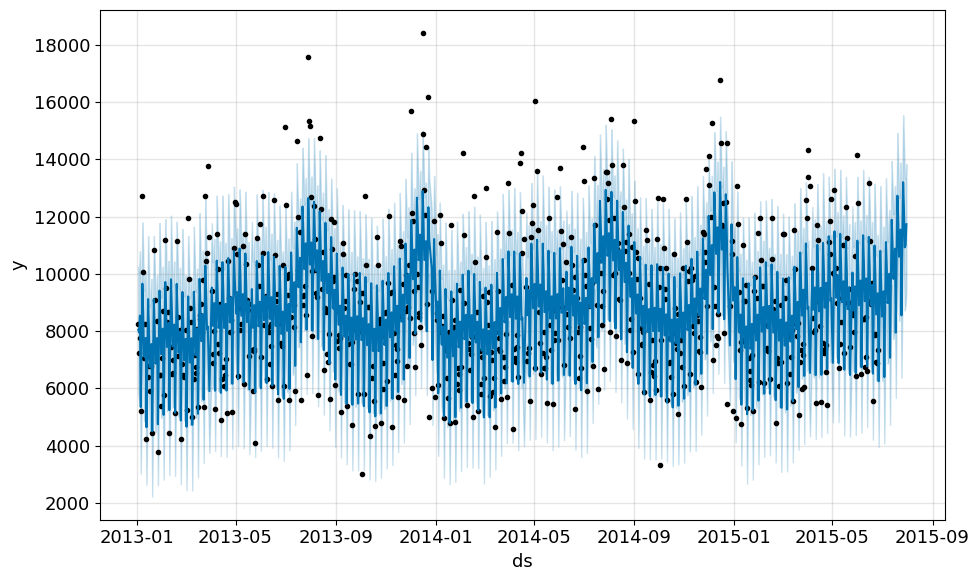

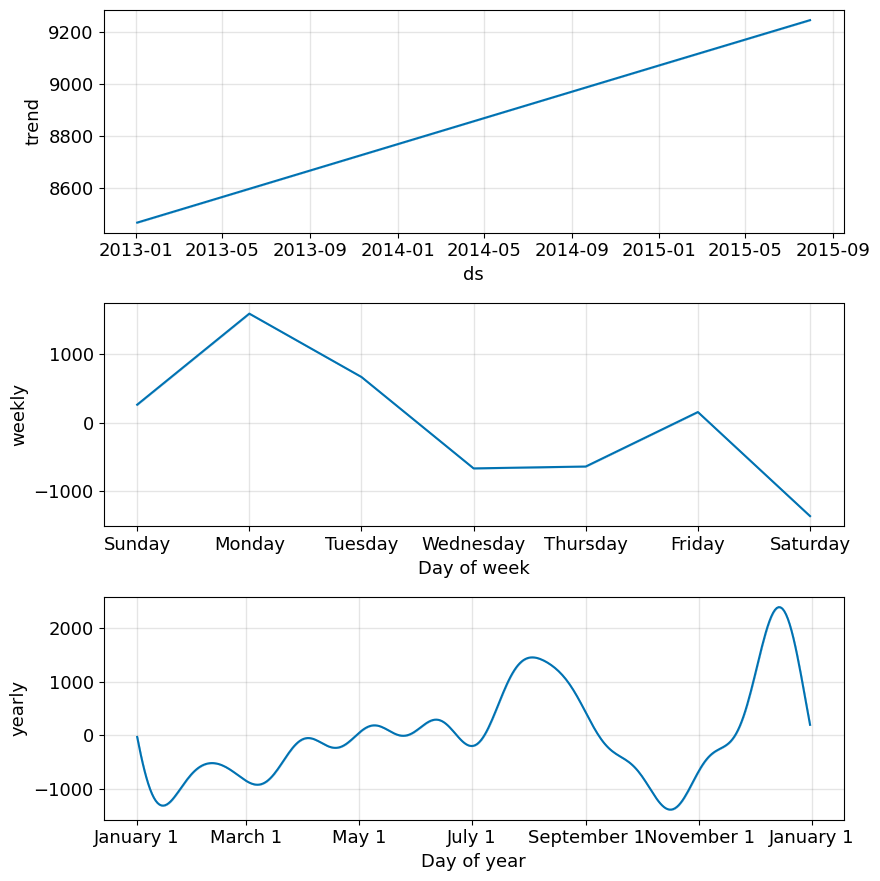

In [301]:
prophet_model_reg.plot(forecast)
prophet_model_reg.plot_components(forecast)

# 6. ML Models

## create features

In [346]:
df_train

Store  DayOfWeek       Date  Sales  Customers  Open  Promo  \
0            1          5 2015-07-31   5263        555     1      1   
1            2          5 2015-07-31   6064        625     1      1   
2            3          5 2015-07-31   8314        821     1      1   
3            4          5 2015-07-31  13995       1498     1      1   
4            5          5 2015-07-31   4822        559     1      1   
...        ...        ...        ...    ...        ...   ...    ...   
1017204   1111          2 2013-01-01      0          0     0      0   
1017205   1112          2 2013-01-01      0          0     0      0   
1017206   1113          2 2013-01-01      0          0     0      0   
1017207   1114          2 2013-01-01      0          0     0      0   
1017208   1115          2 2013-01-01      0          0     0      0   

        StateHoliday  SchoolHoliday  
0                  0              1  
1                  0              1  
2                  0              1  
3                  0              1  
4                  0              1  
...              ...            ...  
1017204            a              1  
1017205            a              1  
1017206            a              1  
1017207            a              1  
1017208            a              1  

[1017209 rows x 9 columns]

In [347]:
df_test

Id  Store  DayOfWeek       Date  Open  Promo StateHoliday  \
0          1      1          4 2015-09-17   1.0      1            0   
1          2      3          4 2015-09-17   1.0      1            0   
2          3      7          4 2015-09-17   1.0      1            0   
3          4      8          4 2015-09-17   1.0      1            0   
4          5      9          4 2015-09-17   1.0      1            0   
...      ...    ...        ...        ...   ...    ...          ...   
41083  41084   1111          6 2015-08-01   1.0      0            0   
41084  41085   1112          6 2015-08-01   1.0      0            0   
41085  41086   1113          6 2015-08-01   1.0      0            0   
41086  41087   1114          6 2015-08-01   1.0      0            0   
41087  41088   1115          6 2015-08-01   1.0      0            0   

       SchoolHoliday  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
...              ...  
41083              0  
41084              0  
41085              0  
41086              0  
41087              1  

[41088 rows x 8 columns]

In [348]:
# create data
def preprocess_rossmann(df, is_train=True):
    # convert date if not parced already
    if not np.issubdtype(df['Date'].dtype, np.datetime64):
        df['Date'] = pd.to_datetime(df['Date'])
    
    # extract calendar parts
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['quarter'] = df['Date'].dt.quarter


    

    # Map StateHoliday from {'a','b','c','0'}
    state_holiday_map = {'0': 0, 'a': 1, 'b': 2, 'c': 3}
    df['StateHoliday'] = df['StateHoliday'].astype(str).map(state_holiday_map).fillna(0).astype(int)
    

    
    # create Embeddings
    df['dayofweek_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
    df['dayofweek_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)
    df['month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
    
    # drop rows with missing flag if training
    if is_train:
            # create lag features
      if 'Sales' in df.columns:
        for lag in [1, 7, 14]:
            df[f'sales_lag_{lag}'] = df.groupby(['Store'])['Sales'].shift(lag)
        
        for window in [7, 14, 30]:
            df[f'sales_rolling_mean_{window}'] = df.groupby(['Store'])['Sales'].transform(
                lambda x: x.shift(1).rolling(window=window, min_periods=1).mean())
            
            df[f'sales_rolling_std_{window}'] = df.groupby(['Store'])['Sales'].transform(
                lambda x: x.shift(1).rolling(window=window, min_periods=1).std())
        df['Assortment'] = df['Assortment'].astype(str).map(state_holiday_map).fillna(0).astype(int)
        df['StoreType'] = df['StoreType'].astype(str).map(state_holiday_map).fillna(0).astype(int)

        df = df[~df["missing"]].copy()
        df.drop(columns = ['PromoInterval'], inplace = True)
            # missing flag (used to identify problematic rows)
        df["missing"] = (
        df["Sales"].isna() |
        ((df["Open"] == 1) & (df["Sales"] == 0)) |
        ((df["Open"] == 0) &
         (df["StateHoliday"].astype(str) == "0") &
         (df["SchoolHoliday"] == 0))
        
        )
        
    return df
    
    


In [371]:
selected_stores = [1, 2, 3, 4, 5, 6, 7]
store_subset = df_train[df_train['Store'].isin(selected_stores)].copy()
ml_df = preprocess_rossmann(store_subset, is_train=False)
ml_df = ml_df[ml_df['Open'] == 1].copy()
ml_df = ml_df.dropna()
X = ml_df.drop(['Sales', 'Date', 'Customers'], axis=1)
y = ml_df['Sales']


In [372]:
validation_days = 30
validation_cutoff = ml_df['Date'].max() - pd.Timedelta(days=validation_days)
X_train = X[ml_df['Date'] <= validation_cutoff]
X_valid = X[ml_df['Date'] > validation_cutoff]
y_train = y[ml_df['Date'] <= validation_cutoff]
y_valid = y[ml_df['Date'] > validation_cutoff]

In [373]:
missing_cols = set(X_train.columns) - set(X_valid.columns)
for col in missing_cols:
    X_valid[col] = 0
X_valid = X_valid[X_train.columns]

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_valid.shape}")

Training set shape: (5291, 15)
Validation set shape: (182, 15)


In [375]:
X_train

Store  DayOfWeek  Open  Promo  StateHoliday  SchoolHoliday  Year  \
33450        1          3     1      1             0              0  2015   
33451        2          3     1      1             0              0  2015   
33452        3          3     1      1             0              1  2015   
33453        4          3     1      1             0              0  2015   
33454        5          3     1      1             0              0  2015   
...        ...        ...   ...    ...           ...            ...   ...   
1014982      3          3     1      0             0              1  2013   
1014983      4          3     1      0             0              1  2013   
1014984      5          3     1      0             0              1  2013   
1014985      6          3     1      0             0              1  2013   
1014986      7          3     1      0             0              1  2013   

         Month  Day  WeekOfYear  quarter  dayofweek_sin  dayofweek_cos  \
33450        7    1          27        3       0.433884      -0.900969   
33451        7    1          27        3       0.433884      -0.900969   
33452        7    1          27        3       0.433884      -0.900969   
33453        7    1          27        3       0.433884      -0.900969   
33454        7    1          27        3       0.433884      -0.900969   
...        ...  ...         ...      ...            ...            ...   
1014982      1    2           1        1       0.433884      -0.900969   
1014983      1    2           1        1       0.433884      -0.900969   
1014984      1    2           1        1       0.433884      -0.900969   
1014985      1    2           1        1       0.433884      -0.900969   
1014986      1    2           1        1       0.433884      -0.900969   

         month_sin  month_cos  
33450         -0.5  -0.866025  
33451         -0.5  -0.866025  
33452         -0.5  -0.866025  
33453         -0.5  -0.866025  
33454         -0.5  -0.866025  
...            ...        ...  
1014982        0.5   0.866025  
1014983        0.5   0.866025  
1014984        0.5   0.866025  
1014985        0.5   0.866025  
1014986        0.5   0.866025  

[5291 rows x 15 columns]

In [374]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler  # For feature scaling
Scaler = StandardScaler()
X_train_scaled = Scaler.fit_transform(X_train)
X_valid_scaled = Scaler.transform(X_valid)



## Random Forest

In [353]:
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train)

RandomForestRegressor(max_depth=20, min_samples_split=10, n_jobs=-1,
                      random_state=42)

In [354]:
rf_predictions = rf_model.predict(X_valid_scaled)
rf_metrics = evaluate_model(y_valid, rf_predictions, "Random Forest")

Random Forest Results:
MSE: 529933.30
RMSE: 727.97
MAE: 534.74
RMSPE: 0.1054
****************************************


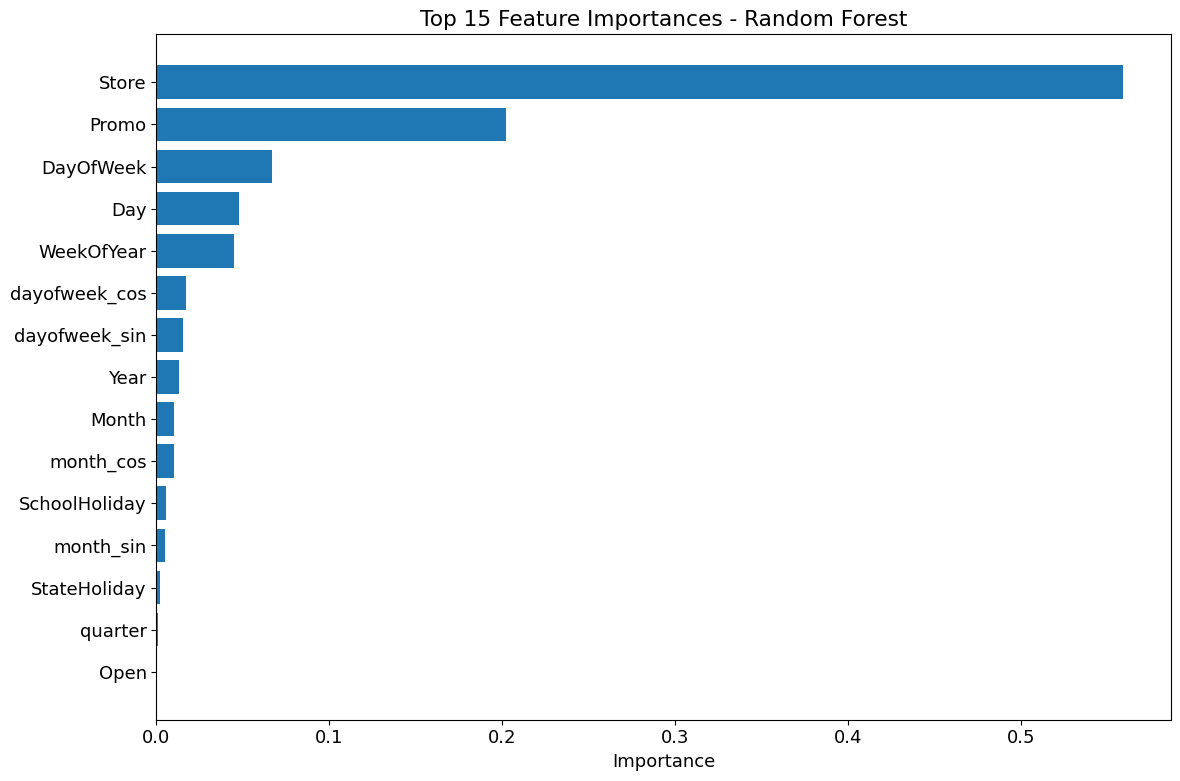

In [355]:
feature_importance = pd.DataFrame(
    {'feature': X_train.columns, 'importance': rf_model.feature_importances_}
).sort_values('importance', ascending=True)

plt.figure(figsize=(12, 8))
plt.barh(feature_importance['feature'][:15], feature_importance['importance'][:15])
plt.title('Top 15 Feature Importances - Random Forest')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

## Gradient Boosting Regressor

In [356]:
gb_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

gb_model.fit(X_train_scaled, y_train)

GradientBoostingRegressor(max_depth=5, random_state=42)

In [357]:
gb_predictions = gb_model.predict(X_valid_scaled)
gb_metrics = evaluate_model(y_valid, gb_predictions, "Gradient Boosting")

Gradient Boosting Results:
MSE: 667360.41
RMSE: 816.92
MAE: 626.12
RMSPE: 0.1269
****************************************


In [358]:
ml_models = ["Random Forest", "Gradient Boosting", "Prophet_reg"]
ml_metrics = pd.DataFrame({
    'Model': ml_models,
    'MSE': [rf_metrics[1], gb_metrics[1], prophet_reg_metrics[1]],
    'RMSE': [rf_metrics[1], gb_metrics[2], prophet_reg_metrics[2]],
    'MAE': [rf_metrics[2], gb_metrics[3], prophet_reg_metrics[3]],
    'RMSPE': [rf_metrics[4], gb_metrics[4], prophet_reg_metrics[4]]
})

print("Comparison of Machine Learning Models:")
ml_metrics.sort_values('RMSPE')

Comparison of Machine Learning Models:


Model           MSE           RMSE          MAE     RMSPE
0      Random Forest  5.299333e+05  529933.299503   727.965177  0.105377
2        Prophet_reg  1.836381e+06    1355.131414  1083.949711  0.120925
1  Gradient Boosting  6.673604e+05     816.921301   626.124107  0.126934

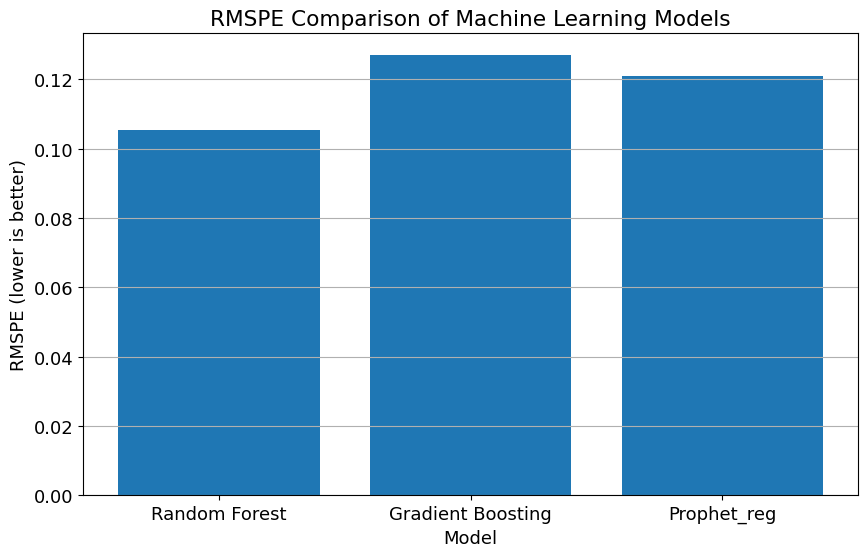

In [359]:
plt.figure(figsize=(10, 6))
plt.bar(ml_metrics['Model'], ml_metrics['RMSPE'])
plt.title('RMSPE Comparison of Machine Learning Models')
plt.xlabel('Model')
plt.ylabel('RMSPE (lower is better)')
plt.grid(True, axis='y')
plt.show()

# Submission

In [ ]:
selected_stores = [1, 2, 3, 4, 5, 6, 7]
store_subset = df_train[df_train['Store'].isin(selected_stores)].copy()
ml_df = ml_df[ml_df['Open'] == 1].copy()
ml_df = ml_df.dropna()
X = ml_df.drop(['Sales', 'Date', 'Customers'], axis=1)
y = ml_df['Sales']


In [362]:
X.shape

(5473, 16)

In [386]:
test_df = pd.read_csv('../data/test.csv', parse_dates=['Date'])
#test_df = test_df[test_df['Open'] == 1].copy()
test_df = preprocess_rossmann(test_df, is_train=False)
print(test_df.isna().sum())


Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
Year              0
Month             0
Day               0
WeekOfYear        0
quarter           0
dayofweek_sin     0
dayofweek_cos     0
month_sin         0
month_cos         0
dtype: int64


In [387]:
test_df = test_df.fillna(0)
X_test = test_df.drop(['Date','Id'], axis=1)
X_test_scaled = Scaler.transform(X_test)

    

print(f"Test data shape: {X_test.shape}")
test_df.head()

Test data shape: (41088, 15)


Id  Store  DayOfWeek       Date  Open  Promo  StateHoliday  SchoolHoliday  \
0   1      1          4 2015-09-17   1.0      1             0              0   
1   2      3          4 2015-09-17   1.0      1             0              0   
2   3      7          4 2015-09-17   1.0      1             0              0   
3   4      8          4 2015-09-17   1.0      1             0              0   
4   5      9          4 2015-09-17   1.0      1             0              0   

   Year  Month  Day  WeekOfYear  quarter  dayofweek_sin  dayofweek_cos  \
0  2015      9   17          38        3      -0.433884      -0.900969   
1  2015      9   17          38        3      -0.433884      -0.900969   
2  2015      9   17          38        3      -0.433884      -0.900969   
3  2015      9   17          38        3      -0.433884      -0.900969   
4  2015      9   17          38        3      -0.433884      -0.900969   

   month_sin     month_cos  
0       -1.0 -1.836970e-16  
1       -1.0 -1.836970e-16  
2       -1.0 -1.836970e-16  
3       -1.0 -1.836970e-16  
4       -1.0 -1.836970e-16

In [389]:
# pick RF model
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train)
y_pred = rf_model.predict(X_test_scaled)

In [391]:
submission = pd.DataFrame({
    'Id': range(1, len(y_pred) + 1),
    'Sales': y_pred
})
submission['Sales'] = submission['Sales'].clip(lower=0)
submission.to_csv('submission.csv', index=False)


In [392]:
submission.head()


Id        Sales
0   1  4264.835729
1   2  7725.101089
2   3  8835.708064
3   4  8835.708064
4   5  8835.708064

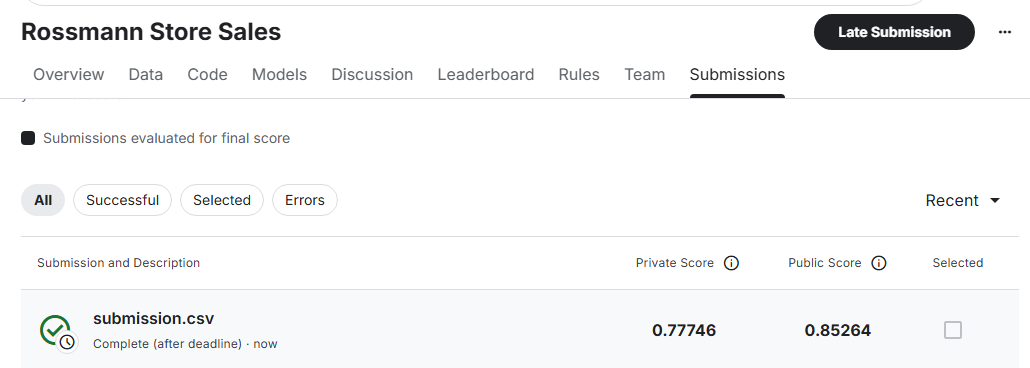